**<h2>Computing Water Potential Energy Surface Using Behler and Parinello Symmetry Functions** 

Importing relevant packages from PyTorch

In [1]:
"""
Created on Sat May 15 17:34:55 2021
@author: Katerina Karoni
"""
import torch                        # Torch is an open-source machine learning library, a scientific computing framework,
                                       #and a script language
import torch.nn as nn
import torch.nn.functional as F     # Convolution Functions
import torch.optim as optim         # Package implementing various optimization algorithms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms  #The torchvision package consists of popular datasets, model 
                                              #architectures, and common image transformations for computer vision
from torch.utils.data import DataLoader, TensorDataset       #Data loading utility class
from torch import Tensor
import pandas as pd

import numpy as np
import random
import os
import ase
from ase import Atoms
from ase.io import read

Loading the data (energies and geometries) for 1000 water molecule configurations in .xyz form

In [2]:
energies = np.genfromtxt('./water/energies.txt')
print("Energies file has",np.shape(energies),"entries")
#geometry_data =  read('./water/structures.xyz',index=':')
#print("Geometry file has",np.shape(geometry_data),"entries")
#print(geometry_data[0])
#geometry_data = np.array(geometry_data)

Energies file has (1000,) entries


In [3]:
# see https://education.molssi.org/python-data-analysis/01-numpy-arrays/index.html
#https://stackoverflow.com/questions/23353585/got-1-columns-instead-of-error-in-numpy

file_location = os.path.join('water', 'structures.xyz')
xyz_file = np.genfromtxt(fname=file_location, skip_header=2, dtype='unicode',invalid_raise = False)
# where invalid_raise = False was used to skip all lines in the xyz file that only have one column
symbols = xyz_file[:,0]
coordinates = (xyz_file[:,1:-1])
coordinates = coordinates.astype(np.float)

#print(symbols)
#print(coordinates)

<ipython-input-3-c38e52de7b08>:5: ConversionWarning: Some errors were detected !
    Line #6 (got 1 columns instead of 5)
    Line #11 (got 1 columns instead of 5)
    Line #16 (got 1 columns instead of 5)
    Line #21 (got 1 columns instead of 5)
    Line #26 (got 1 columns instead of 5)
    Line #31 (got 1 columns instead of 5)
    Line #36 (got 1 columns instead of 5)
    Line #41 (got 1 columns instead of 5)
    Line #46 (got 1 columns instead of 5)
    Line #51 (got 1 columns instead of 5)
    Line #56 (got 1 columns instead of 5)
    Line #61 (got 1 columns instead of 5)
    Line #66 (got 1 columns instead of 5)
    Line #71 (got 1 columns instead of 5)
    Line #76 (got 1 columns instead of 5)
    Line #81 (got 1 columns instead of 5)
    Line #86 (got 1 columns instead of 5)
    Line #91 (got 1 columns instead of 5)
    Line #96 (got 1 columns instead of 5)
    Line #101 (got 1 columns instead of 5)
    Line #106 (got 1 columns instead of 5)
    Line #111 (got 1 columns instead

In [4]:
## Alternatively loading the data in .npy form
# # The data was downloaded from http://www.quantum-machine.org/datasets/ (Densities dataset--> water.zip)
# # The data includes energies, densities and structure for water molecules
# #For each dataset, structures are given in with positions in Bohr and the energies are given in kcal/mol 
# energy_data = np.load('./water_102/dft_energies.npy')
# print("Energies file has",np.shape(energy_data),"entries")
# geometry_data =  np.load('./water-2/water_102/structures.npy')
# print("Geometry file has",np.shape(geometry_data),"entries")
# print(type(energy_data))
# print(type(geometry_data))

In [5]:
print(np.shape(coordinates))
print(type(coordinates))
print(coordinates[0])
print(coordinates[1])
print(coordinates[2])

print('gfjkhgfjhgfkgh')
print(coordinates[3])
print(coordinates[4])
print(coordinates[5])

print(energies[0])
# There is 1000 water molecules and each of them consists of 3 atoms, so we have 3000 atoms in total and each
# of them has 3 coordinates.
# Thus the coordinates array has 3000 lines, each of them corresponding to one atom (the first three lines
# correspopnd to the first water molecule) and 3 columns corresponding to the x, y and z coordinates respectively.

(3000, 3)
<class 'numpy.ndarray'>
[0.         0.769767   0.55746937]
[ 0.         -0.71017975  0.50340914]
[ 0.         -0.0037242  -0.06630491]
gfjkhgfjhgfkgh
[0.         0.77715107 0.59586089]
[ 0.         -0.77642641  0.59515778]
[ 0.000000e+00 -4.529000e-05 -7.443867e-02]
-13815.2523726009


In [6]:
print(coordinates)

[[ 0.          0.769767    0.55746937]
 [ 0.         -0.71017975  0.50340914]
 [ 0.         -0.0037242  -0.06630491]
 ...
 [ 0.          0.81441381  0.59863567]
 [ 0.         -0.76145415  0.54978922]
 [ 0.         -0.00330998 -0.07177656]]


**<h2>Cutoff Function** 
    $$f_c(R_{ij}) = 
    \begin{cases}
        0.5 \times \big[\cos\big(\frac{\pi R_{ij}}{R_c}\big)+1\big]  & \text{for } R_{ij} \leq R_c\\
        0  & \text{for } R_{ij} > R_c
    \end{cases}
    $$
    
In the Behler and Parinello paper the Cutoff radius $R_c$ was taken to be $6$  Ångströms, or 11.3384 Bohr radii. (Remember, 1 Ångström is $10^{-10}$m)

In [7]:
def fc(R,Rc):
    if R <= Rc:
        fcutoff = 0.5 * (np.cos(np.pi*R/Rc)+1)
    else:
        fcutoff = 0
    return fcutoff

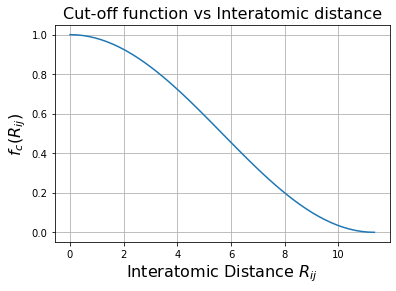

In [8]:
# Plotting fc as a function of interatomic distance Rij

Rc  = 11.3384 # Bohr

Rij     = np.linspace(0,Rc)
fcutoff = np.zeros(np.size(Rij))

for i in range(np.size(Rij)):
    fcutoff[i] = fc(Rij[i],Rc)

plt.plot(Rij,fcutoff)
plt.title('Cut-off function vs Interatomic distance', fontsize=16)
plt.xlabel('Interatomic Distance $R_{ij}$', fontsize=16)
plt.ylabel('$f_c(R_{ij})$', fontsize=16)
plt.grid()

**<h2>Pairwise Distances**

$$Dp = \begin{bmatrix} R_{00} & R_{01} & R_{02} \\ R_{10} & R_{11} & R_{12} \\ R_{20} & R_{21} & R_{22} \end{bmatrix} = \begin{bmatrix} 0 & R_{01} & R_{02} \\ R_{01} & 0 & R_{12} \\ R_{02} & R_{12} & 0 \end{bmatrix} $$

In [9]:
i = 0                                # i-th water molecule
N = 3                                # 3 atoms per molecule
coord = coordinates[N*i:N*(i+1),:]  # Let's take the coordinates of the ith water molecule in our dataset and compute
                                     # pairwise distances between all of its 3 atom
    
def pairwise_distances(coord):                       # we pass in the coordinates of the 3 atoms in the water molecule
    N = len(coord)
    pairwise_dist_matrix = np.zeros((N,N))       # Initialise the matrix
    for i in range(0,N-1):
#        print('i=',i)
        for j in range(i+1,N):
#            print(j)
#            pairwise_dist_matrix[i][j] = \
#            np.sqrt(  (coord[i][0] - coord[j][0] )**2 + (coord[i][1] - coord[j][1] )**2 +(coord[i][2] - coord[j][2] )**2   )
            pairwise_dist_matrix[i][j] =  np.sqrt(sum( (coord[i,:] - coord[j,:])**2 ))
            pairwise_dist_matrix[j][i] = pairwise_dist_matrix[i][j]
    return pairwise_dist_matrix

Dp = pairwise_distances(coord)
print(Dp)



[[0.         1.48093379 0.99367147]
 [1.48093379 0.         0.9075536 ]
 [0.99367147 0.9075536  0.        ]]


**<h2>From Cartesian to Generalised Coordinates**

**<h3>Radial Symmetry Functions**
    
<h3>$$G_i^1 = \sum_{j \neq i}^{\text{all}} e^{-\eta (R_{ij}-R_s)^2} f_c (R_{ij})$$

In [10]:
heta = 0.1
Rs   = 0
N    = len(coord)


def radial_BP_symm_func(Dp,N,heta,Rs):
    G_mu1 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)
    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(0,i):
            G_mu1[i] = G_mu1[i] + np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
        for j in range(i+1,N):
            G_mu1[i] = G_mu1[i] +  np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
    return G_mu1

Gmu1 = radial_BP_symm_func(Dp,N,heta,Rs)
print(Gmu1)

[1.65865495 1.67618952 1.79537284]


**<h3> Angular Symmetry Functions**

$$G_i^2 = 2^{1-\zeta} \sum_{j,k \neq i}^{\text{all}} (1+\lambda \cos \theta_{ijk})^\zeta \times e^{-\eta (R_{ij}^2+R_{ik}^2+R_{jk}^2 )} f_c (R_{ij})f_c (R_{ik})f_c (R_{jk})$$
    
with parameters $\lambda = +1, -1$, $\eta$ and $\zeta$

In [11]:
lambdaa = 1     #1
zeta    = 0.2
heta    = 0.1

N = len(coord)

def angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta):
    G_mu2 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)

    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(N):           
            for k in range(N):
                if j != i and k !=i:
                    R_vec_ij = coord[i,:] - coord[j,:]
                    R_vec_jk = coord[i,:] - coord[k,:]
                    cos_theta_ijk  = np.dot(R_vec_ij, R_vec_jk)/(Dp[i][j]*Dp[i][k])
                    G_mu2[i]   = G_mu2[i] + (  1 + lambdaa * cos_theta_ijk )**zeta  \
                                * np.exp( -heta * (Dp[i][j]**2 + Dp[i][k]**2 + Dp[j][k]**2) ) \
                                * fc(Dp[i][j],Rc) * fc(Dp[i][k],Rc) * fc(Dp[j][k],Rc)            
        G_mu2[i]   = 2**(1-zeta) * G_mu2[i] 
    return G_mu2

Gmu2 = angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta)
print(Gmu2)

[5.19473151 5.24520024 5.28298916]


In [12]:
np.cos(180)

-0.5984600690578581

**<h2>Training and Test Set**

In [28]:
N                    = 3           # number of atoms per molecule
number_of_features   = 6           # number of features (symmetry functions) for each atom (we create one radial)
                                   # and one angular, but can create more by vaying the parameters η, λ, ζ, Rs etc.

    
    
# heta   = np.linspace(0.01, 4, num=number_of_features)
# random.shuffle(heta)

# Rs     = np.linspace(0, 1, num=number_of_features)
# random.shuffle(Rs)

# lambdaa = np.ones(number_of_features)
# random.shuffle(lambdaa)

# zeta    = np.linspace(0, 8, num=number_of_features)
# random.shuffle(zeta)


heta    = [0.01,  4.,    3.202, 1.606, 2.404, 0.808] 
zeta    = [8.,  1.6, 3.2, 4.8, 6.4, 0. ]
Rs      = [0.8, 0.4, 0.2, 1.,  0.,  0.6]
lambdaa = [1., 1., 1., 1., 1., 1.]




data_size            = np.shape(energies)[0]        # We have 1000 water molecule conformations
training_set_size    = data_size - 100



    
G = np.zeros((len(coordinates), number_of_features))  # we have 3000x2 features (2 symm funcs for ech of the 3000 atoms in the dataset)

for i in range(data_size):
    coord = coordinates[N*i:N*(i+1),:]
    Dp    = pairwise_distances(coord)
    for j in range(0,number_of_features,2):
        G[N*i:N*(i+1),j]   = radial_BP_symm_func(Dp,N,heta[j],Rs[j])     
        G[N*i:N*(i+1),j+1] = angular_BP_symm_func(coord,Dp,N,heta[j],Rs[j],lambdaa[j],zeta[j])
    
# Computing variance and mean on the training data only!
G_train = G[:training_set_size,:]
var  = np.var(G_train,axis=0)
mean = np.mean(G_train,axis=0)

G_norm = np.zeros((len(coordinates), number_of_features))
# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(G)[0]):
    for j in range(np.shape(G)[1]):
        G_norm[i,j] = (G[i,j]-mean[j])/var[j]   


data_set = np.vsplit(G_norm,data_size)     # Going from a (3000,2) np.array to a (1000,3,2) list
#data_set = np.random.permutation(training_set)
data_set = torch.FloatTensor(data_set)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor

# print(data_set[0])
# print(data_set[0][1][1])

labels = energies          # turning energies into a (1000) tensor


# Computing variance and mean on the training data only!
lab_train = labels[:training_set_size]
var_lab  = np.var(lab_train,axis=0)
mean_lab = np.mean(lab_train,axis=0)
print(mean_lab)

labels_norm = np.zeros((np.shape(labels)))
# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(labels)[0]):
    labels_norm[i] = (labels[i]-mean_lab)/var_lab  
    
    
labels_norm = torch.FloatTensor(labels_norm)      
    
    
# Splitting the dataset into training and test set
training_set         = data_set[:training_set_size]
test_set             = data_set[training_set_size:]

train_labels         = labels_norm[:training_set_size]
train_labels         = torch.FloatTensor(train_labels)
test_labels          = labels_norm[training_set_size:]
test_labels          = torch.FloatTensor(test_labels)

# Dataset
dataset = TensorDataset(training_set, train_labels)
#print(dataset[0])

# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=25,  #300
                                           shuffle=False, num_workers=2, drop_last=False) # ?????

print(np.shape(training_set))

-13813.419735561924
torch.Size([900, 3, 6])


In [29]:
print(G)

[[1.93486146e+00 5.18315308e+00 1.35560879e-01 3.46312176e-03
  9.63029585e-02 1.68754764e-02]
 [1.93822169e+00 4.91495018e+00 2.03132238e-01 9.92777168e-03
  1.40807979e-01 3.70861582e-02]
 [1.96496203e+00 3.79574216e+00 3.28671976e-01 1.33747428e-02
  2.27274018e-01 5.36348063e-02]
 ...
 [1.92535968e+00 5.05920032e+00 9.51733169e-02 1.48926687e-03
  6.89898809e-02 8.90585741e-03]
 [1.92866194e+00 4.83977533e+00 1.41879714e-01 4.09250875e-03
  9.98084238e-02 1.90076027e-02]
 [1.95939215e+00 3.76634585e+00 2.32639333e-01 5.57918543e-03
  1.63957519e-01 2.78320344e-02]]


In [30]:
a = np.array([[1.0,2.0],[3.0,4.0],[5.0,6.0]])
# for i in range(3):
#     a[i,0] = a[i,0]/(sum(a[:,0])/3)
# print(a)

b = (sum(a[:,0])/3)
print(b)
print(type(b))
a[0,0] = a[0,0]/b
print(a)

3.0
<class 'numpy.float64'>
[[0.33333333 2.        ]
 [3.         4.        ]
 [5.         6.        ]]


**<h2>Building Neural Network Architecture**

In [31]:
class Subnets(nn.Module):
    def __init__(self):
        super(Subnets, self).__init__()
        self.fc1 = nn.Linear(6, 3)        # where fc stands for fully connected 
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 1)
#         self.fc6 = nn.Linear(6, 4)
#         self.fc7 = nn.Linear(4, 2)
#         self.fc8 = nn.Linear(2, 1)


    def forward(self, x,train = True):
        x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
        x = torch.tanh(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.tanh(self.fc4(x))
#         x = torch.tanh(self.fc5(x))
#         x = torch.tanh(self.fc6(x))
#         x = torch.tanh(self.fc7(x))
        x = self.fc3(x)                   # Using a linear function (identity function) for the subnet output layers
        return x

class BPNN(nn.Module):
    def __init__(self):
        super(BPNN, self).__init__()
        self.network1 = Subnets()
        self.network2 = Subnets()
        self.network3 = Subnets()
        
#        self.fc_out = nn.Linear(3, 1)      # should this be defined here, given that we are not trying to optimise
        
    def forward(self, x1, x2, x3,train = True):
        x1 = self.network1(x1)
        x2 = self.network2(x2)
        x3 = self.network3(x3)
        
#         print(x1)
#         print(x2)
#         print(x3)
        
        x = torch.cat((x1, x2, x3), 0) 
#        x = self.fc_out(x)
        x = torch.sum(x)                   #??????????????????????????? try average pooling?
        x = torch.reshape(x,[1])
        return x

    
model = BPNN()
N = 1
x1, x2, x3 = training_set[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output*var_lab+mean_lab)


# print(model)

# print('Network1')

# print('layer 1')
# print('weights')
# print(model.network1.fc1.weight)
# print('biases')
# print(model.network1.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network1.fc2.weight)
# print('biases')
# print(model.network1.fc2.bias)

# print('Network2')

# print('layer 1')
# print('weights')
# print(model.network2.fc1.weight)
# print('biases')
# print(model.network2.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network2.fc2.weight)
# print('biases')
# print(model.network2.fc2.bias)

# print('Network3')

# print('layer 1')
# print('weights')
# print(model.network3.fc1.weight)
# print('biases')
# print(model.network3.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network3.fc2.weight)
# print('biases')
# print(model.network3.fc2.bias)



x1 tensor([ -29.2808,    1.3305,   -9.2254, -144.8022,  -13.5390,  -43.2955])
x2 tensor([-16.4986,   0.6675,  -0.0754,  74.7737,  -0.4341,  16.6143])
x3 tensor([ 85.2207,  -2.0988,  16.9244, 191.8523,  25.0267,  65.6689])
output
tensor([-13806.2441], grad_fn=<AddBackward0>)


In [32]:
# class simplenn(nn.Module):
#     def __init__(self):
#         super(simplenn, self).__init__()
#         self.fc1 = nn.Linear(2, 3)        # where fc stands for fully connected 
#         self.fc2 = nn.Linear(3, 1)        
   

#     def forward(self, x):
#         x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
#         x = self.fc2(x)                   # Using a linear function (identity function) for the subnet output layers
#         return x

# mod = simplenn()

# print(mod.fc1.weight)
# print(mod.fc1.bias)

# print(mod.fc2.weight)
# print(mod.fc2.bias)

In [33]:
# x1, x2, x3 = training_set[0]
# x1 = x1[:2]
# x2 = x2[:2]

# x1[0] = -18650
# x1[1] = 109075
# print('x1',x1)

# x2[0] = -6
# x2[1] = 7
# print('x2',x2)

# output1 = mod(x1)
# print('output1')
# print(output1)

# output2 = mod(x2)
# print('output2')
# print(output2)

In [34]:
x1, x2, x3 = training_set[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output)

x1 tensor([ -29.2808,    1.3305,   -9.2254, -144.8022,  -13.5390,  -43.2955])
x2 tensor([-16.4986,   0.6675,  -0.0754,  74.7737,  -0.4341,  16.6143])
x3 tensor([ 85.2207,  -2.0988,  16.9244, 191.8523,  25.0267,  65.6689])
output
tensor([0.8674], grad_fn=<ViewBackward>)


In [35]:
## Manually compute neural Network output

# w11 = model.network1.fc1.weight
# b11 = model.network1.fc1.bias
# print(np.shape(w11))
# x1 = np.reshape(x1,(2,1))
# x1 = np.array(x1)
# print(np.shape(x1))

# w11 = w11.cpu().detach().numpy()
# b11 = b11.cpu().detach().numpy()
# #b11 = np.transpose(b11)
# b11 = np.reshape(b11,(3,1))
# print(np.shape(b11))
# print(type(x1))
# print(type(w11))

# a11 = np.matmul(w11,x1) + b11
# a11 = np.tanh(a11)
# print(a11)
# #print(torch.tensordot(w11,x1))


In [36]:
print('layer 1')
print('weights')
print(model.network1.fc1.weight)
print('biases')
print(model.network1.fc1.bias)

print('layer 2')
print('weights')
print(model.network1.fc2.weight)
print('biases')
print(model.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[ 0.0577,  0.3073,  0.3076, -0.2963, -0.1477, -0.2737],
        [ 0.0479, -0.3432,  0.1391,  0.2574,  0.2493,  0.3336],
        [-0.1009, -0.3927,  0.0698, -0.1483, -0.1423,  0.0789]],
       requires_grad=True)
biases
Parameter containing:
tensor([ 0.1757,  0.3199, -0.1293], requires_grad=True)
layer 2
weights
Parameter containing:
tensor([[ 0.5425, -0.1823, -0.1318],
        [ 0.0567, -0.1396,  0.5367],
        [-0.2974, -0.5558, -0.0875]], requires_grad=True)
biases
Parameter containing:
tensor([0.3090, 0.2212, 0.2830], requires_grad=True)


**<h2>Training the Neural Network**

In [37]:
net = BPNN()

In [57]:

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001) #0.005)
#torch.optim.LBFGS(net.parameters(), lr=0.001, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, line_search_fn=None)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.1)
nepochs = 10000

train_loss = np.zeros(nepochs)
test_loss = np.zeros(nepochs)

train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)

#===========================================================================
for epoch in range(nepochs):          # loop over the dataset multiple times
#===========================================================================
    
    running_loss = 0.0                #  Initialise losses at the start of each epoch 
    epoch_train_loss = 0.0             
    epoch_test_loss = 0.0
    
    
    counter = 0                               # ranges from 0 to the number of elements in each batch 
                                              # eg if we have 900 train. ex. and 25 batches, there will
                                              # be 36 elements in each batch.
    #---------------------------------------
    for i, data in enumerate(dataloader, 0):  # scan the whole dataset in each epoch, batch by batch (i ranges over batches)
    #---------------------------------------
        inputs, labels = data                 # get the inputs; data is a list of [inputs, labels]

        # zero the parameter gradients
        optimizer.zero_grad()                 # Calling .backward() mutiple times accumulates the gradient (by addition) 
                                              # for each parameter. This is why you should call optimizer.zero_grad() 
                                              # after each .step() call. 

        # forward + backward + optimize
        
        
        outputs = torch.zeros(np.shape(inputs)[0])
        for j in range(np.shape(inputs)[0]):
            outputs[j] = net(inputs[j][0],inputs[j][1],inputs[j][2])  # The net is designed to take a (3 x num_features)
            # tensor as an input, so when we are doing batch gd, we do a loop over all elements of the batch to create an
            # output vector with as many elements as the batch size. If our net was designed to take one row as input we 
            # wouldn't have needed the for loop, we could have had a vectorised implementation, i.e. outputs = net(inputs)
            
            
            
        loss = criterion(outputs, labels) # a single value, same as loss.item(), which is the mean loss for each mini-batch
        loss.backward()                   # performs one back-propagation step 
        optimizer.step()                  # update the network parameters (perform an update step)

        # print statistics
        running_loss += loss.item()        # loss.item() contains loss of entire mini-batch, divided by the batch size, i.e. mean
                                           # we accumulate this loss over as many mini-batches as we like until we set it to zero after printing it
        epoch_train_loss += loss.item()    # cumulative loss for each epoch (sum of mean loss for all mini-batches)
                                           # so we ve divided here by the number of train. ex. in one mini-batch (mean)
                                           # thus all we need to do at the end of the epoch is divide by the number of mini-batches
        
        net_test_set = torch.zeros(np.shape(test_set)[0]) # outputs(predictions) of network if we input the test set
        with torch.no_grad():                             # The wrapper with torch.no_grad() temporarily sets all of 
                                                          # the requires_grad flags to false, i.e. makes all the 
                                                          # operations in the block have no gradients
            for k in range(np.shape(test_set)[0]):
                   net_test_set[k] = net(test_set[k][0],test_set[k][1],test_set[k][2])
            epoch_test_loss += criterion(net_test_set, test_labels).item() # sum test mean batch losses throughout epoch           
        if i % 10 == 2:    # print average loss every 10 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss/10))
            running_loss = 0.0
        counter += 1
        #------------------------------------       
    # Now we have added up the loss (both for training and test set) over all mini batches     
    train_loss[epoch] = epoch_train_loss/counter   # divide by number or training examples in one batch 
                                                   # to obtain average training loss for each epoch
    test_loss[epoch] = epoch_test_loss/counter
    epoch_train_loss = 0.0
    epoch_test_loss = 0.0

#=================================================================================
    
print('Finished Training')

[1,     3] loss: 0.00029
[1,    13] loss: 0.00084
[1,    23] loss: 0.00052
[1,    33] loss: 0.00057
[2,     3] loss: 0.00017
[2,    13] loss: 0.00059
[2,    23] loss: 0.00046
[2,    33] loss: 0.00056
[3,     3] loss: 0.00017
[3,    13] loss: 0.00064
[3,    23] loss: 0.00047
[3,    33] loss: 0.00057
[4,     3] loss: 0.00017
[4,    13] loss: 0.00063
[4,    23] loss: 0.00047
[4,    33] loss: 0.00057
[5,     3] loss: 0.00018
[5,    13] loss: 0.00063
[5,    23] loss: 0.00047
[5,    33] loss: 0.00057
[6,     3] loss: 0.00018
[6,    13] loss: 0.00063
[6,    23] loss: 0.00047
[6,    33] loss: 0.00057
[7,     3] loss: 0.00018
[7,    13] loss: 0.00064
[7,    23] loss: 0.00047
[7,    33] loss: 0.00057
[8,     3] loss: 0.00018
[8,    13] loss: 0.00064
[8,    23] loss: 0.00047
[8,    33] loss: 0.00057
[9,     3] loss: 0.00018
[9,    13] loss: 0.00064
[9,    23] loss: 0.00047
[9,    33] loss: 0.00057
[10,     3] loss: 0.00018
[10,    13] loss: 0.00064
[10,    23] loss: 0.00047
[10,    33] loss: 0.00

[80,    13] loss: 0.00064
[80,    23] loss: 0.00047
[80,    33] loss: 0.00056
[81,     3] loss: 0.00018
[81,    13] loss: 0.00064
[81,    23] loss: 0.00047
[81,    33] loss: 0.00056
[82,     3] loss: 0.00018
[82,    13] loss: 0.00064
[82,    23] loss: 0.00047
[82,    33] loss: 0.00056
[83,     3] loss: 0.00018
[83,    13] loss: 0.00064
[83,    23] loss: 0.00047
[83,    33] loss: 0.00056
[84,     3] loss: 0.00018
[84,    13] loss: 0.00064
[84,    23] loss: 0.00047
[84,    33] loss: 0.00056
[85,     3] loss: 0.00018
[85,    13] loss: 0.00064
[85,    23] loss: 0.00047
[85,    33] loss: 0.00056
[86,     3] loss: 0.00018
[86,    13] loss: 0.00064
[86,    23] loss: 0.00047
[86,    33] loss: 0.00056
[87,     3] loss: 0.00018
[87,    13] loss: 0.00064
[87,    23] loss: 0.00047
[87,    33] loss: 0.00056
[88,     3] loss: 0.00018
[88,    13] loss: 0.00064
[88,    23] loss: 0.00047
[88,    33] loss: 0.00056
[89,     3] loss: 0.00018
[89,    13] loss: 0.00064
[89,    23] loss: 0.00047
[89,    33] 

[157,     3] loss: 0.00018
[157,    13] loss: 0.00063
[157,    23] loss: 0.00046
[157,    33] loss: 0.00055
[158,     3] loss: 0.00018
[158,    13] loss: 0.00063
[158,    23] loss: 0.00046
[158,    33] loss: 0.00055
[159,     3] loss: 0.00018
[159,    13] loss: 0.00063
[159,    23] loss: 0.00046
[159,    33] loss: 0.00055
[160,     3] loss: 0.00018
[160,    13] loss: 0.00063
[160,    23] loss: 0.00046
[160,    33] loss: 0.00055
[161,     3] loss: 0.00018
[161,    13] loss: 0.00063
[161,    23] loss: 0.00046
[161,    33] loss: 0.00055
[162,     3] loss: 0.00018
[162,    13] loss: 0.00063
[162,    23] loss: 0.00046
[162,    33] loss: 0.00055
[163,     3] loss: 0.00018
[163,    13] loss: 0.00063
[163,    23] loss: 0.00046
[163,    33] loss: 0.00055
[164,     3] loss: 0.00018
[164,    13] loss: 0.00063
[164,    23] loss: 0.00046
[164,    33] loss: 0.00055
[165,     3] loss: 0.00018
[165,    13] loss: 0.00063
[165,    23] loss: 0.00046
[165,    33] loss: 0.00055
[166,     3] loss: 0.00018
[

[233,     3] loss: 0.00017
[233,    13] loss: 0.00063
[233,    23] loss: 0.00045
[233,    33] loss: 0.00055
[234,     3] loss: 0.00017
[234,    13] loss: 0.00063
[234,    23] loss: 0.00045
[234,    33] loss: 0.00055
[235,     3] loss: 0.00017
[235,    13] loss: 0.00063
[235,    23] loss: 0.00045
[235,    33] loss: 0.00054
[236,     3] loss: 0.00017
[236,    13] loss: 0.00063
[236,    23] loss: 0.00045
[236,    33] loss: 0.00054
[237,     3] loss: 0.00017
[237,    13] loss: 0.00063
[237,    23] loss: 0.00045
[237,    33] loss: 0.00054
[238,     3] loss: 0.00017
[238,    13] loss: 0.00063
[238,    23] loss: 0.00045
[238,    33] loss: 0.00054
[239,     3] loss: 0.00017
[239,    13] loss: 0.00063
[239,    23] loss: 0.00045
[239,    33] loss: 0.00054
[240,     3] loss: 0.00017
[240,    13] loss: 0.00063
[240,    23] loss: 0.00045
[240,    33] loss: 0.00054
[241,     3] loss: 0.00017
[241,    13] loss: 0.00063
[241,    23] loss: 0.00045
[241,    33] loss: 0.00054
[242,     3] loss: 0.00017
[

[309,     3] loss: 0.00017
[309,    13] loss: 0.00062
[309,    23] loss: 0.00045
[309,    33] loss: 0.00054
[310,     3] loss: 0.00017
[310,    13] loss: 0.00062
[310,    23] loss: 0.00045
[310,    33] loss: 0.00054
[311,     3] loss: 0.00017
[311,    13] loss: 0.00062
[311,    23] loss: 0.00045
[311,    33] loss: 0.00054
[312,     3] loss: 0.00017
[312,    13] loss: 0.00062
[312,    23] loss: 0.00045
[312,    33] loss: 0.00054
[313,     3] loss: 0.00017
[313,    13] loss: 0.00062
[313,    23] loss: 0.00045
[313,    33] loss: 0.00054
[314,     3] loss: 0.00017
[314,    13] loss: 0.00062
[314,    23] loss: 0.00045
[314,    33] loss: 0.00054
[315,     3] loss: 0.00017
[315,    13] loss: 0.00062
[315,    23] loss: 0.00045
[315,    33] loss: 0.00054
[316,     3] loss: 0.00017
[316,    13] loss: 0.00062
[316,    23] loss: 0.00045
[316,    33] loss: 0.00054
[317,     3] loss: 0.00017
[317,    13] loss: 0.00062
[317,    23] loss: 0.00045
[317,    33] loss: 0.00054
[318,     3] loss: 0.00017
[

[385,     3] loss: 0.00017
[385,    13] loss: 0.00061
[385,    23] loss: 0.00044
[385,    33] loss: 0.00053
[386,     3] loss: 0.00017
[386,    13] loss: 0.00061
[386,    23] loss: 0.00044
[386,    33] loss: 0.00053
[387,     3] loss: 0.00017
[387,    13] loss: 0.00061
[387,    23] loss: 0.00044
[387,    33] loss: 0.00053
[388,     3] loss: 0.00017
[388,    13] loss: 0.00061
[388,    23] loss: 0.00044
[388,    33] loss: 0.00053
[389,     3] loss: 0.00017
[389,    13] loss: 0.00061
[389,    23] loss: 0.00044
[389,    33] loss: 0.00053
[390,     3] loss: 0.00017
[390,    13] loss: 0.00061
[390,    23] loss: 0.00044
[390,    33] loss: 0.00053
[391,     3] loss: 0.00017
[391,    13] loss: 0.00061
[391,    23] loss: 0.00044
[391,    33] loss: 0.00053
[392,     3] loss: 0.00017
[392,    13] loss: 0.00061
[392,    23] loss: 0.00044
[392,    33] loss: 0.00053
[393,     3] loss: 0.00017
[393,    13] loss: 0.00061
[393,    23] loss: 0.00044
[393,    33] loss: 0.00053
[394,     3] loss: 0.00017
[

[461,     3] loss: 0.00017
[461,    13] loss: 0.00061
[461,    23] loss: 0.00043
[461,    33] loss: 0.00052
[462,     3] loss: 0.00017
[462,    13] loss: 0.00061
[462,    23] loss: 0.00043
[462,    33] loss: 0.00052
[463,     3] loss: 0.00017
[463,    13] loss: 0.00061
[463,    23] loss: 0.00043
[463,    33] loss: 0.00052
[464,     3] loss: 0.00017
[464,    13] loss: 0.00061
[464,    23] loss: 0.00043
[464,    33] loss: 0.00052
[465,     3] loss: 0.00017
[465,    13] loss: 0.00061
[465,    23] loss: 0.00043
[465,    33] loss: 0.00052
[466,     3] loss: 0.00017
[466,    13] loss: 0.00061
[466,    23] loss: 0.00043
[466,    33] loss: 0.00052
[467,     3] loss: 0.00017
[467,    13] loss: 0.00061
[467,    23] loss: 0.00043
[467,    33] loss: 0.00052
[468,     3] loss: 0.00017
[468,    13] loss: 0.00061
[468,    23] loss: 0.00043
[468,    33] loss: 0.00052
[469,     3] loss: 0.00017
[469,    13] loss: 0.00061
[469,    23] loss: 0.00043
[469,    33] loss: 0.00052
[470,     3] loss: 0.00017
[

[537,     3] loss: 0.00016
[537,    13] loss: 0.00060
[537,    23] loss: 0.00043
[537,    33] loss: 0.00052
[538,     3] loss: 0.00016
[538,    13] loss: 0.00060
[538,    23] loss: 0.00043
[538,    33] loss: 0.00052
[539,     3] loss: 0.00016
[539,    13] loss: 0.00060
[539,    23] loss: 0.00043
[539,    33] loss: 0.00052
[540,     3] loss: 0.00016
[540,    13] loss: 0.00060
[540,    23] loss: 0.00043
[540,    33] loss: 0.00052
[541,     3] loss: 0.00016
[541,    13] loss: 0.00060
[541,    23] loss: 0.00043
[541,    33] loss: 0.00052
[542,     3] loss: 0.00016
[542,    13] loss: 0.00060
[542,    23] loss: 0.00043
[542,    33] loss: 0.00052
[543,     3] loss: 0.00016
[543,    13] loss: 0.00060
[543,    23] loss: 0.00043
[543,    33] loss: 0.00052
[544,     3] loss: 0.00016
[544,    13] loss: 0.00060
[544,    23] loss: 0.00043
[544,    33] loss: 0.00052
[545,     3] loss: 0.00016
[545,    13] loss: 0.00060
[545,    23] loss: 0.00043
[545,    33] loss: 0.00052
[546,     3] loss: 0.00016
[

[613,     3] loss: 0.00016
[613,    13] loss: 0.00059
[613,    23] loss: 0.00042
[613,    33] loss: 0.00051
[614,     3] loss: 0.00016
[614,    13] loss: 0.00059
[614,    23] loss: 0.00042
[614,    33] loss: 0.00051
[615,     3] loss: 0.00016
[615,    13] loss: 0.00059
[615,    23] loss: 0.00042
[615,    33] loss: 0.00051
[616,     3] loss: 0.00016
[616,    13] loss: 0.00059
[616,    23] loss: 0.00042
[616,    33] loss: 0.00051
[617,     3] loss: 0.00016
[617,    13] loss: 0.00059
[617,    23] loss: 0.00042
[617,    33] loss: 0.00051
[618,     3] loss: 0.00016
[618,    13] loss: 0.00059
[618,    23] loss: 0.00042
[618,    33] loss: 0.00051
[619,     3] loss: 0.00016
[619,    13] loss: 0.00059
[619,    23] loss: 0.00042
[619,    33] loss: 0.00051
[620,     3] loss: 0.00016
[620,    13] loss: 0.00059
[620,    23] loss: 0.00042
[620,    33] loss: 0.00051
[621,     3] loss: 0.00016
[621,    13] loss: 0.00059
[621,    23] loss: 0.00042
[621,    33] loss: 0.00051
[622,     3] loss: 0.00016
[

[689,     3] loss: 0.00016
[689,    13] loss: 0.00059
[689,    23] loss: 0.00042
[689,    33] loss: 0.00050
[690,     3] loss: 0.00016
[690,    13] loss: 0.00059
[690,    23] loss: 0.00042
[690,    33] loss: 0.00050
[691,     3] loss: 0.00016
[691,    13] loss: 0.00059
[691,    23] loss: 0.00042
[691,    33] loss: 0.00050
[692,     3] loss: 0.00016
[692,    13] loss: 0.00059
[692,    23] loss: 0.00042
[692,    33] loss: 0.00050
[693,     3] loss: 0.00016
[693,    13] loss: 0.00059
[693,    23] loss: 0.00042
[693,    33] loss: 0.00050
[694,     3] loss: 0.00016
[694,    13] loss: 0.00059
[694,    23] loss: 0.00042
[694,    33] loss: 0.00050
[695,     3] loss: 0.00016
[695,    13] loss: 0.00059
[695,    23] loss: 0.00042
[695,    33] loss: 0.00050
[696,     3] loss: 0.00016
[696,    13] loss: 0.00059
[696,    23] loss: 0.00042
[696,    33] loss: 0.00050
[697,     3] loss: 0.00016
[697,    13] loss: 0.00059
[697,    23] loss: 0.00042
[697,    33] loss: 0.00050
[698,     3] loss: 0.00016
[

[765,     3] loss: 0.00016
[765,    13] loss: 0.00058
[765,    23] loss: 0.00041
[765,    33] loss: 0.00050
[766,     3] loss: 0.00016
[766,    13] loss: 0.00058
[766,    23] loss: 0.00041
[766,    33] loss: 0.00050
[767,     3] loss: 0.00016
[767,    13] loss: 0.00058
[767,    23] loss: 0.00041
[767,    33] loss: 0.00050
[768,     3] loss: 0.00016
[768,    13] loss: 0.00058
[768,    23] loss: 0.00041
[768,    33] loss: 0.00050
[769,     3] loss: 0.00016
[769,    13] loss: 0.00058
[769,    23] loss: 0.00041
[769,    33] loss: 0.00050
[770,     3] loss: 0.00016
[770,    13] loss: 0.00058
[770,    23] loss: 0.00041
[770,    33] loss: 0.00050
[771,     3] loss: 0.00016
[771,    13] loss: 0.00058
[771,    23] loss: 0.00041
[771,    33] loss: 0.00050
[772,     3] loss: 0.00016
[772,    13] loss: 0.00058
[772,    23] loss: 0.00041
[772,    33] loss: 0.00050
[773,     3] loss: 0.00016
[773,    13] loss: 0.00058
[773,    23] loss: 0.00041
[773,    33] loss: 0.00050
[774,     3] loss: 0.00016
[

[841,     3] loss: 0.00016
[841,    13] loss: 0.00057
[841,    23] loss: 0.00040
[841,    33] loss: 0.00049
[842,     3] loss: 0.00016
[842,    13] loss: 0.00057
[842,    23] loss: 0.00040
[842,    33] loss: 0.00049
[843,     3] loss: 0.00016
[843,    13] loss: 0.00057
[843,    23] loss: 0.00040
[843,    33] loss: 0.00049
[844,     3] loss: 0.00016
[844,    13] loss: 0.00057
[844,    23] loss: 0.00040
[844,    33] loss: 0.00049
[845,     3] loss: 0.00016
[845,    13] loss: 0.00057
[845,    23] loss: 0.00040
[845,    33] loss: 0.00049
[846,     3] loss: 0.00016
[846,    13] loss: 0.00057
[846,    23] loss: 0.00040
[846,    33] loss: 0.00049
[847,     3] loss: 0.00016
[847,    13] loss: 0.00057
[847,    23] loss: 0.00040
[847,    33] loss: 0.00049
[848,     3] loss: 0.00016
[848,    13] loss: 0.00057
[848,    23] loss: 0.00040
[848,    33] loss: 0.00049
[849,     3] loss: 0.00016
[849,    13] loss: 0.00057
[849,    23] loss: 0.00040
[849,    33] loss: 0.00049
[850,     3] loss: 0.00016
[

[917,     3] loss: 0.00015
[917,    13] loss: 0.00057
[917,    23] loss: 0.00040
[917,    33] loss: 0.00048
[918,     3] loss: 0.00015
[918,    13] loss: 0.00057
[918,    23] loss: 0.00040
[918,    33] loss: 0.00048
[919,     3] loss: 0.00015
[919,    13] loss: 0.00057
[919,    23] loss: 0.00040
[919,    33] loss: 0.00048
[920,     3] loss: 0.00015
[920,    13] loss: 0.00057
[920,    23] loss: 0.00040
[920,    33] loss: 0.00048
[921,     3] loss: 0.00015
[921,    13] loss: 0.00057
[921,    23] loss: 0.00040
[921,    33] loss: 0.00048
[922,     3] loss: 0.00015
[922,    13] loss: 0.00057
[922,    23] loss: 0.00040
[922,    33] loss: 0.00048
[923,     3] loss: 0.00015
[923,    13] loss: 0.00057
[923,    23] loss: 0.00040
[923,    33] loss: 0.00048
[924,     3] loss: 0.00015
[924,    13] loss: 0.00057
[924,    23] loss: 0.00040
[924,    33] loss: 0.00048
[925,     3] loss: 0.00015
[925,    13] loss: 0.00057
[925,    23] loss: 0.00040
[925,    33] loss: 0.00048
[926,     3] loss: 0.00015
[

[993,     3] loss: 0.00015
[993,    13] loss: 0.00056
[993,    23] loss: 0.00039
[993,    33] loss: 0.00048
[994,     3] loss: 0.00015
[994,    13] loss: 0.00056
[994,    23] loss: 0.00039
[994,    33] loss: 0.00048
[995,     3] loss: 0.00015
[995,    13] loss: 0.00056
[995,    23] loss: 0.00039
[995,    33] loss: 0.00048
[996,     3] loss: 0.00015
[996,    13] loss: 0.00056
[996,    23] loss: 0.00039
[996,    33] loss: 0.00048
[997,     3] loss: 0.00015
[997,    13] loss: 0.00056
[997,    23] loss: 0.00039
[997,    33] loss: 0.00048
[998,     3] loss: 0.00015
[998,    13] loss: 0.00056
[998,    23] loss: 0.00039
[998,    33] loss: 0.00048
[999,     3] loss: 0.00015
[999,    13] loss: 0.00056
[999,    23] loss: 0.00039
[999,    33] loss: 0.00048
[1000,     3] loss: 0.00015
[1000,    13] loss: 0.00056
[1000,    23] loss: 0.00039
[1000,    33] loss: 0.00048
[1001,     3] loss: 0.00015
[1001,    13] loss: 0.00056
[1001,    23] loss: 0.00039
[1001,    33] loss: 0.00048
[1002,     3] loss: 

[1066,    23] loss: 0.00039
[1066,    33] loss: 0.00047
[1067,     3] loss: 0.00015
[1067,    13] loss: 0.00056
[1067,    23] loss: 0.00039
[1067,    33] loss: 0.00047
[1068,     3] loss: 0.00015
[1068,    13] loss: 0.00056
[1068,    23] loss: 0.00039
[1068,    33] loss: 0.00047
[1069,     3] loss: 0.00015
[1069,    13] loss: 0.00056
[1069,    23] loss: 0.00039
[1069,    33] loss: 0.00047
[1070,     3] loss: 0.00015
[1070,    13] loss: 0.00056
[1070,    23] loss: 0.00039
[1070,    33] loss: 0.00047
[1071,     3] loss: 0.00015
[1071,    13] loss: 0.00056
[1071,    23] loss: 0.00039
[1071,    33] loss: 0.00047
[1072,     3] loss: 0.00015
[1072,    13] loss: 0.00056
[1072,    23] loss: 0.00039
[1072,    33] loss: 0.00047
[1073,     3] loss: 0.00015
[1073,    13] loss: 0.00056
[1073,    23] loss: 0.00039
[1073,    33] loss: 0.00047
[1074,     3] loss: 0.00015
[1074,    13] loss: 0.00056
[1074,    23] loss: 0.00039
[1074,    33] loss: 0.00047
[1075,     3] loss: 0.00015
[1075,    13] loss: 

[1139,    33] loss: 0.00047
[1140,     3] loss: 0.00015
[1140,    13] loss: 0.00055
[1140,    23] loss: 0.00039
[1140,    33] loss: 0.00047
[1141,     3] loss: 0.00015
[1141,    13] loss: 0.00055
[1141,    23] loss: 0.00039
[1141,    33] loss: 0.00047
[1142,     3] loss: 0.00015
[1142,    13] loss: 0.00055
[1142,    23] loss: 0.00038
[1142,    33] loss: 0.00047
[1143,     3] loss: 0.00015
[1143,    13] loss: 0.00055
[1143,    23] loss: 0.00038
[1143,    33] loss: 0.00047
[1144,     3] loss: 0.00015
[1144,    13] loss: 0.00055
[1144,    23] loss: 0.00038
[1144,    33] loss: 0.00047
[1145,     3] loss: 0.00015
[1145,    13] loss: 0.00055
[1145,    23] loss: 0.00038
[1145,    33] loss: 0.00047
[1146,     3] loss: 0.00015
[1146,    13] loss: 0.00055
[1146,    23] loss: 0.00038
[1146,    33] loss: 0.00047
[1147,     3] loss: 0.00015
[1147,    13] loss: 0.00055
[1147,    23] loss: 0.00038
[1147,    33] loss: 0.00047
[1148,     3] loss: 0.00015
[1148,    13] loss: 0.00055
[1148,    23] loss: 

[1213,     3] loss: 0.00015
[1213,    13] loss: 0.00055
[1213,    23] loss: 0.00038
[1213,    33] loss: 0.00046
[1214,     3] loss: 0.00015
[1214,    13] loss: 0.00055
[1214,    23] loss: 0.00038
[1214,    33] loss: 0.00046
[1215,     3] loss: 0.00015
[1215,    13] loss: 0.00055
[1215,    23] loss: 0.00038
[1215,    33] loss: 0.00046
[1216,     3] loss: 0.00015
[1216,    13] loss: 0.00055
[1216,    23] loss: 0.00038
[1216,    33] loss: 0.00046
[1217,     3] loss: 0.00015
[1217,    13] loss: 0.00055
[1217,    23] loss: 0.00038
[1217,    33] loss: 0.00046
[1218,     3] loss: 0.00015
[1218,    13] loss: 0.00055
[1218,    23] loss: 0.00038
[1218,    33] loss: 0.00046
[1219,     3] loss: 0.00015
[1219,    13] loss: 0.00055
[1219,    23] loss: 0.00038
[1219,    33] loss: 0.00046
[1220,     3] loss: 0.00015
[1220,    13] loss: 0.00055
[1220,    23] loss: 0.00038
[1220,    33] loss: 0.00046
[1221,     3] loss: 0.00015
[1221,    13] loss: 0.00055
[1221,    23] loss: 0.00038
[1221,    33] loss: 

[1286,    13] loss: 0.00054
[1286,    23] loss: 0.00038
[1286,    33] loss: 0.00046
[1287,     3] loss: 0.00014
[1287,    13] loss: 0.00054
[1287,    23] loss: 0.00038
[1287,    33] loss: 0.00045
[1288,     3] loss: 0.00014
[1288,    13] loss: 0.00054
[1288,    23] loss: 0.00038
[1288,    33] loss: 0.00045
[1289,     3] loss: 0.00014
[1289,    13] loss: 0.00054
[1289,    23] loss: 0.00038
[1289,    33] loss: 0.00045
[1290,     3] loss: 0.00014
[1290,    13] loss: 0.00054
[1290,    23] loss: 0.00038
[1290,    33] loss: 0.00045
[1291,     3] loss: 0.00014
[1291,    13] loss: 0.00054
[1291,    23] loss: 0.00038
[1291,    33] loss: 0.00045
[1292,     3] loss: 0.00014
[1292,    13] loss: 0.00054
[1292,    23] loss: 0.00038
[1292,    33] loss: 0.00045
[1293,     3] loss: 0.00014
[1293,    13] loss: 0.00054
[1293,    23] loss: 0.00038
[1293,    33] loss: 0.00045
[1294,     3] loss: 0.00014
[1294,    13] loss: 0.00054
[1294,    23] loss: 0.00038
[1294,    33] loss: 0.00045
[1295,     3] loss: 

[1359,    23] loss: 0.00037
[1359,    33] loss: 0.00045
[1360,     3] loss: 0.00014
[1360,    13] loss: 0.00054
[1360,    23] loss: 0.00037
[1360,    33] loss: 0.00045
[1361,     3] loss: 0.00014
[1361,    13] loss: 0.00054
[1361,    23] loss: 0.00037
[1361,    33] loss: 0.00045
[1362,     3] loss: 0.00014
[1362,    13] loss: 0.00054
[1362,    23] loss: 0.00037
[1362,    33] loss: 0.00045
[1363,     3] loss: 0.00014
[1363,    13] loss: 0.00054
[1363,    23] loss: 0.00037
[1363,    33] loss: 0.00045
[1364,     3] loss: 0.00014
[1364,    13] loss: 0.00054
[1364,    23] loss: 0.00037
[1364,    33] loss: 0.00045
[1365,     3] loss: 0.00014
[1365,    13] loss: 0.00054
[1365,    23] loss: 0.00037
[1365,    33] loss: 0.00045
[1366,     3] loss: 0.00014
[1366,    13] loss: 0.00054
[1366,    23] loss: 0.00037
[1366,    33] loss: 0.00045
[1367,     3] loss: 0.00014
[1367,    13] loss: 0.00054
[1367,    23] loss: 0.00037
[1367,    33] loss: 0.00045
[1368,     3] loss: 0.00014
[1368,    13] loss: 

[1432,    33] loss: 0.00044
[1433,     3] loss: 0.00014
[1433,    13] loss: 0.00053
[1433,    23] loss: 0.00037
[1433,    33] loss: 0.00044
[1434,     3] loss: 0.00014
[1434,    13] loss: 0.00053
[1434,    23] loss: 0.00037
[1434,    33] loss: 0.00044
[1435,     3] loss: 0.00014
[1435,    13] loss: 0.00053
[1435,    23] loss: 0.00037
[1435,    33] loss: 0.00044
[1436,     3] loss: 0.00014
[1436,    13] loss: 0.00053
[1436,    23] loss: 0.00037
[1436,    33] loss: 0.00044
[1437,     3] loss: 0.00014
[1437,    13] loss: 0.00053
[1437,    23] loss: 0.00037
[1437,    33] loss: 0.00044
[1438,     3] loss: 0.00014
[1438,    13] loss: 0.00053
[1438,    23] loss: 0.00037
[1438,    33] loss: 0.00044
[1439,     3] loss: 0.00014
[1439,    13] loss: 0.00053
[1439,    23] loss: 0.00037
[1439,    33] loss: 0.00044
[1440,     3] loss: 0.00014
[1440,    13] loss: 0.00053
[1440,    23] loss: 0.00037
[1440,    33] loss: 0.00044
[1441,     3] loss: 0.00014
[1441,    13] loss: 0.00053
[1441,    23] loss: 

[1506,     3] loss: 0.00014
[1506,    13] loss: 0.00053
[1506,    23] loss: 0.00037
[1506,    33] loss: 0.00044
[1507,     3] loss: 0.00014
[1507,    13] loss: 0.00053
[1507,    23] loss: 0.00037
[1507,    33] loss: 0.00044
[1508,     3] loss: 0.00014
[1508,    13] loss: 0.00053
[1508,    23] loss: 0.00037
[1508,    33] loss: 0.00044
[1509,     3] loss: 0.00014
[1509,    13] loss: 0.00053
[1509,    23] loss: 0.00037
[1509,    33] loss: 0.00044
[1510,     3] loss: 0.00014
[1510,    13] loss: 0.00053
[1510,    23] loss: 0.00037
[1510,    33] loss: 0.00044
[1511,     3] loss: 0.00014
[1511,    13] loss: 0.00053
[1511,    23] loss: 0.00037
[1511,    33] loss: 0.00044
[1512,     3] loss: 0.00014
[1512,    13] loss: 0.00053
[1512,    23] loss: 0.00037
[1512,    33] loss: 0.00044
[1513,     3] loss: 0.00014
[1513,    13] loss: 0.00053
[1513,    23] loss: 0.00037
[1513,    33] loss: 0.00044
[1514,     3] loss: 0.00014
[1514,    13] loss: 0.00053
[1514,    23] loss: 0.00037
[1514,    33] loss: 

[1579,    13] loss: 0.00052
[1579,    23] loss: 0.00036
[1579,    33] loss: 0.00043
[1580,     3] loss: 0.00014
[1580,    13] loss: 0.00052
[1580,    23] loss: 0.00036
[1580,    33] loss: 0.00043
[1581,     3] loss: 0.00014
[1581,    13] loss: 0.00052
[1581,    23] loss: 0.00036
[1581,    33] loss: 0.00043
[1582,     3] loss: 0.00014
[1582,    13] loss: 0.00052
[1582,    23] loss: 0.00036
[1582,    33] loss: 0.00043
[1583,     3] loss: 0.00014
[1583,    13] loss: 0.00052
[1583,    23] loss: 0.00036
[1583,    33] loss: 0.00043
[1584,     3] loss: 0.00014
[1584,    13] loss: 0.00052
[1584,    23] loss: 0.00036
[1584,    33] loss: 0.00043
[1585,     3] loss: 0.00014
[1585,    13] loss: 0.00052
[1585,    23] loss: 0.00036
[1585,    33] loss: 0.00043
[1586,     3] loss: 0.00014
[1586,    13] loss: 0.00052
[1586,    23] loss: 0.00036
[1586,    33] loss: 0.00043
[1587,     3] loss: 0.00014
[1587,    13] loss: 0.00052
[1587,    23] loss: 0.00036
[1587,    33] loss: 0.00043
[1588,     3] loss: 

[1652,    23] loss: 0.00036
[1652,    33] loss: 0.00043
[1653,     3] loss: 0.00014
[1653,    13] loss: 0.00052
[1653,    23] loss: 0.00036
[1653,    33] loss: 0.00043
[1654,     3] loss: 0.00014
[1654,    13] loss: 0.00052
[1654,    23] loss: 0.00036
[1654,    33] loss: 0.00043
[1655,     3] loss: 0.00014
[1655,    13] loss: 0.00052
[1655,    23] loss: 0.00036
[1655,    33] loss: 0.00043
[1656,     3] loss: 0.00014
[1656,    13] loss: 0.00052
[1656,    23] loss: 0.00036
[1656,    33] loss: 0.00043
[1657,     3] loss: 0.00014
[1657,    13] loss: 0.00052
[1657,    23] loss: 0.00036
[1657,    33] loss: 0.00043
[1658,     3] loss: 0.00014
[1658,    13] loss: 0.00052
[1658,    23] loss: 0.00036
[1658,    33] loss: 0.00043
[1659,     3] loss: 0.00014
[1659,    13] loss: 0.00052
[1659,    23] loss: 0.00036
[1659,    33] loss: 0.00043
[1660,     3] loss: 0.00014
[1660,    13] loss: 0.00052
[1660,    23] loss: 0.00036
[1660,    33] loss: 0.00043
[1661,     3] loss: 0.00014
[1661,    13] loss: 

[1725,    33] loss: 0.00042
[1726,     3] loss: 0.00014
[1726,    13] loss: 0.00051
[1726,    23] loss: 0.00036
[1726,    33] loss: 0.00042
[1727,     3] loss: 0.00014
[1727,    13] loss: 0.00051
[1727,    23] loss: 0.00036
[1727,    33] loss: 0.00042
[1728,     3] loss: 0.00014
[1728,    13] loss: 0.00051
[1728,    23] loss: 0.00036
[1728,    33] loss: 0.00042
[1729,     3] loss: 0.00014
[1729,    13] loss: 0.00051
[1729,    23] loss: 0.00035
[1729,    33] loss: 0.00042
[1730,     3] loss: 0.00014
[1730,    13] loss: 0.00051
[1730,    23] loss: 0.00035
[1730,    33] loss: 0.00042
[1731,     3] loss: 0.00014
[1731,    13] loss: 0.00051
[1731,    23] loss: 0.00035
[1731,    33] loss: 0.00042
[1732,     3] loss: 0.00014
[1732,    13] loss: 0.00051
[1732,    23] loss: 0.00035
[1732,    33] loss: 0.00042
[1733,     3] loss: 0.00014
[1733,    13] loss: 0.00051
[1733,    23] loss: 0.00035
[1733,    33] loss: 0.00042
[1734,     3] loss: 0.00014
[1734,    13] loss: 0.00051
[1734,    23] loss: 

[1799,     3] loss: 0.00013
[1799,    13] loss: 0.00051
[1799,    23] loss: 0.00035
[1799,    33] loss: 0.00042
[1800,     3] loss: 0.00013
[1800,    13] loss: 0.00051
[1800,    23] loss: 0.00035
[1800,    33] loss: 0.00042
[1801,     3] loss: 0.00013
[1801,    13] loss: 0.00051
[1801,    23] loss: 0.00035
[1801,    33] loss: 0.00042
[1802,     3] loss: 0.00013
[1802,    13] loss: 0.00051
[1802,    23] loss: 0.00035
[1802,    33] loss: 0.00042
[1803,     3] loss: 0.00013
[1803,    13] loss: 0.00051
[1803,    23] loss: 0.00035
[1803,    33] loss: 0.00042
[1804,     3] loss: 0.00013
[1804,    13] loss: 0.00051
[1804,    23] loss: 0.00035
[1804,    33] loss: 0.00042
[1805,     3] loss: 0.00013
[1805,    13] loss: 0.00051
[1805,    23] loss: 0.00035
[1805,    33] loss: 0.00042
[1806,     3] loss: 0.00013
[1806,    13] loss: 0.00051
[1806,    23] loss: 0.00035
[1806,    33] loss: 0.00042
[1807,     3] loss: 0.00013
[1807,    13] loss: 0.00051
[1807,    23] loss: 0.00035
[1807,    33] loss: 

[1872,    13] loss: 0.00051
[1872,    23] loss: 0.00035
[1872,    33] loss: 0.00042
[1873,     3] loss: 0.00013
[1873,    13] loss: 0.00051
[1873,    23] loss: 0.00035
[1873,    33] loss: 0.00042
[1874,     3] loss: 0.00013
[1874,    13] loss: 0.00051
[1874,    23] loss: 0.00035
[1874,    33] loss: 0.00042
[1875,     3] loss: 0.00013
[1875,    13] loss: 0.00051
[1875,    23] loss: 0.00035
[1875,    33] loss: 0.00042
[1876,     3] loss: 0.00013
[1876,    13] loss: 0.00051
[1876,    23] loss: 0.00035
[1876,    33] loss: 0.00042
[1877,     3] loss: 0.00013
[1877,    13] loss: 0.00051
[1877,    23] loss: 0.00035
[1877,    33] loss: 0.00042
[1878,     3] loss: 0.00013
[1878,    13] loss: 0.00051
[1878,    23] loss: 0.00035
[1878,    33] loss: 0.00042
[1879,     3] loss: 0.00013
[1879,    13] loss: 0.00051
[1879,    23] loss: 0.00035
[1879,    33] loss: 0.00042
[1880,     3] loss: 0.00013
[1880,    13] loss: 0.00051
[1880,    23] loss: 0.00035
[1880,    33] loss: 0.00042
[1881,     3] loss: 

[1945,    23] loss: 0.00035
[1945,    33] loss: 0.00041
[1946,     3] loss: 0.00013
[1946,    13] loss: 0.00050
[1946,    23] loss: 0.00035
[1946,    33] loss: 0.00041
[1947,     3] loss: 0.00013
[1947,    13] loss: 0.00050
[1947,    23] loss: 0.00035
[1947,    33] loss: 0.00041
[1948,     3] loss: 0.00013
[1948,    13] loss: 0.00050
[1948,    23] loss: 0.00035
[1948,    33] loss: 0.00041
[1949,     3] loss: 0.00013
[1949,    13] loss: 0.00050
[1949,    23] loss: 0.00035
[1949,    33] loss: 0.00041
[1950,     3] loss: 0.00013
[1950,    13] loss: 0.00050
[1950,    23] loss: 0.00035
[1950,    33] loss: 0.00041
[1951,     3] loss: 0.00013
[1951,    13] loss: 0.00050
[1951,    23] loss: 0.00035
[1951,    33] loss: 0.00041
[1952,     3] loss: 0.00013
[1952,    13] loss: 0.00050
[1952,    23] loss: 0.00035
[1952,    33] loss: 0.00041
[1953,     3] loss: 0.00013
[1953,    13] loss: 0.00050
[1953,    23] loss: 0.00035
[1953,    33] loss: 0.00041
[1954,     3] loss: 0.00013
[1954,    13] loss: 

[2018,    33] loss: 0.00041
[2019,     3] loss: 0.00013
[2019,    13] loss: 0.00050
[2019,    23] loss: 0.00034
[2019,    33] loss: 0.00041
[2020,     3] loss: 0.00013
[2020,    13] loss: 0.00050
[2020,    23] loss: 0.00034
[2020,    33] loss: 0.00041
[2021,     3] loss: 0.00013
[2021,    13] loss: 0.00050
[2021,    23] loss: 0.00034
[2021,    33] loss: 0.00041
[2022,     3] loss: 0.00013
[2022,    13] loss: 0.00050
[2022,    23] loss: 0.00034
[2022,    33] loss: 0.00041
[2023,     3] loss: 0.00013
[2023,    13] loss: 0.00050
[2023,    23] loss: 0.00034
[2023,    33] loss: 0.00041
[2024,     3] loss: 0.00013
[2024,    13] loss: 0.00050
[2024,    23] loss: 0.00034
[2024,    33] loss: 0.00041
[2025,     3] loss: 0.00013
[2025,    13] loss: 0.00050
[2025,    23] loss: 0.00034
[2025,    33] loss: 0.00041
[2026,     3] loss: 0.00013
[2026,    13] loss: 0.00050
[2026,    23] loss: 0.00034
[2026,    33] loss: 0.00041
[2027,     3] loss: 0.00013
[2027,    13] loss: 0.00050
[2027,    23] loss: 

[2092,     3] loss: 0.00013
[2092,    13] loss: 0.00050
[2092,    23] loss: 0.00034
[2092,    33] loss: 0.00040
[2093,     3] loss: 0.00013
[2093,    13] loss: 0.00050
[2093,    23] loss: 0.00034
[2093,    33] loss: 0.00040
[2094,     3] loss: 0.00013
[2094,    13] loss: 0.00050
[2094,    23] loss: 0.00034
[2094,    33] loss: 0.00040
[2095,     3] loss: 0.00013
[2095,    13] loss: 0.00050
[2095,    23] loss: 0.00034
[2095,    33] loss: 0.00040
[2096,     3] loss: 0.00013
[2096,    13] loss: 0.00049
[2096,    23] loss: 0.00034
[2096,    33] loss: 0.00040
[2097,     3] loss: 0.00013
[2097,    13] loss: 0.00049
[2097,    23] loss: 0.00034
[2097,    33] loss: 0.00040
[2098,     3] loss: 0.00013
[2098,    13] loss: 0.00049
[2098,    23] loss: 0.00034
[2098,    33] loss: 0.00040
[2099,     3] loss: 0.00013
[2099,    13] loss: 0.00049
[2099,    23] loss: 0.00034
[2099,    33] loss: 0.00040
[2100,     3] loss: 0.00013
[2100,    13] loss: 0.00049
[2100,    23] loss: 0.00034
[2100,    33] loss: 

[2165,    13] loss: 0.00049
[2165,    23] loss: 0.00034
[2165,    33] loss: 0.00040
[2166,     3] loss: 0.00013
[2166,    13] loss: 0.00049
[2166,    23] loss: 0.00034
[2166,    33] loss: 0.00040
[2167,     3] loss: 0.00013
[2167,    13] loss: 0.00049
[2167,    23] loss: 0.00034
[2167,    33] loss: 0.00040
[2168,     3] loss: 0.00013
[2168,    13] loss: 0.00049
[2168,    23] loss: 0.00034
[2168,    33] loss: 0.00040
[2169,     3] loss: 0.00013
[2169,    13] loss: 0.00049
[2169,    23] loss: 0.00034
[2169,    33] loss: 0.00040
[2170,     3] loss: 0.00013
[2170,    13] loss: 0.00049
[2170,    23] loss: 0.00034
[2170,    33] loss: 0.00040
[2171,     3] loss: 0.00013
[2171,    13] loss: 0.00049
[2171,    23] loss: 0.00034
[2171,    33] loss: 0.00040
[2172,     3] loss: 0.00013
[2172,    13] loss: 0.00049
[2172,    23] loss: 0.00034
[2172,    33] loss: 0.00040
[2173,     3] loss: 0.00013
[2173,    13] loss: 0.00049
[2173,    23] loss: 0.00034
[2173,    33] loss: 0.00040
[2174,     3] loss: 

[2238,    23] loss: 0.00033
[2238,    33] loss: 0.00040
[2239,     3] loss: 0.00012
[2239,    13] loss: 0.00049
[2239,    23] loss: 0.00033
[2239,    33] loss: 0.00040
[2240,     3] loss: 0.00012
[2240,    13] loss: 0.00049
[2240,    23] loss: 0.00033
[2240,    33] loss: 0.00040
[2241,     3] loss: 0.00012
[2241,    13] loss: 0.00049
[2241,    23] loss: 0.00033
[2241,    33] loss: 0.00040
[2242,     3] loss: 0.00012
[2242,    13] loss: 0.00049
[2242,    23] loss: 0.00033
[2242,    33] loss: 0.00040
[2243,     3] loss: 0.00012
[2243,    13] loss: 0.00049
[2243,    23] loss: 0.00033
[2243,    33] loss: 0.00040
[2244,     3] loss: 0.00012
[2244,    13] loss: 0.00049
[2244,    23] loss: 0.00033
[2244,    33] loss: 0.00040
[2245,     3] loss: 0.00012
[2245,    13] loss: 0.00049
[2245,    23] loss: 0.00033
[2245,    33] loss: 0.00040
[2246,     3] loss: 0.00012
[2246,    13] loss: 0.00049
[2246,    23] loss: 0.00033
[2246,    33] loss: 0.00040
[2247,     3] loss: 0.00012
[2247,    13] loss: 

[2311,    33] loss: 0.00039
[2312,     3] loss: 0.00012
[2312,    13] loss: 0.00048
[2312,    23] loss: 0.00033
[2312,    33] loss: 0.00039
[2313,     3] loss: 0.00012
[2313,    13] loss: 0.00048
[2313,    23] loss: 0.00033
[2313,    33] loss: 0.00039
[2314,     3] loss: 0.00012
[2314,    13] loss: 0.00048
[2314,    23] loss: 0.00033
[2314,    33] loss: 0.00039
[2315,     3] loss: 0.00012
[2315,    13] loss: 0.00048
[2315,    23] loss: 0.00033
[2315,    33] loss: 0.00039
[2316,     3] loss: 0.00012
[2316,    13] loss: 0.00048
[2316,    23] loss: 0.00033
[2316,    33] loss: 0.00039
[2317,     3] loss: 0.00012
[2317,    13] loss: 0.00048
[2317,    23] loss: 0.00033
[2317,    33] loss: 0.00039
[2318,     3] loss: 0.00012
[2318,    13] loss: 0.00048
[2318,    23] loss: 0.00033
[2318,    33] loss: 0.00039
[2319,     3] loss: 0.00012
[2319,    13] loss: 0.00048
[2319,    23] loss: 0.00033
[2319,    33] loss: 0.00039
[2320,     3] loss: 0.00012
[2320,    13] loss: 0.00048
[2320,    23] loss: 

[2385,     3] loss: 0.00012
[2385,    13] loss: 0.00048
[2385,    23] loss: 0.00033
[2385,    33] loss: 0.00039
[2386,     3] loss: 0.00012
[2386,    13] loss: 0.00048
[2386,    23] loss: 0.00033
[2386,    33] loss: 0.00039
[2387,     3] loss: 0.00012
[2387,    13] loss: 0.00048
[2387,    23] loss: 0.00033
[2387,    33] loss: 0.00039
[2388,     3] loss: 0.00012
[2388,    13] loss: 0.00048
[2388,    23] loss: 0.00033
[2388,    33] loss: 0.00039
[2389,     3] loss: 0.00012
[2389,    13] loss: 0.00048
[2389,    23] loss: 0.00033
[2389,    33] loss: 0.00039
[2390,     3] loss: 0.00012
[2390,    13] loss: 0.00048
[2390,    23] loss: 0.00033
[2390,    33] loss: 0.00039
[2391,     3] loss: 0.00012
[2391,    13] loss: 0.00048
[2391,    23] loss: 0.00033
[2391,    33] loss: 0.00039
[2392,     3] loss: 0.00012
[2392,    13] loss: 0.00048
[2392,    23] loss: 0.00033
[2392,    33] loss: 0.00039
[2393,     3] loss: 0.00012
[2393,    13] loss: 0.00048
[2393,    23] loss: 0.00033
[2393,    33] loss: 

[2458,    13] loss: 0.00048
[2458,    23] loss: 0.00033
[2458,    33] loss: 0.00039
[2459,     3] loss: 0.00012
[2459,    13] loss: 0.00048
[2459,    23] loss: 0.00033
[2459,    33] loss: 0.00039
[2460,     3] loss: 0.00012
[2460,    13] loss: 0.00048
[2460,    23] loss: 0.00033
[2460,    33] loss: 0.00039
[2461,     3] loss: 0.00012
[2461,    13] loss: 0.00048
[2461,    23] loss: 0.00033
[2461,    33] loss: 0.00039
[2462,     3] loss: 0.00012
[2462,    13] loss: 0.00048
[2462,    23] loss: 0.00033
[2462,    33] loss: 0.00039
[2463,     3] loss: 0.00012
[2463,    13] loss: 0.00048
[2463,    23] loss: 0.00033
[2463,    33] loss: 0.00039
[2464,     3] loss: 0.00012
[2464,    13] loss: 0.00048
[2464,    23] loss: 0.00033
[2464,    33] loss: 0.00039
[2465,     3] loss: 0.00012
[2465,    13] loss: 0.00048
[2465,    23] loss: 0.00033
[2465,    33] loss: 0.00039
[2466,     3] loss: 0.00012
[2466,    13] loss: 0.00048
[2466,    23] loss: 0.00033
[2466,    33] loss: 0.00039
[2467,     3] loss: 

[2531,    23] loss: 0.00032
[2531,    33] loss: 0.00038
[2532,     3] loss: 0.00012
[2532,    13] loss: 0.00047
[2532,    23] loss: 0.00032
[2532,    33] loss: 0.00038
[2533,     3] loss: 0.00012
[2533,    13] loss: 0.00047
[2533,    23] loss: 0.00032
[2533,    33] loss: 0.00038
[2534,     3] loss: 0.00012
[2534,    13] loss: 0.00047
[2534,    23] loss: 0.00032
[2534,    33] loss: 0.00038
[2535,     3] loss: 0.00012
[2535,    13] loss: 0.00047
[2535,    23] loss: 0.00032
[2535,    33] loss: 0.00038
[2536,     3] loss: 0.00012
[2536,    13] loss: 0.00047
[2536,    23] loss: 0.00032
[2536,    33] loss: 0.00038
[2537,     3] loss: 0.00012
[2537,    13] loss: 0.00047
[2537,    23] loss: 0.00032
[2537,    33] loss: 0.00038
[2538,     3] loss: 0.00012
[2538,    13] loss: 0.00047
[2538,    23] loss: 0.00032
[2538,    33] loss: 0.00038
[2539,     3] loss: 0.00012
[2539,    13] loss: 0.00047
[2539,    23] loss: 0.00032
[2539,    33] loss: 0.00038
[2540,     3] loss: 0.00012
[2540,    13] loss: 

[2604,    33] loss: 0.00038
[2605,     3] loss: 0.00012
[2605,    13] loss: 0.00047
[2605,    23] loss: 0.00032
[2605,    33] loss: 0.00038
[2606,     3] loss: 0.00012
[2606,    13] loss: 0.00047
[2606,    23] loss: 0.00032
[2606,    33] loss: 0.00038
[2607,     3] loss: 0.00012
[2607,    13] loss: 0.00047
[2607,    23] loss: 0.00032
[2607,    33] loss: 0.00038
[2608,     3] loss: 0.00012
[2608,    13] loss: 0.00047
[2608,    23] loss: 0.00032
[2608,    33] loss: 0.00038
[2609,     3] loss: 0.00012
[2609,    13] loss: 0.00047
[2609,    23] loss: 0.00032
[2609,    33] loss: 0.00038
[2610,     3] loss: 0.00012
[2610,    13] loss: 0.00047
[2610,    23] loss: 0.00032
[2610,    33] loss: 0.00038
[2611,     3] loss: 0.00012
[2611,    13] loss: 0.00047
[2611,    23] loss: 0.00032
[2611,    33] loss: 0.00038
[2612,     3] loss: 0.00012
[2612,    13] loss: 0.00047
[2612,    23] loss: 0.00032
[2612,    33] loss: 0.00038
[2613,     3] loss: 0.00012
[2613,    13] loss: 0.00047
[2613,    23] loss: 

[2678,     3] loss: 0.00012
[2678,    13] loss: 0.00047
[2678,    23] loss: 0.00032
[2678,    33] loss: 0.00038
[2679,     3] loss: 0.00012
[2679,    13] loss: 0.00047
[2679,    23] loss: 0.00032
[2679,    33] loss: 0.00038
[2680,     3] loss: 0.00012
[2680,    13] loss: 0.00047
[2680,    23] loss: 0.00032
[2680,    33] loss: 0.00038
[2681,     3] loss: 0.00012
[2681,    13] loss: 0.00047
[2681,    23] loss: 0.00032
[2681,    33] loss: 0.00038
[2682,     3] loss: 0.00012
[2682,    13] loss: 0.00047
[2682,    23] loss: 0.00032
[2682,    33] loss: 0.00038
[2683,     3] loss: 0.00012
[2683,    13] loss: 0.00047
[2683,    23] loss: 0.00032
[2683,    33] loss: 0.00038
[2684,     3] loss: 0.00012
[2684,    13] loss: 0.00047
[2684,    23] loss: 0.00032
[2684,    33] loss: 0.00038
[2685,     3] loss: 0.00012
[2685,    13] loss: 0.00047
[2685,    23] loss: 0.00032
[2685,    33] loss: 0.00038
[2686,     3] loss: 0.00012
[2686,    13] loss: 0.00047
[2686,    23] loss: 0.00032
[2686,    33] loss: 

[2751,    13] loss: 0.00047
[2751,    23] loss: 0.00032
[2751,    33] loss: 0.00038
[2752,     3] loss: 0.00012
[2752,    13] loss: 0.00047
[2752,    23] loss: 0.00032
[2752,    33] loss: 0.00038
[2753,     3] loss: 0.00012
[2753,    13] loss: 0.00047
[2753,    23] loss: 0.00032
[2753,    33] loss: 0.00038
[2754,     3] loss: 0.00012
[2754,    13] loss: 0.00047
[2754,    23] loss: 0.00032
[2754,    33] loss: 0.00038
[2755,     3] loss: 0.00012
[2755,    13] loss: 0.00047
[2755,    23] loss: 0.00032
[2755,    33] loss: 0.00038
[2756,     3] loss: 0.00012
[2756,    13] loss: 0.00047
[2756,    23] loss: 0.00032
[2756,    33] loss: 0.00038
[2757,     3] loss: 0.00012
[2757,    13] loss: 0.00047
[2757,    23] loss: 0.00032
[2757,    33] loss: 0.00038
[2758,     3] loss: 0.00012
[2758,    13] loss: 0.00046
[2758,    23] loss: 0.00032
[2758,    33] loss: 0.00038
[2759,     3] loss: 0.00012
[2759,    13] loss: 0.00046
[2759,    23] loss: 0.00032
[2759,    33] loss: 0.00038
[2760,     3] loss: 

[2824,    23] loss: 0.00032
[2824,    33] loss: 0.00037
[2825,     3] loss: 0.00012
[2825,    13] loss: 0.00046
[2825,    23] loss: 0.00032
[2825,    33] loss: 0.00037
[2826,     3] loss: 0.00012
[2826,    13] loss: 0.00046
[2826,    23] loss: 0.00032
[2826,    33] loss: 0.00037
[2827,     3] loss: 0.00012
[2827,    13] loss: 0.00046
[2827,    23] loss: 0.00032
[2827,    33] loss: 0.00037
[2828,     3] loss: 0.00012
[2828,    13] loss: 0.00046
[2828,    23] loss: 0.00032
[2828,    33] loss: 0.00037
[2829,     3] loss: 0.00012
[2829,    13] loss: 0.00046
[2829,    23] loss: 0.00032
[2829,    33] loss: 0.00037
[2830,     3] loss: 0.00012
[2830,    13] loss: 0.00046
[2830,    23] loss: 0.00032
[2830,    33] loss: 0.00037
[2831,     3] loss: 0.00012
[2831,    13] loss: 0.00046
[2831,    23] loss: 0.00032
[2831,    33] loss: 0.00037
[2832,     3] loss: 0.00012
[2832,    13] loss: 0.00046
[2832,    23] loss: 0.00032
[2832,    33] loss: 0.00037
[2833,     3] loss: 0.00012
[2833,    13] loss: 

[2897,    33] loss: 0.00037
[2898,     3] loss: 0.00011
[2898,    13] loss: 0.00046
[2898,    23] loss: 0.00031
[2898,    33] loss: 0.00037
[2899,     3] loss: 0.00011
[2899,    13] loss: 0.00046
[2899,    23] loss: 0.00031
[2899,    33] loss: 0.00037
[2900,     3] loss: 0.00011
[2900,    13] loss: 0.00046
[2900,    23] loss: 0.00031
[2900,    33] loss: 0.00037
[2901,     3] loss: 0.00011
[2901,    13] loss: 0.00046
[2901,    23] loss: 0.00031
[2901,    33] loss: 0.00037
[2902,     3] loss: 0.00011
[2902,    13] loss: 0.00046
[2902,    23] loss: 0.00031
[2902,    33] loss: 0.00037
[2903,     3] loss: 0.00011
[2903,    13] loss: 0.00046
[2903,    23] loss: 0.00031
[2903,    33] loss: 0.00037
[2904,     3] loss: 0.00011
[2904,    13] loss: 0.00046
[2904,    23] loss: 0.00031
[2904,    33] loss: 0.00037
[2905,     3] loss: 0.00011
[2905,    13] loss: 0.00046
[2905,    23] loss: 0.00031
[2905,    33] loss: 0.00037
[2906,     3] loss: 0.00011
[2906,    13] loss: 0.00046
[2906,    23] loss: 

[2971,     3] loss: 0.00011
[2971,    13] loss: 0.00046
[2971,    23] loss: 0.00031
[2971,    33] loss: 0.00037
[2972,     3] loss: 0.00011
[2972,    13] loss: 0.00046
[2972,    23] loss: 0.00031
[2972,    33] loss: 0.00037
[2973,     3] loss: 0.00011
[2973,    13] loss: 0.00046
[2973,    23] loss: 0.00031
[2973,    33] loss: 0.00037
[2974,     3] loss: 0.00011
[2974,    13] loss: 0.00046
[2974,    23] loss: 0.00031
[2974,    33] loss: 0.00037
[2975,     3] loss: 0.00011
[2975,    13] loss: 0.00046
[2975,    23] loss: 0.00031
[2975,    33] loss: 0.00037
[2976,     3] loss: 0.00011
[2976,    13] loss: 0.00046
[2976,    23] loss: 0.00031
[2976,    33] loss: 0.00037
[2977,     3] loss: 0.00011
[2977,    13] loss: 0.00046
[2977,    23] loss: 0.00031
[2977,    33] loss: 0.00037
[2978,     3] loss: 0.00011
[2978,    13] loss: 0.00046
[2978,    23] loss: 0.00031
[2978,    33] loss: 0.00037
[2979,     3] loss: 0.00011
[2979,    13] loss: 0.00046
[2979,    23] loss: 0.00031
[2979,    33] loss: 

[3044,    13] loss: 0.00045
[3044,    23] loss: 0.00031
[3044,    33] loss: 0.00037
[3045,     3] loss: 0.00011
[3045,    13] loss: 0.00045
[3045,    23] loss: 0.00031
[3045,    33] loss: 0.00037
[3046,     3] loss: 0.00011
[3046,    13] loss: 0.00045
[3046,    23] loss: 0.00031
[3046,    33] loss: 0.00037
[3047,     3] loss: 0.00011
[3047,    13] loss: 0.00045
[3047,    23] loss: 0.00031
[3047,    33] loss: 0.00037
[3048,     3] loss: 0.00011
[3048,    13] loss: 0.00045
[3048,    23] loss: 0.00031
[3048,    33] loss: 0.00037
[3049,     3] loss: 0.00011
[3049,    13] loss: 0.00045
[3049,    23] loss: 0.00031
[3049,    33] loss: 0.00037
[3050,     3] loss: 0.00011
[3050,    13] loss: 0.00045
[3050,    23] loss: 0.00031
[3050,    33] loss: 0.00037
[3051,     3] loss: 0.00011
[3051,    13] loss: 0.00045
[3051,    23] loss: 0.00031
[3051,    33] loss: 0.00037
[3052,     3] loss: 0.00011
[3052,    13] loss: 0.00045
[3052,    23] loss: 0.00031
[3052,    33] loss: 0.00037
[3053,     3] loss: 

[3117,    23] loss: 0.00031
[3117,    33] loss: 0.00036
[3118,     3] loss: 0.00011
[3118,    13] loss: 0.00045
[3118,    23] loss: 0.00031
[3118,    33] loss: 0.00036
[3119,     3] loss: 0.00011
[3119,    13] loss: 0.00045
[3119,    23] loss: 0.00031
[3119,    33] loss: 0.00036
[3120,     3] loss: 0.00011
[3120,    13] loss: 0.00045
[3120,    23] loss: 0.00031
[3120,    33] loss: 0.00036
[3121,     3] loss: 0.00011
[3121,    13] loss: 0.00045
[3121,    23] loss: 0.00031
[3121,    33] loss: 0.00036
[3122,     3] loss: 0.00011
[3122,    13] loss: 0.00045
[3122,    23] loss: 0.00031
[3122,    33] loss: 0.00036
[3123,     3] loss: 0.00011
[3123,    13] loss: 0.00045
[3123,    23] loss: 0.00031
[3123,    33] loss: 0.00036
[3124,     3] loss: 0.00011
[3124,    13] loss: 0.00045
[3124,    23] loss: 0.00031
[3124,    33] loss: 0.00036
[3125,     3] loss: 0.00011
[3125,    13] loss: 0.00045
[3125,    23] loss: 0.00031
[3125,    33] loss: 0.00036
[3126,     3] loss: 0.00011
[3126,    13] loss: 

[3190,    33] loss: 0.00036
[3191,     3] loss: 0.00011
[3191,    13] loss: 0.00045
[3191,    23] loss: 0.00030
[3191,    33] loss: 0.00036
[3192,     3] loss: 0.00011
[3192,    13] loss: 0.00045
[3192,    23] loss: 0.00030
[3192,    33] loss: 0.00036
[3193,     3] loss: 0.00011
[3193,    13] loss: 0.00045
[3193,    23] loss: 0.00030
[3193,    33] loss: 0.00036
[3194,     3] loss: 0.00011
[3194,    13] loss: 0.00045
[3194,    23] loss: 0.00030
[3194,    33] loss: 0.00036
[3195,     3] loss: 0.00011
[3195,    13] loss: 0.00045
[3195,    23] loss: 0.00030
[3195,    33] loss: 0.00036
[3196,     3] loss: 0.00011
[3196,    13] loss: 0.00045
[3196,    23] loss: 0.00030
[3196,    33] loss: 0.00036
[3197,     3] loss: 0.00011
[3197,    13] loss: 0.00045
[3197,    23] loss: 0.00030
[3197,    33] loss: 0.00036
[3198,     3] loss: 0.00011
[3198,    13] loss: 0.00045
[3198,    23] loss: 0.00030
[3198,    33] loss: 0.00036
[3199,     3] loss: 0.00011
[3199,    13] loss: 0.00045
[3199,    23] loss: 

[3264,     3] loss: 0.00011
[3264,    13] loss: 0.00044
[3264,    23] loss: 0.00030
[3264,    33] loss: 0.00036
[3265,     3] loss: 0.00011
[3265,    13] loss: 0.00044
[3265,    23] loss: 0.00030
[3265,    33] loss: 0.00036
[3266,     3] loss: 0.00011
[3266,    13] loss: 0.00044
[3266,    23] loss: 0.00030
[3266,    33] loss: 0.00036
[3267,     3] loss: 0.00011
[3267,    13] loss: 0.00044
[3267,    23] loss: 0.00030
[3267,    33] loss: 0.00036
[3268,     3] loss: 0.00011
[3268,    13] loss: 0.00044
[3268,    23] loss: 0.00030
[3268,    33] loss: 0.00036
[3269,     3] loss: 0.00011
[3269,    13] loss: 0.00044
[3269,    23] loss: 0.00030
[3269,    33] loss: 0.00036
[3270,     3] loss: 0.00011
[3270,    13] loss: 0.00044
[3270,    23] loss: 0.00030
[3270,    33] loss: 0.00036
[3271,     3] loss: 0.00011
[3271,    13] loss: 0.00044
[3271,    23] loss: 0.00030
[3271,    33] loss: 0.00036
[3272,     3] loss: 0.00011
[3272,    13] loss: 0.00044
[3272,    23] loss: 0.00030
[3272,    33] loss: 

[3337,    13] loss: 0.00044
[3337,    23] loss: 0.00030
[3337,    33] loss: 0.00036
[3338,     3] loss: 0.00011
[3338,    13] loss: 0.00044
[3338,    23] loss: 0.00030
[3338,    33] loss: 0.00036
[3339,     3] loss: 0.00011
[3339,    13] loss: 0.00044
[3339,    23] loss: 0.00030
[3339,    33] loss: 0.00036
[3340,     3] loss: 0.00011
[3340,    13] loss: 0.00044
[3340,    23] loss: 0.00030
[3340,    33] loss: 0.00036
[3341,     3] loss: 0.00011
[3341,    13] loss: 0.00044
[3341,    23] loss: 0.00029
[3341,    33] loss: 0.00036
[3342,     3] loss: 0.00011
[3342,    13] loss: 0.00044
[3342,    23] loss: 0.00029
[3342,    33] loss: 0.00036
[3343,     3] loss: 0.00011
[3343,    13] loss: 0.00044
[3343,    23] loss: 0.00029
[3343,    33] loss: 0.00036
[3344,     3] loss: 0.00011
[3344,    13] loss: 0.00044
[3344,    23] loss: 0.00029
[3344,    33] loss: 0.00036
[3345,     3] loss: 0.00011
[3345,    13] loss: 0.00044
[3345,    23] loss: 0.00029
[3345,    33] loss: 0.00036
[3346,     3] loss: 

[3410,    23] loss: 0.00029
[3410,    33] loss: 0.00036
[3411,     3] loss: 0.00011
[3411,    13] loss: 0.00044
[3411,    23] loss: 0.00029
[3411,    33] loss: 0.00036
[3412,     3] loss: 0.00011
[3412,    13] loss: 0.00044
[3412,    23] loss: 0.00029
[3412,    33] loss: 0.00036
[3413,     3] loss: 0.00011
[3413,    13] loss: 0.00044
[3413,    23] loss: 0.00029
[3413,    33] loss: 0.00036
[3414,     3] loss: 0.00011
[3414,    13] loss: 0.00044
[3414,    23] loss: 0.00029
[3414,    33] loss: 0.00036
[3415,     3] loss: 0.00011
[3415,    13] loss: 0.00044
[3415,    23] loss: 0.00029
[3415,    33] loss: 0.00036
[3416,     3] loss: 0.00011
[3416,    13] loss: 0.00044
[3416,    23] loss: 0.00029
[3416,    33] loss: 0.00035
[3417,     3] loss: 0.00011
[3417,    13] loss: 0.00044
[3417,    23] loss: 0.00029
[3417,    33] loss: 0.00035
[3418,     3] loss: 0.00011
[3418,    13] loss: 0.00044
[3418,    23] loss: 0.00029
[3418,    33] loss: 0.00035
[3419,     3] loss: 0.00011
[3419,    13] loss: 

[3483,    33] loss: 0.00035
[3484,     3] loss: 0.00011
[3484,    13] loss: 0.00044
[3484,    23] loss: 0.00029
[3484,    33] loss: 0.00035
[3485,     3] loss: 0.00011
[3485,    13] loss: 0.00044
[3485,    23] loss: 0.00029
[3485,    33] loss: 0.00035
[3486,     3] loss: 0.00011
[3486,    13] loss: 0.00044
[3486,    23] loss: 0.00029
[3486,    33] loss: 0.00035
[3487,     3] loss: 0.00011
[3487,    13] loss: 0.00044
[3487,    23] loss: 0.00029
[3487,    33] loss: 0.00035
[3488,     3] loss: 0.00011
[3488,    13] loss: 0.00044
[3488,    23] loss: 0.00029
[3488,    33] loss: 0.00035
[3489,     3] loss: 0.00011
[3489,    13] loss: 0.00044
[3489,    23] loss: 0.00029
[3489,    33] loss: 0.00035
[3490,     3] loss: 0.00011
[3490,    13] loss: 0.00044
[3490,    23] loss: 0.00029
[3490,    33] loss: 0.00035
[3491,     3] loss: 0.00011
[3491,    13] loss: 0.00044
[3491,    23] loss: 0.00029
[3491,    33] loss: 0.00035
[3492,     3] loss: 0.00011
[3492,    13] loss: 0.00044
[3492,    23] loss: 

[3557,     3] loss: 0.00011
[3557,    13] loss: 0.00044
[3557,    23] loss: 0.00029
[3557,    33] loss: 0.00035
[3558,     3] loss: 0.00011
[3558,    13] loss: 0.00044
[3558,    23] loss: 0.00029
[3558,    33] loss: 0.00035
[3559,     3] loss: 0.00011
[3559,    13] loss: 0.00044
[3559,    23] loss: 0.00029
[3559,    33] loss: 0.00035
[3560,     3] loss: 0.00011
[3560,    13] loss: 0.00044
[3560,    23] loss: 0.00029
[3560,    33] loss: 0.00035
[3561,     3] loss: 0.00011
[3561,    13] loss: 0.00044
[3561,    23] loss: 0.00029
[3561,    33] loss: 0.00035
[3562,     3] loss: 0.00011
[3562,    13] loss: 0.00044
[3562,    23] loss: 0.00029
[3562,    33] loss: 0.00035
[3563,     3] loss: 0.00011
[3563,    13] loss: 0.00044
[3563,    23] loss: 0.00029
[3563,    33] loss: 0.00035
[3564,     3] loss: 0.00011
[3564,    13] loss: 0.00044
[3564,    23] loss: 0.00029
[3564,    33] loss: 0.00035
[3565,     3] loss: 0.00011
[3565,    13] loss: 0.00044
[3565,    23] loss: 0.00029
[3565,    33] loss: 

[3630,    13] loss: 0.00043
[3630,    23] loss: 0.00029
[3630,    33] loss: 0.00035
[3631,     3] loss: 0.00011
[3631,    13] loss: 0.00043
[3631,    23] loss: 0.00029
[3631,    33] loss: 0.00035
[3632,     3] loss: 0.00011
[3632,    13] loss: 0.00043
[3632,    23] loss: 0.00029
[3632,    33] loss: 0.00035
[3633,     3] loss: 0.00011
[3633,    13] loss: 0.00043
[3633,    23] loss: 0.00029
[3633,    33] loss: 0.00035
[3634,     3] loss: 0.00011
[3634,    13] loss: 0.00043
[3634,    23] loss: 0.00029
[3634,    33] loss: 0.00035
[3635,     3] loss: 0.00011
[3635,    13] loss: 0.00043
[3635,    23] loss: 0.00029
[3635,    33] loss: 0.00035
[3636,     3] loss: 0.00011
[3636,    13] loss: 0.00043
[3636,    23] loss: 0.00029
[3636,    33] loss: 0.00035
[3637,     3] loss: 0.00011
[3637,    13] loss: 0.00043
[3637,    23] loss: 0.00029
[3637,    33] loss: 0.00035
[3638,     3] loss: 0.00011
[3638,    13] loss: 0.00043
[3638,    23] loss: 0.00029
[3638,    33] loss: 0.00035
[3639,     3] loss: 

[3703,    23] loss: 0.00028
[3703,    33] loss: 0.00035
[3704,     3] loss: 0.00011
[3704,    13] loss: 0.00043
[3704,    23] loss: 0.00028
[3704,    33] loss: 0.00035
[3705,     3] loss: 0.00011
[3705,    13] loss: 0.00043
[3705,    23] loss: 0.00028
[3705,    33] loss: 0.00035
[3706,     3] loss: 0.00011
[3706,    13] loss: 0.00043
[3706,    23] loss: 0.00028
[3706,    33] loss: 0.00035
[3707,     3] loss: 0.00011
[3707,    13] loss: 0.00043
[3707,    23] loss: 0.00028
[3707,    33] loss: 0.00035
[3708,     3] loss: 0.00011
[3708,    13] loss: 0.00043
[3708,    23] loss: 0.00028
[3708,    33] loss: 0.00035
[3709,     3] loss: 0.00011
[3709,    13] loss: 0.00043
[3709,    23] loss: 0.00028
[3709,    33] loss: 0.00035
[3710,     3] loss: 0.00011
[3710,    13] loss: 0.00043
[3710,    23] loss: 0.00028
[3710,    33] loss: 0.00035
[3711,     3] loss: 0.00011
[3711,    13] loss: 0.00043
[3711,    23] loss: 0.00028
[3711,    33] loss: 0.00035
[3712,     3] loss: 0.00011
[3712,    13] loss: 

[3776,    33] loss: 0.00034
[3777,     3] loss: 0.00011
[3777,    13] loss: 0.00043
[3777,    23] loss: 0.00028
[3777,    33] loss: 0.00034
[3778,     3] loss: 0.00011
[3778,    13] loss: 0.00043
[3778,    23] loss: 0.00028
[3778,    33] loss: 0.00034
[3779,     3] loss: 0.00011
[3779,    13] loss: 0.00043
[3779,    23] loss: 0.00028
[3779,    33] loss: 0.00034
[3780,     3] loss: 0.00011
[3780,    13] loss: 0.00043
[3780,    23] loss: 0.00028
[3780,    33] loss: 0.00034
[3781,     3] loss: 0.00011
[3781,    13] loss: 0.00043
[3781,    23] loss: 0.00028
[3781,    33] loss: 0.00034
[3782,     3] loss: 0.00011
[3782,    13] loss: 0.00043
[3782,    23] loss: 0.00028
[3782,    33] loss: 0.00034
[3783,     3] loss: 0.00011
[3783,    13] loss: 0.00043
[3783,    23] loss: 0.00028
[3783,    33] loss: 0.00034
[3784,     3] loss: 0.00011
[3784,    13] loss: 0.00043
[3784,    23] loss: 0.00028
[3784,    33] loss: 0.00034
[3785,     3] loss: 0.00011
[3785,    13] loss: 0.00043
[3785,    23] loss: 

[3850,     3] loss: 0.00010
[3850,    13] loss: 0.00043
[3850,    23] loss: 0.00028
[3850,    33] loss: 0.00034
[3851,     3] loss: 0.00010
[3851,    13] loss: 0.00043
[3851,    23] loss: 0.00028
[3851,    33] loss: 0.00034
[3852,     3] loss: 0.00010
[3852,    13] loss: 0.00043
[3852,    23] loss: 0.00028
[3852,    33] loss: 0.00034
[3853,     3] loss: 0.00010
[3853,    13] loss: 0.00043
[3853,    23] loss: 0.00028
[3853,    33] loss: 0.00034
[3854,     3] loss: 0.00010
[3854,    13] loss: 0.00043
[3854,    23] loss: 0.00028
[3854,    33] loss: 0.00034
[3855,     3] loss: 0.00010
[3855,    13] loss: 0.00043
[3855,    23] loss: 0.00028
[3855,    33] loss: 0.00034
[3856,     3] loss: 0.00010
[3856,    13] loss: 0.00043
[3856,    23] loss: 0.00028
[3856,    33] loss: 0.00034
[3857,     3] loss: 0.00010
[3857,    13] loss: 0.00043
[3857,    23] loss: 0.00028
[3857,    33] loss: 0.00034
[3858,     3] loss: 0.00010
[3858,    13] loss: 0.00043
[3858,    23] loss: 0.00028
[3858,    33] loss: 

[3923,    13] loss: 0.00043
[3923,    23] loss: 0.00028
[3923,    33] loss: 0.00034
[3924,     3] loss: 0.00010
[3924,    13] loss: 0.00043
[3924,    23] loss: 0.00028
[3924,    33] loss: 0.00034
[3925,     3] loss: 0.00010
[3925,    13] loss: 0.00043
[3925,    23] loss: 0.00028
[3925,    33] loss: 0.00034
[3926,     3] loss: 0.00010
[3926,    13] loss: 0.00043
[3926,    23] loss: 0.00028
[3926,    33] loss: 0.00034
[3927,     3] loss: 0.00010
[3927,    13] loss: 0.00043
[3927,    23] loss: 0.00028
[3927,    33] loss: 0.00034
[3928,     3] loss: 0.00010
[3928,    13] loss: 0.00043
[3928,    23] loss: 0.00028
[3928,    33] loss: 0.00034
[3929,     3] loss: 0.00010
[3929,    13] loss: 0.00043
[3929,    23] loss: 0.00028
[3929,    33] loss: 0.00034
[3930,     3] loss: 0.00010
[3930,    13] loss: 0.00043
[3930,    23] loss: 0.00028
[3930,    33] loss: 0.00034
[3931,     3] loss: 0.00010
[3931,    13] loss: 0.00043
[3931,    23] loss: 0.00028
[3931,    33] loss: 0.00034
[3932,     3] loss: 

[3996,    23] loss: 0.00028
[3996,    33] loss: 0.00034
[3997,     3] loss: 0.00010
[3997,    13] loss: 0.00042
[3997,    23] loss: 0.00028
[3997,    33] loss: 0.00034
[3998,     3] loss: 0.00010
[3998,    13] loss: 0.00042
[3998,    23] loss: 0.00028
[3998,    33] loss: 0.00034
[3999,     3] loss: 0.00010
[3999,    13] loss: 0.00042
[3999,    23] loss: 0.00028
[3999,    33] loss: 0.00034
[4000,     3] loss: 0.00010
[4000,    13] loss: 0.00042
[4000,    23] loss: 0.00028
[4000,    33] loss: 0.00034
[4001,     3] loss: 0.00010
[4001,    13] loss: 0.00042
[4001,    23] loss: 0.00028
[4001,    33] loss: 0.00034
[4002,     3] loss: 0.00010
[4002,    13] loss: 0.00042
[4002,    23] loss: 0.00028
[4002,    33] loss: 0.00034
[4003,     3] loss: 0.00010
[4003,    13] loss: 0.00042
[4003,    23] loss: 0.00028
[4003,    33] loss: 0.00034
[4004,     3] loss: 0.00010
[4004,    13] loss: 0.00042
[4004,    23] loss: 0.00028
[4004,    33] loss: 0.00034
[4005,     3] loss: 0.00010
[4005,    13] loss: 

[4069,    33] loss: 0.00034
[4070,     3] loss: 0.00010
[4070,    13] loss: 0.00042
[4070,    23] loss: 0.00028
[4070,    33] loss: 0.00034
[4071,     3] loss: 0.00010
[4071,    13] loss: 0.00042
[4071,    23] loss: 0.00028
[4071,    33] loss: 0.00034
[4072,     3] loss: 0.00010
[4072,    13] loss: 0.00042
[4072,    23] loss: 0.00028
[4072,    33] loss: 0.00034
[4073,     3] loss: 0.00010
[4073,    13] loss: 0.00042
[4073,    23] loss: 0.00028
[4073,    33] loss: 0.00034
[4074,     3] loss: 0.00010
[4074,    13] loss: 0.00042
[4074,    23] loss: 0.00028
[4074,    33] loss: 0.00034
[4075,     3] loss: 0.00010
[4075,    13] loss: 0.00042
[4075,    23] loss: 0.00028
[4075,    33] loss: 0.00034
[4076,     3] loss: 0.00010
[4076,    13] loss: 0.00042
[4076,    23] loss: 0.00028
[4076,    33] loss: 0.00034
[4077,     3] loss: 0.00010
[4077,    13] loss: 0.00042
[4077,    23] loss: 0.00028
[4077,    33] loss: 0.00034
[4078,     3] loss: 0.00010
[4078,    13] loss: 0.00042
[4078,    23] loss: 

[4143,     3] loss: 0.00010
[4143,    13] loss: 0.00042
[4143,    23] loss: 0.00027
[4143,    33] loss: 0.00033
[4144,     3] loss: 0.00010
[4144,    13] loss: 0.00042
[4144,    23] loss: 0.00027
[4144,    33] loss: 0.00033
[4145,     3] loss: 0.00010
[4145,    13] loss: 0.00042
[4145,    23] loss: 0.00027
[4145,    33] loss: 0.00033
[4146,     3] loss: 0.00010
[4146,    13] loss: 0.00042
[4146,    23] loss: 0.00027
[4146,    33] loss: 0.00033
[4147,     3] loss: 0.00010
[4147,    13] loss: 0.00042
[4147,    23] loss: 0.00027
[4147,    33] loss: 0.00033
[4148,     3] loss: 0.00010
[4148,    13] loss: 0.00042
[4148,    23] loss: 0.00027
[4148,    33] loss: 0.00033
[4149,     3] loss: 0.00010
[4149,    13] loss: 0.00042
[4149,    23] loss: 0.00027
[4149,    33] loss: 0.00033
[4150,     3] loss: 0.00010
[4150,    13] loss: 0.00042
[4150,    23] loss: 0.00027
[4150,    33] loss: 0.00033
[4151,     3] loss: 0.00010
[4151,    13] loss: 0.00042
[4151,    23] loss: 0.00027
[4151,    33] loss: 

[4216,    13] loss: 0.00042
[4216,    23] loss: 0.00027
[4216,    33] loss: 0.00033
[4217,     3] loss: 0.00010
[4217,    13] loss: 0.00042
[4217,    23] loss: 0.00027
[4217,    33] loss: 0.00033
[4218,     3] loss: 0.00010
[4218,    13] loss: 0.00042
[4218,    23] loss: 0.00027
[4218,    33] loss: 0.00033
[4219,     3] loss: 0.00010
[4219,    13] loss: 0.00042
[4219,    23] loss: 0.00027
[4219,    33] loss: 0.00033
[4220,     3] loss: 0.00010
[4220,    13] loss: 0.00042
[4220,    23] loss: 0.00027
[4220,    33] loss: 0.00033
[4221,     3] loss: 0.00010
[4221,    13] loss: 0.00042
[4221,    23] loss: 0.00027
[4221,    33] loss: 0.00033
[4222,     3] loss: 0.00010
[4222,    13] loss: 0.00042
[4222,    23] loss: 0.00027
[4222,    33] loss: 0.00033
[4223,     3] loss: 0.00010
[4223,    13] loss: 0.00042
[4223,    23] loss: 0.00027
[4223,    33] loss: 0.00033
[4224,     3] loss: 0.00010
[4224,    13] loss: 0.00042
[4224,    23] loss: 0.00027
[4224,    33] loss: 0.00033
[4225,     3] loss: 

[4289,    23] loss: 0.00027
[4289,    33] loss: 0.00033
[4290,     3] loss: 0.00010
[4290,    13] loss: 0.00042
[4290,    23] loss: 0.00027
[4290,    33] loss: 0.00033
[4291,     3] loss: 0.00010
[4291,    13] loss: 0.00042
[4291,    23] loss: 0.00027
[4291,    33] loss: 0.00033
[4292,     3] loss: 0.00010
[4292,    13] loss: 0.00042
[4292,    23] loss: 0.00027
[4292,    33] loss: 0.00033
[4293,     3] loss: 0.00010
[4293,    13] loss: 0.00042
[4293,    23] loss: 0.00027
[4293,    33] loss: 0.00033
[4294,     3] loss: 0.00010
[4294,    13] loss: 0.00042
[4294,    23] loss: 0.00027
[4294,    33] loss: 0.00033
[4295,     3] loss: 0.00010
[4295,    13] loss: 0.00042
[4295,    23] loss: 0.00027
[4295,    33] loss: 0.00033
[4296,     3] loss: 0.00010
[4296,    13] loss: 0.00042
[4296,    23] loss: 0.00027
[4296,    33] loss: 0.00033
[4297,     3] loss: 0.00010
[4297,    13] loss: 0.00042
[4297,    23] loss: 0.00027
[4297,    33] loss: 0.00033
[4298,     3] loss: 0.00010
[4298,    13] loss: 

[4362,    33] loss: 0.00033
[4363,     3] loss: 0.00010
[4363,    13] loss: 0.00041
[4363,    23] loss: 0.00027
[4363,    33] loss: 0.00033
[4364,     3] loss: 0.00010
[4364,    13] loss: 0.00041
[4364,    23] loss: 0.00027
[4364,    33] loss: 0.00033
[4365,     3] loss: 0.00010
[4365,    13] loss: 0.00041
[4365,    23] loss: 0.00027
[4365,    33] loss: 0.00033
[4366,     3] loss: 0.00010
[4366,    13] loss: 0.00041
[4366,    23] loss: 0.00027
[4366,    33] loss: 0.00033
[4367,     3] loss: 0.00010
[4367,    13] loss: 0.00041
[4367,    23] loss: 0.00027
[4367,    33] loss: 0.00033
[4368,     3] loss: 0.00010
[4368,    13] loss: 0.00041
[4368,    23] loss: 0.00027
[4368,    33] loss: 0.00033
[4369,     3] loss: 0.00010
[4369,    13] loss: 0.00041
[4369,    23] loss: 0.00027
[4369,    33] loss: 0.00033
[4370,     3] loss: 0.00010
[4370,    13] loss: 0.00041
[4370,    23] loss: 0.00027
[4370,    33] loss: 0.00033
[4371,     3] loss: 0.00010
[4371,    13] loss: 0.00041
[4371,    23] loss: 

[4436,     3] loss: 0.00010
[4436,    13] loss: 0.00041
[4436,    23] loss: 0.00027
[4436,    33] loss: 0.00033
[4437,     3] loss: 0.00010
[4437,    13] loss: 0.00041
[4437,    23] loss: 0.00027
[4437,    33] loss: 0.00033
[4438,     3] loss: 0.00010
[4438,    13] loss: 0.00041
[4438,    23] loss: 0.00027
[4438,    33] loss: 0.00033
[4439,     3] loss: 0.00010
[4439,    13] loss: 0.00041
[4439,    23] loss: 0.00027
[4439,    33] loss: 0.00033
[4440,     3] loss: 0.00010
[4440,    13] loss: 0.00041
[4440,    23] loss: 0.00027
[4440,    33] loss: 0.00033
[4441,     3] loss: 0.00010
[4441,    13] loss: 0.00041
[4441,    23] loss: 0.00027
[4441,    33] loss: 0.00033
[4442,     3] loss: 0.00010
[4442,    13] loss: 0.00041
[4442,    23] loss: 0.00027
[4442,    33] loss: 0.00033
[4443,     3] loss: 0.00010
[4443,    13] loss: 0.00041
[4443,    23] loss: 0.00027
[4443,    33] loss: 0.00033
[4444,     3] loss: 0.00010
[4444,    13] loss: 0.00041
[4444,    23] loss: 0.00027
[4444,    33] loss: 

[4509,    13] loss: 0.00041
[4509,    23] loss: 0.00027
[4509,    33] loss: 0.00032
[4510,     3] loss: 0.00010
[4510,    13] loss: 0.00041
[4510,    23] loss: 0.00027
[4510,    33] loss: 0.00032
[4511,     3] loss: 0.00010
[4511,    13] loss: 0.00041
[4511,    23] loss: 0.00027
[4511,    33] loss: 0.00032
[4512,     3] loss: 0.00010
[4512,    13] loss: 0.00041
[4512,    23] loss: 0.00027
[4512,    33] loss: 0.00032
[4513,     3] loss: 0.00010
[4513,    13] loss: 0.00041
[4513,    23] loss: 0.00027
[4513,    33] loss: 0.00032
[4514,     3] loss: 0.00010
[4514,    13] loss: 0.00041
[4514,    23] loss: 0.00027
[4514,    33] loss: 0.00032
[4515,     3] loss: 0.00010
[4515,    13] loss: 0.00041
[4515,    23] loss: 0.00027
[4515,    33] loss: 0.00032
[4516,     3] loss: 0.00010
[4516,    13] loss: 0.00041
[4516,    23] loss: 0.00027
[4516,    33] loss: 0.00032
[4517,     3] loss: 0.00010
[4517,    13] loss: 0.00041
[4517,    23] loss: 0.00027
[4517,    33] loss: 0.00032
[4518,     3] loss: 

[4582,    23] loss: 0.00026
[4582,    33] loss: 0.00032
[4583,     3] loss: 0.00010
[4583,    13] loss: 0.00041
[4583,    23] loss: 0.00026
[4583,    33] loss: 0.00032
[4584,     3] loss: 0.00010
[4584,    13] loss: 0.00041
[4584,    23] loss: 0.00026
[4584,    33] loss: 0.00032
[4585,     3] loss: 0.00010
[4585,    13] loss: 0.00041
[4585,    23] loss: 0.00026
[4585,    33] loss: 0.00032
[4586,     3] loss: 0.00010
[4586,    13] loss: 0.00041
[4586,    23] loss: 0.00026
[4586,    33] loss: 0.00032
[4587,     3] loss: 0.00010
[4587,    13] loss: 0.00041
[4587,    23] loss: 0.00026
[4587,    33] loss: 0.00032
[4588,     3] loss: 0.00010
[4588,    13] loss: 0.00041
[4588,    23] loss: 0.00026
[4588,    33] loss: 0.00032
[4589,     3] loss: 0.00010
[4589,    13] loss: 0.00041
[4589,    23] loss: 0.00026
[4589,    33] loss: 0.00032
[4590,     3] loss: 0.00010
[4590,    13] loss: 0.00041
[4590,    23] loss: 0.00026
[4590,    33] loss: 0.00032
[4591,     3] loss: 0.00010
[4591,    13] loss: 

[4655,    33] loss: 0.00032
[4656,     3] loss: 0.00010
[4656,    13] loss: 0.00041
[4656,    23] loss: 0.00026
[4656,    33] loss: 0.00032
[4657,     3] loss: 0.00010
[4657,    13] loss: 0.00041
[4657,    23] loss: 0.00026
[4657,    33] loss: 0.00032
[4658,     3] loss: 0.00010
[4658,    13] loss: 0.00041
[4658,    23] loss: 0.00026
[4658,    33] loss: 0.00032
[4659,     3] loss: 0.00010
[4659,    13] loss: 0.00041
[4659,    23] loss: 0.00026
[4659,    33] loss: 0.00032
[4660,     3] loss: 0.00010
[4660,    13] loss: 0.00041
[4660,    23] loss: 0.00026
[4660,    33] loss: 0.00032
[4661,     3] loss: 0.00010
[4661,    13] loss: 0.00041
[4661,    23] loss: 0.00026
[4661,    33] loss: 0.00032
[4662,     3] loss: 0.00010
[4662,    13] loss: 0.00041
[4662,    23] loss: 0.00026
[4662,    33] loss: 0.00032
[4663,     3] loss: 0.00010
[4663,    13] loss: 0.00041
[4663,    23] loss: 0.00026
[4663,    33] loss: 0.00032
[4664,     3] loss: 0.00010
[4664,    13] loss: 0.00041
[4664,    23] loss: 

[4729,     3] loss: 0.00010
[4729,    13] loss: 0.00040
[4729,    23] loss: 0.00026
[4729,    33] loss: 0.00032
[4730,     3] loss: 0.00010
[4730,    13] loss: 0.00040
[4730,    23] loss: 0.00026
[4730,    33] loss: 0.00032
[4731,     3] loss: 0.00010
[4731,    13] loss: 0.00040
[4731,    23] loss: 0.00026
[4731,    33] loss: 0.00032
[4732,     3] loss: 0.00010
[4732,    13] loss: 0.00040
[4732,    23] loss: 0.00026
[4732,    33] loss: 0.00032
[4733,     3] loss: 0.00010
[4733,    13] loss: 0.00040
[4733,    23] loss: 0.00026
[4733,    33] loss: 0.00032
[4734,     3] loss: 0.00010
[4734,    13] loss: 0.00040
[4734,    23] loss: 0.00026
[4734,    33] loss: 0.00032
[4735,     3] loss: 0.00010
[4735,    13] loss: 0.00040
[4735,    23] loss: 0.00026
[4735,    33] loss: 0.00032
[4736,     3] loss: 0.00010
[4736,    13] loss: 0.00040
[4736,    23] loss: 0.00026
[4736,    33] loss: 0.00032
[4737,     3] loss: 0.00010
[4737,    13] loss: 0.00040
[4737,    23] loss: 0.00026
[4737,    33] loss: 

[4802,    13] loss: 0.00040
[4802,    23] loss: 0.00026
[4802,    33] loss: 0.00032
[4803,     3] loss: 0.00010
[4803,    13] loss: 0.00040
[4803,    23] loss: 0.00026
[4803,    33] loss: 0.00032
[4804,     3] loss: 0.00010
[4804,    13] loss: 0.00040
[4804,    23] loss: 0.00026
[4804,    33] loss: 0.00032
[4805,     3] loss: 0.00010
[4805,    13] loss: 0.00040
[4805,    23] loss: 0.00026
[4805,    33] loss: 0.00032
[4806,     3] loss: 0.00010
[4806,    13] loss: 0.00040
[4806,    23] loss: 0.00026
[4806,    33] loss: 0.00032
[4807,     3] loss: 0.00010
[4807,    13] loss: 0.00040
[4807,    23] loss: 0.00026
[4807,    33] loss: 0.00032
[4808,     3] loss: 0.00010
[4808,    13] loss: 0.00040
[4808,    23] loss: 0.00026
[4808,    33] loss: 0.00032
[4809,     3] loss: 0.00010
[4809,    13] loss: 0.00040
[4809,    23] loss: 0.00026
[4809,    33] loss: 0.00032
[4810,     3] loss: 0.00010
[4810,    13] loss: 0.00040
[4810,    23] loss: 0.00026
[4810,    33] loss: 0.00032
[4811,     3] loss: 

[4875,    23] loss: 0.00026
[4875,    33] loss: 0.00032
[4876,     3] loss: 0.00010
[4876,    13] loss: 0.00040
[4876,    23] loss: 0.00026
[4876,    33] loss: 0.00032
[4877,     3] loss: 0.00010
[4877,    13] loss: 0.00040
[4877,    23] loss: 0.00026
[4877,    33] loss: 0.00032
[4878,     3] loss: 0.00010
[4878,    13] loss: 0.00040
[4878,    23] loss: 0.00026
[4878,    33] loss: 0.00032
[4879,     3] loss: 0.00010
[4879,    13] loss: 0.00040
[4879,    23] loss: 0.00026
[4879,    33] loss: 0.00032
[4880,     3] loss: 0.00010
[4880,    13] loss: 0.00040
[4880,    23] loss: 0.00026
[4880,    33] loss: 0.00032
[4881,     3] loss: 0.00010
[4881,    13] loss: 0.00040
[4881,    23] loss: 0.00026
[4881,    33] loss: 0.00032
[4882,     3] loss: 0.00010
[4882,    13] loss: 0.00040
[4882,    23] loss: 0.00026
[4882,    33] loss: 0.00031
[4883,     3] loss: 0.00010
[4883,    13] loss: 0.00040
[4883,    23] loss: 0.00026
[4883,    33] loss: 0.00031
[4884,     3] loss: 0.00010
[4884,    13] loss: 

[4948,    33] loss: 0.00031
[4949,     3] loss: 0.00009
[4949,    13] loss: 0.00040
[4949,    23] loss: 0.00026
[4949,    33] loss: 0.00031
[4950,     3] loss: 0.00009
[4950,    13] loss: 0.00040
[4950,    23] loss: 0.00026
[4950,    33] loss: 0.00031
[4951,     3] loss: 0.00009
[4951,    13] loss: 0.00040
[4951,    23] loss: 0.00026
[4951,    33] loss: 0.00031
[4952,     3] loss: 0.00009
[4952,    13] loss: 0.00040
[4952,    23] loss: 0.00026
[4952,    33] loss: 0.00031
[4953,     3] loss: 0.00009
[4953,    13] loss: 0.00040
[4953,    23] loss: 0.00026
[4953,    33] loss: 0.00031
[4954,     3] loss: 0.00009
[4954,    13] loss: 0.00040
[4954,    23] loss: 0.00026
[4954,    33] loss: 0.00031
[4955,     3] loss: 0.00009
[4955,    13] loss: 0.00040
[4955,    23] loss: 0.00026
[4955,    33] loss: 0.00031
[4956,     3] loss: 0.00009
[4956,    13] loss: 0.00040
[4956,    23] loss: 0.00026
[4956,    33] loss: 0.00031
[4957,     3] loss: 0.00009
[4957,    13] loss: 0.00040
[4957,    23] loss: 

[5022,     3] loss: 0.00009
[5022,    13] loss: 0.00039
[5022,    23] loss: 0.00025
[5022,    33] loss: 0.00030
[5023,     3] loss: 0.00009
[5023,    13] loss: 0.00039
[5023,    23] loss: 0.00025
[5023,    33] loss: 0.00030
[5024,     3] loss: 0.00009
[5024,    13] loss: 0.00039
[5024,    23] loss: 0.00025
[5024,    33] loss: 0.00030
[5025,     3] loss: 0.00009
[5025,    13] loss: 0.00039
[5025,    23] loss: 0.00025
[5025,    33] loss: 0.00030
[5026,     3] loss: 0.00009
[5026,    13] loss: 0.00039
[5026,    23] loss: 0.00025
[5026,    33] loss: 0.00030
[5027,     3] loss: 0.00009
[5027,    13] loss: 0.00039
[5027,    23] loss: 0.00025
[5027,    33] loss: 0.00030
[5028,     3] loss: 0.00009
[5028,    13] loss: 0.00039
[5028,    23] loss: 0.00025
[5028,    33] loss: 0.00030
[5029,     3] loss: 0.00009
[5029,    13] loss: 0.00039
[5029,    23] loss: 0.00025
[5029,    33] loss: 0.00030
[5030,     3] loss: 0.00009
[5030,    13] loss: 0.00039
[5030,    23] loss: 0.00025
[5030,    33] loss: 

[5095,    13] loss: 0.00032
[5095,    23] loss: 0.00020
[5095,    33] loss: 0.00023
[5096,     3] loss: 0.00008
[5096,    13] loss: 0.00032
[5096,    23] loss: 0.00019
[5096,    33] loss: 0.00023
[5097,     3] loss: 0.00008
[5097,    13] loss: 0.00032
[5097,    23] loss: 0.00019
[5097,    33] loss: 0.00022
[5098,     3] loss: 0.00008
[5098,    13] loss: 0.00032
[5098,    23] loss: 0.00019
[5098,    33] loss: 0.00022
[5099,     3] loss: 0.00008
[5099,    13] loss: 0.00031
[5099,    23] loss: 0.00019
[5099,    33] loss: 0.00022
[5100,     3] loss: 0.00008
[5100,    13] loss: 0.00031
[5100,    23] loss: 0.00019
[5100,    33] loss: 0.00022
[5101,     3] loss: 0.00008
[5101,    13] loss: 0.00031
[5101,    23] loss: 0.00019
[5101,    33] loss: 0.00022
[5102,     3] loss: 0.00008
[5102,    13] loss: 0.00031
[5102,    23] loss: 0.00019
[5102,    33] loss: 0.00022
[5103,     3] loss: 0.00008
[5103,    13] loss: 0.00031
[5103,    23] loss: 0.00019
[5103,    33] loss: 0.00022
[5104,     3] loss: 

[5168,    23] loss: 0.00016
[5168,    33] loss: 0.00019
[5169,     3] loss: 0.00007
[5169,    13] loss: 0.00028
[5169,    23] loss: 0.00016
[5169,    33] loss: 0.00019
[5170,     3] loss: 0.00007
[5170,    13] loss: 0.00028
[5170,    23] loss: 0.00016
[5170,    33] loss: 0.00019
[5171,     3] loss: 0.00007
[5171,    13] loss: 0.00028
[5171,    23] loss: 0.00016
[5171,    33] loss: 0.00019
[5172,     3] loss: 0.00007
[5172,    13] loss: 0.00028
[5172,    23] loss: 0.00016
[5172,    33] loss: 0.00019
[5173,     3] loss: 0.00007
[5173,    13] loss: 0.00028
[5173,    23] loss: 0.00016
[5173,    33] loss: 0.00019
[5174,     3] loss: 0.00006
[5174,    13] loss: 0.00028
[5174,    23] loss: 0.00016
[5174,    33] loss: 0.00019
[5175,     3] loss: 0.00006
[5175,    13] loss: 0.00028
[5175,    23] loss: 0.00016
[5175,    33] loss: 0.00019
[5176,     3] loss: 0.00006
[5176,    13] loss: 0.00028
[5176,    23] loss: 0.00016
[5176,    33] loss: 0.00019
[5177,     3] loss: 0.00006
[5177,    13] loss: 

[5241,    33] loss: 0.00018
[5242,     3] loss: 0.00006
[5242,    13] loss: 0.00026
[5242,    23] loss: 0.00015
[5242,    33] loss: 0.00018
[5243,     3] loss: 0.00006
[5243,    13] loss: 0.00026
[5243,    23] loss: 0.00015
[5243,    33] loss: 0.00017
[5244,     3] loss: 0.00006
[5244,    13] loss: 0.00026
[5244,    23] loss: 0.00015
[5244,    33] loss: 0.00017
[5245,     3] loss: 0.00006
[5245,    13] loss: 0.00026
[5245,    23] loss: 0.00015
[5245,    33] loss: 0.00017
[5246,     3] loss: 0.00006
[5246,    13] loss: 0.00026
[5246,    23] loss: 0.00015
[5246,    33] loss: 0.00017
[5247,     3] loss: 0.00006
[5247,    13] loss: 0.00026
[5247,    23] loss: 0.00015
[5247,    33] loss: 0.00017
[5248,     3] loss: 0.00006
[5248,    13] loss: 0.00026
[5248,    23] loss: 0.00015
[5248,    33] loss: 0.00017
[5249,     3] loss: 0.00006
[5249,    13] loss: 0.00026
[5249,    23] loss: 0.00015
[5249,    33] loss: 0.00017
[5250,     3] loss: 0.00006
[5250,    13] loss: 0.00026
[5250,    23] loss: 

[5315,     3] loss: 0.00005
[5315,    13] loss: 0.00025
[5315,    23] loss: 0.00014
[5315,    33] loss: 0.00016
[5316,     3] loss: 0.00005
[5316,    13] loss: 0.00025
[5316,    23] loss: 0.00014
[5316,    33] loss: 0.00016
[5317,     3] loss: 0.00005
[5317,    13] loss: 0.00025
[5317,    23] loss: 0.00014
[5317,    33] loss: 0.00016
[5318,     3] loss: 0.00005
[5318,    13] loss: 0.00025
[5318,    23] loss: 0.00014
[5318,    33] loss: 0.00016
[5319,     3] loss: 0.00005
[5319,    13] loss: 0.00025
[5319,    23] loss: 0.00014
[5319,    33] loss: 0.00016
[5320,     3] loss: 0.00005
[5320,    13] loss: 0.00025
[5320,    23] loss: 0.00014
[5320,    33] loss: 0.00016
[5321,     3] loss: 0.00005
[5321,    13] loss: 0.00025
[5321,    23] loss: 0.00014
[5321,    33] loss: 0.00016
[5322,     3] loss: 0.00005
[5322,    13] loss: 0.00025
[5322,    23] loss: 0.00014
[5322,    33] loss: 0.00016
[5323,     3] loss: 0.00005
[5323,    13] loss: 0.00025
[5323,    23] loss: 0.00014
[5323,    33] loss: 

[5388,    13] loss: 0.00025
[5388,    23] loss: 0.00014
[5388,    33] loss: 0.00015
[5389,     3] loss: 0.00005
[5389,    13] loss: 0.00025
[5389,    23] loss: 0.00014
[5389,    33] loss: 0.00015
[5390,     3] loss: 0.00005
[5390,    13] loss: 0.00025
[5390,    23] loss: 0.00014
[5390,    33] loss: 0.00015
[5391,     3] loss: 0.00005
[5391,    13] loss: 0.00025
[5391,    23] loss: 0.00014
[5391,    33] loss: 0.00015
[5392,     3] loss: 0.00005
[5392,    13] loss: 0.00025
[5392,    23] loss: 0.00014
[5392,    33] loss: 0.00015
[5393,     3] loss: 0.00005
[5393,    13] loss: 0.00025
[5393,    23] loss: 0.00014
[5393,    33] loss: 0.00015
[5394,     3] loss: 0.00005
[5394,    13] loss: 0.00025
[5394,    23] loss: 0.00014
[5394,    33] loss: 0.00015
[5395,     3] loss: 0.00005
[5395,    13] loss: 0.00025
[5395,    23] loss: 0.00014
[5395,    33] loss: 0.00015
[5396,     3] loss: 0.00005
[5396,    13] loss: 0.00024
[5396,    23] loss: 0.00014
[5396,    33] loss: 0.00015
[5397,     3] loss: 

[5461,    23] loss: 0.00014
[5461,    33] loss: 0.00014
[5462,     3] loss: 0.00005
[5462,    13] loss: 0.00024
[5462,    23] loss: 0.00014
[5462,    33] loss: 0.00014
[5463,     3] loss: 0.00005
[5463,    13] loss: 0.00024
[5463,    23] loss: 0.00014
[5463,    33] loss: 0.00014
[5464,     3] loss: 0.00005
[5464,    13] loss: 0.00024
[5464,    23] loss: 0.00014
[5464,    33] loss: 0.00014
[5465,     3] loss: 0.00005
[5465,    13] loss: 0.00024
[5465,    23] loss: 0.00014
[5465,    33] loss: 0.00014
[5466,     3] loss: 0.00005
[5466,    13] loss: 0.00024
[5466,    23] loss: 0.00014
[5466,    33] loss: 0.00014
[5467,     3] loss: 0.00005
[5467,    13] loss: 0.00024
[5467,    23] loss: 0.00014
[5467,    33] loss: 0.00014
[5468,     3] loss: 0.00005
[5468,    13] loss: 0.00024
[5468,    23] loss: 0.00014
[5468,    33] loss: 0.00014
[5469,     3] loss: 0.00005
[5469,    13] loss: 0.00024
[5469,    23] loss: 0.00014
[5469,    33] loss: 0.00014
[5470,     3] loss: 0.00005
[5470,    13] loss: 

[5534,    33] loss: 0.00014
[5535,     3] loss: 0.00005
[5535,    13] loss: 0.00023
[5535,    23] loss: 0.00014
[5535,    33] loss: 0.00014
[5536,     3] loss: 0.00005
[5536,    13] loss: 0.00023
[5536,    23] loss: 0.00014
[5536,    33] loss: 0.00014
[5537,     3] loss: 0.00005
[5537,    13] loss: 0.00023
[5537,    23] loss: 0.00014
[5537,    33] loss: 0.00014
[5538,     3] loss: 0.00005
[5538,    13] loss: 0.00023
[5538,    23] loss: 0.00014
[5538,    33] loss: 0.00014
[5539,     3] loss: 0.00005
[5539,    13] loss: 0.00023
[5539,    23] loss: 0.00014
[5539,    33] loss: 0.00014
[5540,     3] loss: 0.00005
[5540,    13] loss: 0.00023
[5540,    23] loss: 0.00014
[5540,    33] loss: 0.00014
[5541,     3] loss: 0.00005
[5541,    13] loss: 0.00023
[5541,    23] loss: 0.00014
[5541,    33] loss: 0.00014
[5542,     3] loss: 0.00005
[5542,    13] loss: 0.00023
[5542,    23] loss: 0.00014
[5542,    33] loss: 0.00014
[5543,     3] loss: 0.00005
[5543,    13] loss: 0.00023
[5543,    23] loss: 

[5608,     3] loss: 0.00004
[5608,    13] loss: 0.00023
[5608,    23] loss: 0.00014
[5608,    33] loss: 0.00013
[5609,     3] loss: 0.00004
[5609,    13] loss: 0.00023
[5609,    23] loss: 0.00014
[5609,    33] loss: 0.00013
[5610,     3] loss: 0.00004
[5610,    13] loss: 0.00023
[5610,    23] loss: 0.00014
[5610,    33] loss: 0.00013
[5611,     3] loss: 0.00004
[5611,    13] loss: 0.00023
[5611,    23] loss: 0.00014
[5611,    33] loss: 0.00013
[5612,     3] loss: 0.00004
[5612,    13] loss: 0.00023
[5612,    23] loss: 0.00014
[5612,    33] loss: 0.00013
[5613,     3] loss: 0.00004
[5613,    13] loss: 0.00023
[5613,    23] loss: 0.00014
[5613,    33] loss: 0.00013
[5614,     3] loss: 0.00004
[5614,    13] loss: 0.00023
[5614,    23] loss: 0.00014
[5614,    33] loss: 0.00013
[5615,     3] loss: 0.00004
[5615,    13] loss: 0.00023
[5615,    23] loss: 0.00014
[5615,    33] loss: 0.00013
[5616,     3] loss: 0.00004
[5616,    13] loss: 0.00023
[5616,    23] loss: 0.00014
[5616,    33] loss: 

[5681,    13] loss: 0.00022
[5681,    23] loss: 0.00014
[5681,    33] loss: 0.00013
[5682,     3] loss: 0.00004
[5682,    13] loss: 0.00022
[5682,    23] loss: 0.00014
[5682,    33] loss: 0.00013
[5683,     3] loss: 0.00004
[5683,    13] loss: 0.00022
[5683,    23] loss: 0.00014
[5683,    33] loss: 0.00013
[5684,     3] loss: 0.00004
[5684,    13] loss: 0.00022
[5684,    23] loss: 0.00014
[5684,    33] loss: 0.00013
[5685,     3] loss: 0.00004
[5685,    13] loss: 0.00022
[5685,    23] loss: 0.00014
[5685,    33] loss: 0.00013
[5686,     3] loss: 0.00004
[5686,    13] loss: 0.00022
[5686,    23] loss: 0.00014
[5686,    33] loss: 0.00013
[5687,     3] loss: 0.00004
[5687,    13] loss: 0.00022
[5687,    23] loss: 0.00014
[5687,    33] loss: 0.00013
[5688,     3] loss: 0.00004
[5688,    13] loss: 0.00022
[5688,    23] loss: 0.00014
[5688,    33] loss: 0.00013
[5689,     3] loss: 0.00004
[5689,    13] loss: 0.00022
[5689,    23] loss: 0.00014
[5689,    33] loss: 0.00013
[5690,     3] loss: 

[5754,    23] loss: 0.00014
[5754,    33] loss: 0.00012
[5755,     3] loss: 0.00004
[5755,    13] loss: 0.00022
[5755,    23] loss: 0.00014
[5755,    33] loss: 0.00012
[5756,     3] loss: 0.00004
[5756,    13] loss: 0.00022
[5756,    23] loss: 0.00014
[5756,    33] loss: 0.00012
[5757,     3] loss: 0.00004
[5757,    13] loss: 0.00022
[5757,    23] loss: 0.00014
[5757,    33] loss: 0.00012
[5758,     3] loss: 0.00004
[5758,    13] loss: 0.00022
[5758,    23] loss: 0.00014
[5758,    33] loss: 0.00012
[5759,     3] loss: 0.00004
[5759,    13] loss: 0.00022
[5759,    23] loss: 0.00014
[5759,    33] loss: 0.00012
[5760,     3] loss: 0.00004
[5760,    13] loss: 0.00022
[5760,    23] loss: 0.00014
[5760,    33] loss: 0.00012
[5761,     3] loss: 0.00004
[5761,    13] loss: 0.00022
[5761,    23] loss: 0.00014
[5761,    33] loss: 0.00012
[5762,     3] loss: 0.00004
[5762,    13] loss: 0.00022
[5762,    23] loss: 0.00014
[5762,    33] loss: 0.00012
[5763,     3] loss: 0.00004
[5763,    13] loss: 

[5827,    33] loss: 0.00012
[5828,     3] loss: 0.00004
[5828,    13] loss: 0.00022
[5828,    23] loss: 0.00013
[5828,    33] loss: 0.00012
[5829,     3] loss: 0.00004
[5829,    13] loss: 0.00022
[5829,    23] loss: 0.00013
[5829,    33] loss: 0.00012
[5830,     3] loss: 0.00004
[5830,    13] loss: 0.00022
[5830,    23] loss: 0.00013
[5830,    33] loss: 0.00012
[5831,     3] loss: 0.00004
[5831,    13] loss: 0.00022
[5831,    23] loss: 0.00013
[5831,    33] loss: 0.00012
[5832,     3] loss: 0.00004
[5832,    13] loss: 0.00022
[5832,    23] loss: 0.00013
[5832,    33] loss: 0.00012
[5833,     3] loss: 0.00004
[5833,    13] loss: 0.00022
[5833,    23] loss: 0.00013
[5833,    33] loss: 0.00012
[5834,     3] loss: 0.00004
[5834,    13] loss: 0.00022
[5834,    23] loss: 0.00013
[5834,    33] loss: 0.00012
[5835,     3] loss: 0.00004
[5835,    13] loss: 0.00022
[5835,    23] loss: 0.00013
[5835,    33] loss: 0.00012
[5836,     3] loss: 0.00004
[5836,    13] loss: 0.00022
[5836,    23] loss: 

[5901,     3] loss: 0.00004
[5901,    13] loss: 0.00022
[5901,    23] loss: 0.00013
[5901,    33] loss: 0.00012
[5902,     3] loss: 0.00004
[5902,    13] loss: 0.00022
[5902,    23] loss: 0.00013
[5902,    33] loss: 0.00012
[5903,     3] loss: 0.00004
[5903,    13] loss: 0.00022
[5903,    23] loss: 0.00013
[5903,    33] loss: 0.00012
[5904,     3] loss: 0.00004
[5904,    13] loss: 0.00022
[5904,    23] loss: 0.00013
[5904,    33] loss: 0.00012
[5905,     3] loss: 0.00004
[5905,    13] loss: 0.00022
[5905,    23] loss: 0.00013
[5905,    33] loss: 0.00012
[5906,     3] loss: 0.00004
[5906,    13] loss: 0.00021
[5906,    23] loss: 0.00013
[5906,    33] loss: 0.00012
[5907,     3] loss: 0.00004
[5907,    13] loss: 0.00021
[5907,    23] loss: 0.00013
[5907,    33] loss: 0.00012
[5908,     3] loss: 0.00004
[5908,    13] loss: 0.00021
[5908,    23] loss: 0.00013
[5908,    33] loss: 0.00012
[5909,     3] loss: 0.00004
[5909,    13] loss: 0.00021
[5909,    23] loss: 0.00013
[5909,    33] loss: 

[5974,    13] loss: 0.00021
[5974,    23] loss: 0.00013
[5974,    33] loss: 0.00012
[5975,     3] loss: 0.00004
[5975,    13] loss: 0.00021
[5975,    23] loss: 0.00013
[5975,    33] loss: 0.00012
[5976,     3] loss: 0.00004
[5976,    13] loss: 0.00021
[5976,    23] loss: 0.00013
[5976,    33] loss: 0.00012
[5977,     3] loss: 0.00004
[5977,    13] loss: 0.00021
[5977,    23] loss: 0.00013
[5977,    33] loss: 0.00012
[5978,     3] loss: 0.00004
[5978,    13] loss: 0.00021
[5978,    23] loss: 0.00013
[5978,    33] loss: 0.00012
[5979,     3] loss: 0.00004
[5979,    13] loss: 0.00021
[5979,    23] loss: 0.00013
[5979,    33] loss: 0.00012
[5980,     3] loss: 0.00004
[5980,    13] loss: 0.00021
[5980,    23] loss: 0.00013
[5980,    33] loss: 0.00012
[5981,     3] loss: 0.00004
[5981,    13] loss: 0.00021
[5981,    23] loss: 0.00013
[5981,    33] loss: 0.00012
[5982,     3] loss: 0.00004
[5982,    13] loss: 0.00021
[5982,    23] loss: 0.00013
[5982,    33] loss: 0.00012
[5983,     3] loss: 

[6047,    23] loss: 0.00013
[6047,    33] loss: 0.00011
[6048,     3] loss: 0.00004
[6048,    13] loss: 0.00021
[6048,    23] loss: 0.00013
[6048,    33] loss: 0.00011
[6049,     3] loss: 0.00004
[6049,    13] loss: 0.00021
[6049,    23] loss: 0.00013
[6049,    33] loss: 0.00011
[6050,     3] loss: 0.00004
[6050,    13] loss: 0.00021
[6050,    23] loss: 0.00013
[6050,    33] loss: 0.00011
[6051,     3] loss: 0.00004
[6051,    13] loss: 0.00021
[6051,    23] loss: 0.00013
[6051,    33] loss: 0.00011
[6052,     3] loss: 0.00004
[6052,    13] loss: 0.00021
[6052,    23] loss: 0.00013
[6052,    33] loss: 0.00011
[6053,     3] loss: 0.00004
[6053,    13] loss: 0.00021
[6053,    23] loss: 0.00013
[6053,    33] loss: 0.00011
[6054,     3] loss: 0.00004
[6054,    13] loss: 0.00021
[6054,    23] loss: 0.00013
[6054,    33] loss: 0.00011
[6055,     3] loss: 0.00004
[6055,    13] loss: 0.00021
[6055,    23] loss: 0.00013
[6055,    33] loss: 0.00011
[6056,     3] loss: 0.00004
[6056,    13] loss: 

[6120,    33] loss: 0.00011
[6121,     3] loss: 0.00004
[6121,    13] loss: 0.00021
[6121,    23] loss: 0.00013
[6121,    33] loss: 0.00011
[6122,     3] loss: 0.00004
[6122,    13] loss: 0.00021
[6122,    23] loss: 0.00013
[6122,    33] loss: 0.00011
[6123,     3] loss: 0.00004
[6123,    13] loss: 0.00021
[6123,    23] loss: 0.00013
[6123,    33] loss: 0.00011
[6124,     3] loss: 0.00004
[6124,    13] loss: 0.00021
[6124,    23] loss: 0.00013
[6124,    33] loss: 0.00011
[6125,     3] loss: 0.00004
[6125,    13] loss: 0.00021
[6125,    23] loss: 0.00013
[6125,    33] loss: 0.00011
[6126,     3] loss: 0.00004
[6126,    13] loss: 0.00021
[6126,    23] loss: 0.00013
[6126,    33] loss: 0.00011
[6127,     3] loss: 0.00004
[6127,    13] loss: 0.00021
[6127,    23] loss: 0.00013
[6127,    33] loss: 0.00011
[6128,     3] loss: 0.00004
[6128,    13] loss: 0.00021
[6128,    23] loss: 0.00013
[6128,    33] loss: 0.00011
[6129,     3] loss: 0.00004
[6129,    13] loss: 0.00021
[6129,    23] loss: 

[6194,     3] loss: 0.00004
[6194,    13] loss: 0.00021
[6194,    23] loss: 0.00013
[6194,    33] loss: 0.00011
[6195,     3] loss: 0.00004
[6195,    13] loss: 0.00021
[6195,    23] loss: 0.00013
[6195,    33] loss: 0.00011
[6196,     3] loss: 0.00004
[6196,    13] loss: 0.00021
[6196,    23] loss: 0.00013
[6196,    33] loss: 0.00011
[6197,     3] loss: 0.00004
[6197,    13] loss: 0.00021
[6197,    23] loss: 0.00013
[6197,    33] loss: 0.00011
[6198,     3] loss: 0.00004
[6198,    13] loss: 0.00021
[6198,    23] loss: 0.00013
[6198,    33] loss: 0.00011
[6199,     3] loss: 0.00004
[6199,    13] loss: 0.00021
[6199,    23] loss: 0.00013
[6199,    33] loss: 0.00011
[6200,     3] loss: 0.00004
[6200,    13] loss: 0.00021
[6200,    23] loss: 0.00013
[6200,    33] loss: 0.00011
[6201,     3] loss: 0.00004
[6201,    13] loss: 0.00021
[6201,    23] loss: 0.00013
[6201,    33] loss: 0.00011
[6202,     3] loss: 0.00004
[6202,    13] loss: 0.00021
[6202,    23] loss: 0.00013
[6202,    33] loss: 

[6267,    13] loss: 0.00021
[6267,    23] loss: 0.00013
[6267,    33] loss: 0.00011
[6268,     3] loss: 0.00004
[6268,    13] loss: 0.00021
[6268,    23] loss: 0.00013
[6268,    33] loss: 0.00011
[6269,     3] loss: 0.00004
[6269,    13] loss: 0.00021
[6269,    23] loss: 0.00013
[6269,    33] loss: 0.00011
[6270,     3] loss: 0.00004
[6270,    13] loss: 0.00021
[6270,    23] loss: 0.00013
[6270,    33] loss: 0.00011
[6271,     3] loss: 0.00004
[6271,    13] loss: 0.00021
[6271,    23] loss: 0.00013
[6271,    33] loss: 0.00011
[6272,     3] loss: 0.00004
[6272,    13] loss: 0.00021
[6272,    23] loss: 0.00013
[6272,    33] loss: 0.00011
[6273,     3] loss: 0.00004
[6273,    13] loss: 0.00021
[6273,    23] loss: 0.00013
[6273,    33] loss: 0.00011
[6274,     3] loss: 0.00004
[6274,    13] loss: 0.00021
[6274,    23] loss: 0.00013
[6274,    33] loss: 0.00011
[6275,     3] loss: 0.00004
[6275,    13] loss: 0.00021
[6275,    23] loss: 0.00013
[6275,    33] loss: 0.00011
[6276,     3] loss: 

[6340,    23] loss: 0.00013
[6340,    33] loss: 0.00011
[6341,     3] loss: 0.00004
[6341,    13] loss: 0.00021
[6341,    23] loss: 0.00013
[6341,    33] loss: 0.00011
[6342,     3] loss: 0.00004
[6342,    13] loss: 0.00021
[6342,    23] loss: 0.00013
[6342,    33] loss: 0.00011
[6343,     3] loss: 0.00004
[6343,    13] loss: 0.00021
[6343,    23] loss: 0.00013
[6343,    33] loss: 0.00011
[6344,     3] loss: 0.00004
[6344,    13] loss: 0.00021
[6344,    23] loss: 0.00013
[6344,    33] loss: 0.00011
[6345,     3] loss: 0.00004
[6345,    13] loss: 0.00021
[6345,    23] loss: 0.00013
[6345,    33] loss: 0.00011
[6346,     3] loss: 0.00004
[6346,    13] loss: 0.00021
[6346,    23] loss: 0.00013
[6346,    33] loss: 0.00011
[6347,     3] loss: 0.00004
[6347,    13] loss: 0.00021
[6347,    23] loss: 0.00013
[6347,    33] loss: 0.00011
[6348,     3] loss: 0.00004
[6348,    13] loss: 0.00021
[6348,    23] loss: 0.00013
[6348,    33] loss: 0.00011
[6349,     3] loss: 0.00004
[6349,    13] loss: 

[6413,    33] loss: 0.00011
[6414,     3] loss: 0.00004
[6414,    13] loss: 0.00021
[6414,    23] loss: 0.00013
[6414,    33] loss: 0.00011
[6415,     3] loss: 0.00004
[6415,    13] loss: 0.00021
[6415,    23] loss: 0.00013
[6415,    33] loss: 0.00011
[6416,     3] loss: 0.00004
[6416,    13] loss: 0.00021
[6416,    23] loss: 0.00013
[6416,    33] loss: 0.00011
[6417,     3] loss: 0.00004
[6417,    13] loss: 0.00021
[6417,    23] loss: 0.00013
[6417,    33] loss: 0.00011
[6418,     3] loss: 0.00004
[6418,    13] loss: 0.00021
[6418,    23] loss: 0.00013
[6418,    33] loss: 0.00011
[6419,     3] loss: 0.00004
[6419,    13] loss: 0.00021
[6419,    23] loss: 0.00013
[6419,    33] loss: 0.00011
[6420,     3] loss: 0.00004
[6420,    13] loss: 0.00021
[6420,    23] loss: 0.00013
[6420,    33] loss: 0.00011
[6421,     3] loss: 0.00004
[6421,    13] loss: 0.00021
[6421,    23] loss: 0.00013
[6421,    33] loss: 0.00011
[6422,     3] loss: 0.00004
[6422,    13] loss: 0.00021
[6422,    23] loss: 

[6487,     3] loss: 0.00004
[6487,    13] loss: 0.00020
[6487,    23] loss: 0.00013
[6487,    33] loss: 0.00011
[6488,     3] loss: 0.00004
[6488,    13] loss: 0.00020
[6488,    23] loss: 0.00013
[6488,    33] loss: 0.00011
[6489,     3] loss: 0.00004
[6489,    13] loss: 0.00020
[6489,    23] loss: 0.00013
[6489,    33] loss: 0.00011
[6490,     3] loss: 0.00004
[6490,    13] loss: 0.00020
[6490,    23] loss: 0.00013
[6490,    33] loss: 0.00011
[6491,     3] loss: 0.00004
[6491,    13] loss: 0.00020
[6491,    23] loss: 0.00013
[6491,    33] loss: 0.00011
[6492,     3] loss: 0.00004
[6492,    13] loss: 0.00020
[6492,    23] loss: 0.00013
[6492,    33] loss: 0.00011
[6493,     3] loss: 0.00004
[6493,    13] loss: 0.00020
[6493,    23] loss: 0.00013
[6493,    33] loss: 0.00011
[6494,     3] loss: 0.00004
[6494,    13] loss: 0.00020
[6494,    23] loss: 0.00013
[6494,    33] loss: 0.00011
[6495,     3] loss: 0.00004
[6495,    13] loss: 0.00020
[6495,    23] loss: 0.00013
[6495,    33] loss: 

[6560,    13] loss: 0.00020
[6560,    23] loss: 0.00013
[6560,    33] loss: 0.00010
[6561,     3] loss: 0.00004
[6561,    13] loss: 0.00020
[6561,    23] loss: 0.00013
[6561,    33] loss: 0.00010
[6562,     3] loss: 0.00004
[6562,    13] loss: 0.00020
[6562,    23] loss: 0.00013
[6562,    33] loss: 0.00010
[6563,     3] loss: 0.00004
[6563,    13] loss: 0.00020
[6563,    23] loss: 0.00013
[6563,    33] loss: 0.00010
[6564,     3] loss: 0.00004
[6564,    13] loss: 0.00020
[6564,    23] loss: 0.00013
[6564,    33] loss: 0.00010
[6565,     3] loss: 0.00004
[6565,    13] loss: 0.00020
[6565,    23] loss: 0.00013
[6565,    33] loss: 0.00010
[6566,     3] loss: 0.00004
[6566,    13] loss: 0.00020
[6566,    23] loss: 0.00013
[6566,    33] loss: 0.00010
[6567,     3] loss: 0.00004
[6567,    13] loss: 0.00020
[6567,    23] loss: 0.00013
[6567,    33] loss: 0.00010
[6568,     3] loss: 0.00004
[6568,    13] loss: 0.00020
[6568,    23] loss: 0.00013
[6568,    33] loss: 0.00010
[6569,     3] loss: 

[6633,    23] loss: 0.00013
[6633,    33] loss: 0.00010
[6634,     3] loss: 0.00004
[6634,    13] loss: 0.00020
[6634,    23] loss: 0.00013
[6634,    33] loss: 0.00010
[6635,     3] loss: 0.00004
[6635,    13] loss: 0.00020
[6635,    23] loss: 0.00013
[6635,    33] loss: 0.00010
[6636,     3] loss: 0.00004
[6636,    13] loss: 0.00020
[6636,    23] loss: 0.00013
[6636,    33] loss: 0.00010
[6637,     3] loss: 0.00004
[6637,    13] loss: 0.00020
[6637,    23] loss: 0.00013
[6637,    33] loss: 0.00010
[6638,     3] loss: 0.00004
[6638,    13] loss: 0.00020
[6638,    23] loss: 0.00013
[6638,    33] loss: 0.00010
[6639,     3] loss: 0.00004
[6639,    13] loss: 0.00020
[6639,    23] loss: 0.00013
[6639,    33] loss: 0.00010
[6640,     3] loss: 0.00004
[6640,    13] loss: 0.00020
[6640,    23] loss: 0.00013
[6640,    33] loss: 0.00010
[6641,     3] loss: 0.00004
[6641,    13] loss: 0.00020
[6641,    23] loss: 0.00013
[6641,    33] loss: 0.00010
[6642,     3] loss: 0.00004
[6642,    13] loss: 

[6706,    33] loss: 0.00010
[6707,     3] loss: 0.00003
[6707,    13] loss: 0.00020
[6707,    23] loss: 0.00013
[6707,    33] loss: 0.00010
[6708,     3] loss: 0.00003
[6708,    13] loss: 0.00020
[6708,    23] loss: 0.00013
[6708,    33] loss: 0.00010
[6709,     3] loss: 0.00003
[6709,    13] loss: 0.00020
[6709,    23] loss: 0.00013
[6709,    33] loss: 0.00010
[6710,     3] loss: 0.00003
[6710,    13] loss: 0.00020
[6710,    23] loss: 0.00013
[6710,    33] loss: 0.00010
[6711,     3] loss: 0.00003
[6711,    13] loss: 0.00020
[6711,    23] loss: 0.00013
[6711,    33] loss: 0.00010
[6712,     3] loss: 0.00003
[6712,    13] loss: 0.00020
[6712,    23] loss: 0.00013
[6712,    33] loss: 0.00010
[6713,     3] loss: 0.00003
[6713,    13] loss: 0.00020
[6713,    23] loss: 0.00013
[6713,    33] loss: 0.00010
[6714,     3] loss: 0.00003
[6714,    13] loss: 0.00020
[6714,    23] loss: 0.00013
[6714,    33] loss: 0.00010
[6715,     3] loss: 0.00003
[6715,    13] loss: 0.00020
[6715,    23] loss: 

[6780,     3] loss: 0.00003
[6780,    13] loss: 0.00020
[6780,    23] loss: 0.00013
[6780,    33] loss: 0.00010
[6781,     3] loss: 0.00003
[6781,    13] loss: 0.00020
[6781,    23] loss: 0.00013
[6781,    33] loss: 0.00010
[6782,     3] loss: 0.00003
[6782,    13] loss: 0.00020
[6782,    23] loss: 0.00013
[6782,    33] loss: 0.00010
[6783,     3] loss: 0.00003
[6783,    13] loss: 0.00020
[6783,    23] loss: 0.00013
[6783,    33] loss: 0.00010
[6784,     3] loss: 0.00004
[6784,    13] loss: 0.00020
[6784,    23] loss: 0.00013
[6784,    33] loss: 0.00010
[6785,     3] loss: 0.00004
[6785,    13] loss: 0.00020
[6785,    23] loss: 0.00013
[6785,    33] loss: 0.00010
[6786,     3] loss: 0.00004
[6786,    13] loss: 0.00020
[6786,    23] loss: 0.00013
[6786,    33] loss: 0.00010
[6787,     3] loss: 0.00004
[6787,    13] loss: 0.00020
[6787,    23] loss: 0.00013
[6787,    33] loss: 0.00010
[6788,     3] loss: 0.00004
[6788,    13] loss: 0.00020
[6788,    23] loss: 0.00013
[6788,    33] loss: 

[6853,    13] loss: 0.00020
[6853,    23] loss: 0.00013
[6853,    33] loss: 0.00010
[6854,     3] loss: 0.00004
[6854,    13] loss: 0.00020
[6854,    23] loss: 0.00013
[6854,    33] loss: 0.00010
[6855,     3] loss: 0.00004
[6855,    13] loss: 0.00020
[6855,    23] loss: 0.00013
[6855,    33] loss: 0.00010
[6856,     3] loss: 0.00004
[6856,    13] loss: 0.00020
[6856,    23] loss: 0.00013
[6856,    33] loss: 0.00010
[6857,     3] loss: 0.00004
[6857,    13] loss: 0.00020
[6857,    23] loss: 0.00013
[6857,    33] loss: 0.00010
[6858,     3] loss: 0.00004
[6858,    13] loss: 0.00020
[6858,    23] loss: 0.00013
[6858,    33] loss: 0.00010
[6859,     3] loss: 0.00004
[6859,    13] loss: 0.00020
[6859,    23] loss: 0.00013
[6859,    33] loss: 0.00010
[6860,     3] loss: 0.00004
[6860,    13] loss: 0.00020
[6860,    23] loss: 0.00013
[6860,    33] loss: 0.00010
[6861,     3] loss: 0.00004
[6861,    13] loss: 0.00020
[6861,    23] loss: 0.00013
[6861,    33] loss: 0.00010
[6862,     3] loss: 

[6926,    23] loss: 0.00013
[6926,    33] loss: 0.00010
[6927,     3] loss: 0.00004
[6927,    13] loss: 0.00020
[6927,    23] loss: 0.00013
[6927,    33] loss: 0.00010
[6928,     3] loss: 0.00004
[6928,    13] loss: 0.00020
[6928,    23] loss: 0.00013
[6928,    33] loss: 0.00010
[6929,     3] loss: 0.00004
[6929,    13] loss: 0.00020
[6929,    23] loss: 0.00013
[6929,    33] loss: 0.00010
[6930,     3] loss: 0.00004
[6930,    13] loss: 0.00020
[6930,    23] loss: 0.00013
[6930,    33] loss: 0.00010
[6931,     3] loss: 0.00004
[6931,    13] loss: 0.00020
[6931,    23] loss: 0.00013
[6931,    33] loss: 0.00010
[6932,     3] loss: 0.00004
[6932,    13] loss: 0.00020
[6932,    23] loss: 0.00013
[6932,    33] loss: 0.00010
[6933,     3] loss: 0.00004
[6933,    13] loss: 0.00020
[6933,    23] loss: 0.00013
[6933,    33] loss: 0.00010
[6934,     3] loss: 0.00004
[6934,    13] loss: 0.00020
[6934,    23] loss: 0.00013
[6934,    33] loss: 0.00010
[6935,     3] loss: 0.00004
[6935,    13] loss: 

[6999,    33] loss: 0.00010
[7000,     3] loss: 0.00004
[7000,    13] loss: 0.00020
[7000,    23] loss: 0.00013
[7000,    33] loss: 0.00010
[7001,     3] loss: 0.00004
[7001,    13] loss: 0.00020
[7001,    23] loss: 0.00013
[7001,    33] loss: 0.00010
[7002,     3] loss: 0.00004
[7002,    13] loss: 0.00020
[7002,    23] loss: 0.00013
[7002,    33] loss: 0.00010
[7003,     3] loss: 0.00004
[7003,    13] loss: 0.00020
[7003,    23] loss: 0.00013
[7003,    33] loss: 0.00010
[7004,     3] loss: 0.00004
[7004,    13] loss: 0.00020
[7004,    23] loss: 0.00013
[7004,    33] loss: 0.00010
[7005,     3] loss: 0.00004
[7005,    13] loss: 0.00020
[7005,    23] loss: 0.00013
[7005,    33] loss: 0.00010
[7006,     3] loss: 0.00004
[7006,    13] loss: 0.00020
[7006,    23] loss: 0.00013
[7006,    33] loss: 0.00010
[7007,     3] loss: 0.00004
[7007,    13] loss: 0.00020
[7007,    23] loss: 0.00013
[7007,    33] loss: 0.00010
[7008,     3] loss: 0.00004
[7008,    13] loss: 0.00020
[7008,    23] loss: 

[7073,     3] loss: 0.00004
[7073,    13] loss: 0.00020
[7073,    23] loss: 0.00013
[7073,    33] loss: 0.00010
[7074,     3] loss: 0.00004
[7074,    13] loss: 0.00020
[7074,    23] loss: 0.00013
[7074,    33] loss: 0.00010
[7075,     3] loss: 0.00004
[7075,    13] loss: 0.00020
[7075,    23] loss: 0.00013
[7075,    33] loss: 0.00010
[7076,     3] loss: 0.00004
[7076,    13] loss: 0.00020
[7076,    23] loss: 0.00013
[7076,    33] loss: 0.00010
[7077,     3] loss: 0.00004
[7077,    13] loss: 0.00020
[7077,    23] loss: 0.00013
[7077,    33] loss: 0.00010
[7078,     3] loss: 0.00004
[7078,    13] loss: 0.00020
[7078,    23] loss: 0.00013
[7078,    33] loss: 0.00010
[7079,     3] loss: 0.00004
[7079,    13] loss: 0.00020
[7079,    23] loss: 0.00013
[7079,    33] loss: 0.00010
[7080,     3] loss: 0.00004
[7080,    13] loss: 0.00020
[7080,    23] loss: 0.00013
[7080,    33] loss: 0.00010
[7081,     3] loss: 0.00004
[7081,    13] loss: 0.00020
[7081,    23] loss: 0.00013
[7081,    33] loss: 

[7146,    13] loss: 0.00020
[7146,    23] loss: 0.00013
[7146,    33] loss: 0.00010
[7147,     3] loss: 0.00003
[7147,    13] loss: 0.00020
[7147,    23] loss: 0.00013
[7147,    33] loss: 0.00010
[7148,     3] loss: 0.00003
[7148,    13] loss: 0.00020
[7148,    23] loss: 0.00013
[7148,    33] loss: 0.00010
[7149,     3] loss: 0.00003
[7149,    13] loss: 0.00020
[7149,    23] loss: 0.00013
[7149,    33] loss: 0.00010
[7150,     3] loss: 0.00003
[7150,    13] loss: 0.00020
[7150,    23] loss: 0.00013
[7150,    33] loss: 0.00010
[7151,     3] loss: 0.00003
[7151,    13] loss: 0.00020
[7151,    23] loss: 0.00013
[7151,    33] loss: 0.00010
[7152,     3] loss: 0.00003
[7152,    13] loss: 0.00020
[7152,    23] loss: 0.00013
[7152,    33] loss: 0.00010
[7153,     3] loss: 0.00003
[7153,    13] loss: 0.00020
[7153,    23] loss: 0.00013
[7153,    33] loss: 0.00010
[7154,     3] loss: 0.00003
[7154,    13] loss: 0.00020
[7154,    23] loss: 0.00013
[7154,    33] loss: 0.00010
[7155,     3] loss: 

[7219,    23] loss: 0.00013
[7219,    33] loss: 0.00010
[7220,     3] loss: 0.00003
[7220,    13] loss: 0.00020
[7220,    23] loss: 0.00013
[7220,    33] loss: 0.00010
[7221,     3] loss: 0.00003
[7221,    13] loss: 0.00020
[7221,    23] loss: 0.00013
[7221,    33] loss: 0.00010
[7222,     3] loss: 0.00003
[7222,    13] loss: 0.00020
[7222,    23] loss: 0.00013
[7222,    33] loss: 0.00010
[7223,     3] loss: 0.00003
[7223,    13] loss: 0.00020
[7223,    23] loss: 0.00013
[7223,    33] loss: 0.00010
[7224,     3] loss: 0.00003
[7224,    13] loss: 0.00020
[7224,    23] loss: 0.00013
[7224,    33] loss: 0.00010
[7225,     3] loss: 0.00003
[7225,    13] loss: 0.00020
[7225,    23] loss: 0.00013
[7225,    33] loss: 0.00010
[7226,     3] loss: 0.00003
[7226,    13] loss: 0.00020
[7226,    23] loss: 0.00013
[7226,    33] loss: 0.00010
[7227,     3] loss: 0.00003
[7227,    13] loss: 0.00020
[7227,    23] loss: 0.00013
[7227,    33] loss: 0.00010
[7228,     3] loss: 0.00003
[7228,    13] loss: 

[7292,    33] loss: 0.00010
[7293,     3] loss: 0.00003
[7293,    13] loss: 0.00020
[7293,    23] loss: 0.00013
[7293,    33] loss: 0.00010
[7294,     3] loss: 0.00003
[7294,    13] loss: 0.00020
[7294,    23] loss: 0.00013
[7294,    33] loss: 0.00010
[7295,     3] loss: 0.00003
[7295,    13] loss: 0.00020
[7295,    23] loss: 0.00013
[7295,    33] loss: 0.00010
[7296,     3] loss: 0.00003
[7296,    13] loss: 0.00020
[7296,    23] loss: 0.00013
[7296,    33] loss: 0.00010
[7297,     3] loss: 0.00003
[7297,    13] loss: 0.00020
[7297,    23] loss: 0.00013
[7297,    33] loss: 0.00010
[7298,     3] loss: 0.00003
[7298,    13] loss: 0.00020
[7298,    23] loss: 0.00013
[7298,    33] loss: 0.00010
[7299,     3] loss: 0.00003
[7299,    13] loss: 0.00020
[7299,    23] loss: 0.00013
[7299,    33] loss: 0.00010
[7300,     3] loss: 0.00003
[7300,    13] loss: 0.00020
[7300,    23] loss: 0.00013
[7300,    33] loss: 0.00010
[7301,     3] loss: 0.00003
[7301,    13] loss: 0.00020
[7301,    23] loss: 

[7366,     3] loss: 0.00003
[7366,    13] loss: 0.00020
[7366,    23] loss: 0.00013
[7366,    33] loss: 0.00010
[7367,     3] loss: 0.00003
[7367,    13] loss: 0.00020
[7367,    23] loss: 0.00013
[7367,    33] loss: 0.00010
[7368,     3] loss: 0.00003
[7368,    13] loss: 0.00020
[7368,    23] loss: 0.00013
[7368,    33] loss: 0.00010
[7369,     3] loss: 0.00003
[7369,    13] loss: 0.00020
[7369,    23] loss: 0.00013
[7369,    33] loss: 0.00010
[7370,     3] loss: 0.00003
[7370,    13] loss: 0.00020
[7370,    23] loss: 0.00013
[7370,    33] loss: 0.00010
[7371,     3] loss: 0.00003
[7371,    13] loss: 0.00020
[7371,    23] loss: 0.00013
[7371,    33] loss: 0.00010
[7372,     3] loss: 0.00003
[7372,    13] loss: 0.00020
[7372,    23] loss: 0.00013
[7372,    33] loss: 0.00010
[7373,     3] loss: 0.00003
[7373,    13] loss: 0.00020
[7373,    23] loss: 0.00013
[7373,    33] loss: 0.00010
[7374,     3] loss: 0.00003
[7374,    13] loss: 0.00020
[7374,    23] loss: 0.00013
[7374,    33] loss: 

[7439,    13] loss: 0.00020
[7439,    23] loss: 0.00013
[7439,    33] loss: 0.00010
[7440,     3] loss: 0.00003
[7440,    13] loss: 0.00020
[7440,    23] loss: 0.00013
[7440,    33] loss: 0.00010
[7441,     3] loss: 0.00003
[7441,    13] loss: 0.00020
[7441,    23] loss: 0.00013
[7441,    33] loss: 0.00010
[7442,     3] loss: 0.00003
[7442,    13] loss: 0.00020
[7442,    23] loss: 0.00013
[7442,    33] loss: 0.00010
[7443,     3] loss: 0.00003
[7443,    13] loss: 0.00020
[7443,    23] loss: 0.00013
[7443,    33] loss: 0.00010
[7444,     3] loss: 0.00003
[7444,    13] loss: 0.00020
[7444,    23] loss: 0.00013
[7444,    33] loss: 0.00010
[7445,     3] loss: 0.00003
[7445,    13] loss: 0.00020
[7445,    23] loss: 0.00013
[7445,    33] loss: 0.00010
[7446,     3] loss: 0.00003
[7446,    13] loss: 0.00020
[7446,    23] loss: 0.00013
[7446,    33] loss: 0.00010
[7447,     3] loss: 0.00003
[7447,    13] loss: 0.00020
[7447,    23] loss: 0.00013
[7447,    33] loss: 0.00010
[7448,     3] loss: 

[7512,    23] loss: 0.00013
[7512,    33] loss: 0.00010
[7513,     3] loss: 0.00003
[7513,    13] loss: 0.00020
[7513,    23] loss: 0.00013
[7513,    33] loss: 0.00010
[7514,     3] loss: 0.00003
[7514,    13] loss: 0.00020
[7514,    23] loss: 0.00013
[7514,    33] loss: 0.00010
[7515,     3] loss: 0.00003
[7515,    13] loss: 0.00020
[7515,    23] loss: 0.00013
[7515,    33] loss: 0.00010
[7516,     3] loss: 0.00003
[7516,    13] loss: 0.00020
[7516,    23] loss: 0.00013
[7516,    33] loss: 0.00010
[7517,     3] loss: 0.00003
[7517,    13] loss: 0.00020
[7517,    23] loss: 0.00013
[7517,    33] loss: 0.00010
[7518,     3] loss: 0.00003
[7518,    13] loss: 0.00020
[7518,    23] loss: 0.00013
[7518,    33] loss: 0.00010
[7519,     3] loss: 0.00003
[7519,    13] loss: 0.00020
[7519,    23] loss: 0.00013
[7519,    33] loss: 0.00010
[7520,     3] loss: 0.00003
[7520,    13] loss: 0.00020
[7520,    23] loss: 0.00013
[7520,    33] loss: 0.00010
[7521,     3] loss: 0.00003
[7521,    13] loss: 

[7585,    33] loss: 0.00010
[7586,     3] loss: 0.00003
[7586,    13] loss: 0.00020
[7586,    23] loss: 0.00013
[7586,    33] loss: 0.00010
[7587,     3] loss: 0.00003
[7587,    13] loss: 0.00020
[7587,    23] loss: 0.00013
[7587,    33] loss: 0.00010
[7588,     3] loss: 0.00003
[7588,    13] loss: 0.00020
[7588,    23] loss: 0.00013
[7588,    33] loss: 0.00010
[7589,     3] loss: 0.00003
[7589,    13] loss: 0.00020
[7589,    23] loss: 0.00013
[7589,    33] loss: 0.00010
[7590,     3] loss: 0.00003
[7590,    13] loss: 0.00020
[7590,    23] loss: 0.00013
[7590,    33] loss: 0.00010
[7591,     3] loss: 0.00003
[7591,    13] loss: 0.00020
[7591,    23] loss: 0.00013
[7591,    33] loss: 0.00010
[7592,     3] loss: 0.00003
[7592,    13] loss: 0.00020
[7592,    23] loss: 0.00013
[7592,    33] loss: 0.00010
[7593,     3] loss: 0.00003
[7593,    13] loss: 0.00020
[7593,    23] loss: 0.00013
[7593,    33] loss: 0.00010
[7594,     3] loss: 0.00003
[7594,    13] loss: 0.00020
[7594,    23] loss: 

[7659,     3] loss: 0.00003
[7659,    13] loss: 0.00020
[7659,    23] loss: 0.00013
[7659,    33] loss: 0.00010
[7660,     3] loss: 0.00003
[7660,    13] loss: 0.00020
[7660,    23] loss: 0.00013
[7660,    33] loss: 0.00010
[7661,     3] loss: 0.00003
[7661,    13] loss: 0.00020
[7661,    23] loss: 0.00013
[7661,    33] loss: 0.00010
[7662,     3] loss: 0.00003
[7662,    13] loss: 0.00020
[7662,    23] loss: 0.00013
[7662,    33] loss: 0.00010
[7663,     3] loss: 0.00003
[7663,    13] loss: 0.00020
[7663,    23] loss: 0.00013
[7663,    33] loss: 0.00010
[7664,     3] loss: 0.00003
[7664,    13] loss: 0.00020
[7664,    23] loss: 0.00013
[7664,    33] loss: 0.00010
[7665,     3] loss: 0.00003
[7665,    13] loss: 0.00020
[7665,    23] loss: 0.00013
[7665,    33] loss: 0.00010
[7666,     3] loss: 0.00003
[7666,    13] loss: 0.00020
[7666,    23] loss: 0.00013
[7666,    33] loss: 0.00010
[7667,     3] loss: 0.00003
[7667,    13] loss: 0.00020
[7667,    23] loss: 0.00013
[7667,    33] loss: 

[7732,    13] loss: 0.00020
[7732,    23] loss: 0.00013
[7732,    33] loss: 0.00010
[7733,     3] loss: 0.00003
[7733,    13] loss: 0.00020
[7733,    23] loss: 0.00013
[7733,    33] loss: 0.00010
[7734,     3] loss: 0.00003
[7734,    13] loss: 0.00020
[7734,    23] loss: 0.00013
[7734,    33] loss: 0.00010
[7735,     3] loss: 0.00003
[7735,    13] loss: 0.00020
[7735,    23] loss: 0.00013
[7735,    33] loss: 0.00010
[7736,     3] loss: 0.00003
[7736,    13] loss: 0.00020
[7736,    23] loss: 0.00013
[7736,    33] loss: 0.00010
[7737,     3] loss: 0.00003
[7737,    13] loss: 0.00020
[7737,    23] loss: 0.00013
[7737,    33] loss: 0.00010
[7738,     3] loss: 0.00003
[7738,    13] loss: 0.00020
[7738,    23] loss: 0.00013
[7738,    33] loss: 0.00010
[7739,     3] loss: 0.00003
[7739,    13] loss: 0.00020
[7739,    23] loss: 0.00013
[7739,    33] loss: 0.00010
[7740,     3] loss: 0.00003
[7740,    13] loss: 0.00020
[7740,    23] loss: 0.00013
[7740,    33] loss: 0.00010
[7741,     3] loss: 

[7805,    23] loss: 0.00013
[7805,    33] loss: 0.00010
[7806,     3] loss: 0.00003
[7806,    13] loss: 0.00020
[7806,    23] loss: 0.00013
[7806,    33] loss: 0.00010
[7807,     3] loss: 0.00003
[7807,    13] loss: 0.00020
[7807,    23] loss: 0.00013
[7807,    33] loss: 0.00010
[7808,     3] loss: 0.00003
[7808,    13] loss: 0.00020
[7808,    23] loss: 0.00013
[7808,    33] loss: 0.00010
[7809,     3] loss: 0.00003
[7809,    13] loss: 0.00020
[7809,    23] loss: 0.00013
[7809,    33] loss: 0.00010
[7810,     3] loss: 0.00003
[7810,    13] loss: 0.00020
[7810,    23] loss: 0.00013
[7810,    33] loss: 0.00010
[7811,     3] loss: 0.00003
[7811,    13] loss: 0.00020
[7811,    23] loss: 0.00013
[7811,    33] loss: 0.00010
[7812,     3] loss: 0.00003
[7812,    13] loss: 0.00020
[7812,    23] loss: 0.00013
[7812,    33] loss: 0.00010
[7813,     3] loss: 0.00003
[7813,    13] loss: 0.00020
[7813,    23] loss: 0.00013
[7813,    33] loss: 0.00010
[7814,     3] loss: 0.00003
[7814,    13] loss: 

[7878,    33] loss: 0.00010
[7879,     3] loss: 0.00003
[7879,    13] loss: 0.00020
[7879,    23] loss: 0.00013
[7879,    33] loss: 0.00010
[7880,     3] loss: 0.00003
[7880,    13] loss: 0.00020
[7880,    23] loss: 0.00013
[7880,    33] loss: 0.00010
[7881,     3] loss: 0.00003
[7881,    13] loss: 0.00020
[7881,    23] loss: 0.00013
[7881,    33] loss: 0.00010
[7882,     3] loss: 0.00003
[7882,    13] loss: 0.00020
[7882,    23] loss: 0.00013
[7882,    33] loss: 0.00010
[7883,     3] loss: 0.00003
[7883,    13] loss: 0.00020
[7883,    23] loss: 0.00013
[7883,    33] loss: 0.00010
[7884,     3] loss: 0.00003
[7884,    13] loss: 0.00020
[7884,    23] loss: 0.00013
[7884,    33] loss: 0.00010
[7885,     3] loss: 0.00003
[7885,    13] loss: 0.00020
[7885,    23] loss: 0.00013
[7885,    33] loss: 0.00010
[7886,     3] loss: 0.00003
[7886,    13] loss: 0.00020
[7886,    23] loss: 0.00013
[7886,    33] loss: 0.00010
[7887,     3] loss: 0.00003
[7887,    13] loss: 0.00020
[7887,    23] loss: 

[7952,     3] loss: 0.00003
[7952,    13] loss: 0.00020
[7952,    23] loss: 0.00013
[7952,    33] loss: 0.00010
[7953,     3] loss: 0.00003
[7953,    13] loss: 0.00020
[7953,    23] loss: 0.00013
[7953,    33] loss: 0.00010
[7954,     3] loss: 0.00003
[7954,    13] loss: 0.00020
[7954,    23] loss: 0.00013
[7954,    33] loss: 0.00010
[7955,     3] loss: 0.00003
[7955,    13] loss: 0.00020
[7955,    23] loss: 0.00013
[7955,    33] loss: 0.00010
[7956,     3] loss: 0.00003
[7956,    13] loss: 0.00020
[7956,    23] loss: 0.00013
[7956,    33] loss: 0.00010
[7957,     3] loss: 0.00003
[7957,    13] loss: 0.00020
[7957,    23] loss: 0.00013
[7957,    33] loss: 0.00010
[7958,     3] loss: 0.00003
[7958,    13] loss: 0.00020
[7958,    23] loss: 0.00013
[7958,    33] loss: 0.00010
[7959,     3] loss: 0.00003
[7959,    13] loss: 0.00020
[7959,    23] loss: 0.00013
[7959,    33] loss: 0.00010
[7960,     3] loss: 0.00003
[7960,    13] loss: 0.00020
[7960,    23] loss: 0.00013
[7960,    33] loss: 

[8025,    13] loss: 0.00020
[8025,    23] loss: 0.00013
[8025,    33] loss: 0.00010
[8026,     3] loss: 0.00003
[8026,    13] loss: 0.00020
[8026,    23] loss: 0.00013
[8026,    33] loss: 0.00010
[8027,     3] loss: 0.00003
[8027,    13] loss: 0.00020
[8027,    23] loss: 0.00013
[8027,    33] loss: 0.00010
[8028,     3] loss: 0.00003
[8028,    13] loss: 0.00020
[8028,    23] loss: 0.00013
[8028,    33] loss: 0.00010
[8029,     3] loss: 0.00003
[8029,    13] loss: 0.00020
[8029,    23] loss: 0.00013
[8029,    33] loss: 0.00010
[8030,     3] loss: 0.00003
[8030,    13] loss: 0.00020
[8030,    23] loss: 0.00013
[8030,    33] loss: 0.00010
[8031,     3] loss: 0.00003
[8031,    13] loss: 0.00020
[8031,    23] loss: 0.00013
[8031,    33] loss: 0.00010
[8032,     3] loss: 0.00003
[8032,    13] loss: 0.00020
[8032,    23] loss: 0.00013
[8032,    33] loss: 0.00010
[8033,     3] loss: 0.00003
[8033,    13] loss: 0.00020
[8033,    23] loss: 0.00013
[8033,    33] loss: 0.00010
[8034,     3] loss: 

[8098,    23] loss: 0.00013
[8098,    33] loss: 0.00010
[8099,     3] loss: 0.00003
[8099,    13] loss: 0.00020
[8099,    23] loss: 0.00013
[8099,    33] loss: 0.00010
[8100,     3] loss: 0.00003
[8100,    13] loss: 0.00020
[8100,    23] loss: 0.00013
[8100,    33] loss: 0.00010
[8101,     3] loss: 0.00003
[8101,    13] loss: 0.00020
[8101,    23] loss: 0.00013
[8101,    33] loss: 0.00010
[8102,     3] loss: 0.00003
[8102,    13] loss: 0.00020
[8102,    23] loss: 0.00013
[8102,    33] loss: 0.00010
[8103,     3] loss: 0.00003
[8103,    13] loss: 0.00020
[8103,    23] loss: 0.00013
[8103,    33] loss: 0.00010
[8104,     3] loss: 0.00003
[8104,    13] loss: 0.00020
[8104,    23] loss: 0.00013
[8104,    33] loss: 0.00010
[8105,     3] loss: 0.00003
[8105,    13] loss: 0.00020
[8105,    23] loss: 0.00013
[8105,    33] loss: 0.00010
[8106,     3] loss: 0.00003
[8106,    13] loss: 0.00020
[8106,    23] loss: 0.00013
[8106,    33] loss: 0.00010
[8107,     3] loss: 0.00003
[8107,    13] loss: 

[8171,    33] loss: 0.00010
[8172,     3] loss: 0.00003
[8172,    13] loss: 0.00020
[8172,    23] loss: 0.00013
[8172,    33] loss: 0.00010
[8173,     3] loss: 0.00003
[8173,    13] loss: 0.00020
[8173,    23] loss: 0.00013
[8173,    33] loss: 0.00010
[8174,     3] loss: 0.00003
[8174,    13] loss: 0.00020
[8174,    23] loss: 0.00013
[8174,    33] loss: 0.00010
[8175,     3] loss: 0.00003
[8175,    13] loss: 0.00020
[8175,    23] loss: 0.00013
[8175,    33] loss: 0.00010
[8176,     3] loss: 0.00003
[8176,    13] loss: 0.00020
[8176,    23] loss: 0.00013
[8176,    33] loss: 0.00010
[8177,     3] loss: 0.00003
[8177,    13] loss: 0.00020
[8177,    23] loss: 0.00013
[8177,    33] loss: 0.00010
[8178,     3] loss: 0.00003
[8178,    13] loss: 0.00020
[8178,    23] loss: 0.00013
[8178,    33] loss: 0.00010
[8179,     3] loss: 0.00003
[8179,    13] loss: 0.00020
[8179,    23] loss: 0.00013
[8179,    33] loss: 0.00010
[8180,     3] loss: 0.00003
[8180,    13] loss: 0.00020
[8180,    23] loss: 

[8245,     3] loss: 0.00003
[8245,    13] loss: 0.00020
[8245,    23] loss: 0.00013
[8245,    33] loss: 0.00010
[8246,     3] loss: 0.00003
[8246,    13] loss: 0.00020
[8246,    23] loss: 0.00013
[8246,    33] loss: 0.00010
[8247,     3] loss: 0.00003
[8247,    13] loss: 0.00020
[8247,    23] loss: 0.00013
[8247,    33] loss: 0.00010
[8248,     3] loss: 0.00003
[8248,    13] loss: 0.00020
[8248,    23] loss: 0.00013
[8248,    33] loss: 0.00010
[8249,     3] loss: 0.00003
[8249,    13] loss: 0.00020
[8249,    23] loss: 0.00013
[8249,    33] loss: 0.00010
[8250,     3] loss: 0.00003
[8250,    13] loss: 0.00020
[8250,    23] loss: 0.00013
[8250,    33] loss: 0.00010
[8251,     3] loss: 0.00003
[8251,    13] loss: 0.00020
[8251,    23] loss: 0.00013
[8251,    33] loss: 0.00010
[8252,     3] loss: 0.00003
[8252,    13] loss: 0.00020
[8252,    23] loss: 0.00013
[8252,    33] loss: 0.00010
[8253,     3] loss: 0.00003
[8253,    13] loss: 0.00020
[8253,    23] loss: 0.00013
[8253,    33] loss: 

[8318,    13] loss: 0.00020
[8318,    23] loss: 0.00013
[8318,    33] loss: 0.00010
[8319,     3] loss: 0.00003
[8319,    13] loss: 0.00020
[8319,    23] loss: 0.00013
[8319,    33] loss: 0.00010
[8320,     3] loss: 0.00003
[8320,    13] loss: 0.00020
[8320,    23] loss: 0.00013
[8320,    33] loss: 0.00010
[8321,     3] loss: 0.00003
[8321,    13] loss: 0.00020
[8321,    23] loss: 0.00013
[8321,    33] loss: 0.00010
[8322,     3] loss: 0.00003
[8322,    13] loss: 0.00020
[8322,    23] loss: 0.00013
[8322,    33] loss: 0.00010
[8323,     3] loss: 0.00003
[8323,    13] loss: 0.00020
[8323,    23] loss: 0.00013
[8323,    33] loss: 0.00010
[8324,     3] loss: 0.00003
[8324,    13] loss: 0.00020
[8324,    23] loss: 0.00013
[8324,    33] loss: 0.00010
[8325,     3] loss: 0.00003
[8325,    13] loss: 0.00020
[8325,    23] loss: 0.00013
[8325,    33] loss: 0.00010
[8326,     3] loss: 0.00003
[8326,    13] loss: 0.00020
[8326,    23] loss: 0.00013
[8326,    33] loss: 0.00010
[8327,     3] loss: 

[8391,    23] loss: 0.00013
[8391,    33] loss: 0.00010
[8392,     3] loss: 0.00003
[8392,    13] loss: 0.00020
[8392,    23] loss: 0.00013
[8392,    33] loss: 0.00010
[8393,     3] loss: 0.00003
[8393,    13] loss: 0.00020
[8393,    23] loss: 0.00013
[8393,    33] loss: 0.00010
[8394,     3] loss: 0.00003
[8394,    13] loss: 0.00020
[8394,    23] loss: 0.00013
[8394,    33] loss: 0.00010
[8395,     3] loss: 0.00003
[8395,    13] loss: 0.00020
[8395,    23] loss: 0.00013
[8395,    33] loss: 0.00010
[8396,     3] loss: 0.00003
[8396,    13] loss: 0.00020
[8396,    23] loss: 0.00013
[8396,    33] loss: 0.00010
[8397,     3] loss: 0.00003
[8397,    13] loss: 0.00020
[8397,    23] loss: 0.00013
[8397,    33] loss: 0.00010
[8398,     3] loss: 0.00003
[8398,    13] loss: 0.00020
[8398,    23] loss: 0.00013
[8398,    33] loss: 0.00010
[8399,     3] loss: 0.00003
[8399,    13] loss: 0.00020
[8399,    23] loss: 0.00013
[8399,    33] loss: 0.00010
[8400,     3] loss: 0.00003
[8400,    13] loss: 

[8464,    33] loss: 0.00010
[8465,     3] loss: 0.00003
[8465,    13] loss: 0.00020
[8465,    23] loss: 0.00013
[8465,    33] loss: 0.00010
[8466,     3] loss: 0.00003
[8466,    13] loss: 0.00020
[8466,    23] loss: 0.00013
[8466,    33] loss: 0.00010
[8467,     3] loss: 0.00003
[8467,    13] loss: 0.00020
[8467,    23] loss: 0.00013
[8467,    33] loss: 0.00010
[8468,     3] loss: 0.00003
[8468,    13] loss: 0.00020
[8468,    23] loss: 0.00013
[8468,    33] loss: 0.00010
[8469,     3] loss: 0.00003
[8469,    13] loss: 0.00020
[8469,    23] loss: 0.00013
[8469,    33] loss: 0.00010
[8470,     3] loss: 0.00003
[8470,    13] loss: 0.00020
[8470,    23] loss: 0.00013
[8470,    33] loss: 0.00010
[8471,     3] loss: 0.00003
[8471,    13] loss: 0.00020
[8471,    23] loss: 0.00013
[8471,    33] loss: 0.00010
[8472,     3] loss: 0.00003
[8472,    13] loss: 0.00020
[8472,    23] loss: 0.00013
[8472,    33] loss: 0.00010
[8473,     3] loss: 0.00003
[8473,    13] loss: 0.00020
[8473,    23] loss: 

[8538,     3] loss: 0.00003
[8538,    13] loss: 0.00020
[8538,    23] loss: 0.00013
[8538,    33] loss: 0.00010
[8539,     3] loss: 0.00003
[8539,    13] loss: 0.00020
[8539,    23] loss: 0.00013
[8539,    33] loss: 0.00010
[8540,     3] loss: 0.00003
[8540,    13] loss: 0.00020
[8540,    23] loss: 0.00013
[8540,    33] loss: 0.00010
[8541,     3] loss: 0.00003
[8541,    13] loss: 0.00020
[8541,    23] loss: 0.00013
[8541,    33] loss: 0.00010
[8542,     3] loss: 0.00003
[8542,    13] loss: 0.00020
[8542,    23] loss: 0.00013
[8542,    33] loss: 0.00010
[8543,     3] loss: 0.00003
[8543,    13] loss: 0.00020
[8543,    23] loss: 0.00013
[8543,    33] loss: 0.00010
[8544,     3] loss: 0.00003
[8544,    13] loss: 0.00020
[8544,    23] loss: 0.00013
[8544,    33] loss: 0.00010
[8545,     3] loss: 0.00003
[8545,    13] loss: 0.00020
[8545,    23] loss: 0.00013
[8545,    33] loss: 0.00010
[8546,     3] loss: 0.00003
[8546,    13] loss: 0.00020
[8546,    23] loss: 0.00013
[8546,    33] loss: 

[8611,    13] loss: 0.00019
[8611,    23] loss: 0.00013
[8611,    33] loss: 0.00009
[8612,     3] loss: 0.00003
[8612,    13] loss: 0.00019
[8612,    23] loss: 0.00013
[8612,    33] loss: 0.00009
[8613,     3] loss: 0.00003
[8613,    13] loss: 0.00019
[8613,    23] loss: 0.00013
[8613,    33] loss: 0.00009
[8614,     3] loss: 0.00003
[8614,    13] loss: 0.00019
[8614,    23] loss: 0.00013
[8614,    33] loss: 0.00009
[8615,     3] loss: 0.00003
[8615,    13] loss: 0.00019
[8615,    23] loss: 0.00013
[8615,    33] loss: 0.00009
[8616,     3] loss: 0.00003
[8616,    13] loss: 0.00019
[8616,    23] loss: 0.00013
[8616,    33] loss: 0.00009
[8617,     3] loss: 0.00003
[8617,    13] loss: 0.00019
[8617,    23] loss: 0.00013
[8617,    33] loss: 0.00009
[8618,     3] loss: 0.00003
[8618,    13] loss: 0.00019
[8618,    23] loss: 0.00013
[8618,    33] loss: 0.00009
[8619,     3] loss: 0.00003
[8619,    13] loss: 0.00019
[8619,    23] loss: 0.00013
[8619,    33] loss: 0.00009
[8620,     3] loss: 

[8684,    23] loss: 0.00013
[8684,    33] loss: 0.00009
[8685,     3] loss: 0.00003
[8685,    13] loss: 0.00019
[8685,    23] loss: 0.00013
[8685,    33] loss: 0.00009
[8686,     3] loss: 0.00003
[8686,    13] loss: 0.00019
[8686,    23] loss: 0.00013
[8686,    33] loss: 0.00009
[8687,     3] loss: 0.00003
[8687,    13] loss: 0.00019
[8687,    23] loss: 0.00013
[8687,    33] loss: 0.00009
[8688,     3] loss: 0.00003
[8688,    13] loss: 0.00019
[8688,    23] loss: 0.00013
[8688,    33] loss: 0.00009
[8689,     3] loss: 0.00003
[8689,    13] loss: 0.00019
[8689,    23] loss: 0.00013
[8689,    33] loss: 0.00009
[8690,     3] loss: 0.00003
[8690,    13] loss: 0.00019
[8690,    23] loss: 0.00013
[8690,    33] loss: 0.00009
[8691,     3] loss: 0.00003
[8691,    13] loss: 0.00019
[8691,    23] loss: 0.00013
[8691,    33] loss: 0.00009
[8692,     3] loss: 0.00003
[8692,    13] loss: 0.00019
[8692,    23] loss: 0.00013
[8692,    33] loss: 0.00009
[8693,     3] loss: 0.00003
[8693,    13] loss: 

[8757,    33] loss: 0.00009
[8758,     3] loss: 0.00003
[8758,    13] loss: 0.00019
[8758,    23] loss: 0.00013
[8758,    33] loss: 0.00009
[8759,     3] loss: 0.00003
[8759,    13] loss: 0.00019
[8759,    23] loss: 0.00013
[8759,    33] loss: 0.00009
[8760,     3] loss: 0.00003
[8760,    13] loss: 0.00019
[8760,    23] loss: 0.00013
[8760,    33] loss: 0.00009
[8761,     3] loss: 0.00003
[8761,    13] loss: 0.00019
[8761,    23] loss: 0.00013
[8761,    33] loss: 0.00009
[8762,     3] loss: 0.00003
[8762,    13] loss: 0.00019
[8762,    23] loss: 0.00013
[8762,    33] loss: 0.00009
[8763,     3] loss: 0.00003
[8763,    13] loss: 0.00019
[8763,    23] loss: 0.00013
[8763,    33] loss: 0.00009
[8764,     3] loss: 0.00003
[8764,    13] loss: 0.00019
[8764,    23] loss: 0.00013
[8764,    33] loss: 0.00009
[8765,     3] loss: 0.00003
[8765,    13] loss: 0.00019
[8765,    23] loss: 0.00013
[8765,    33] loss: 0.00009
[8766,     3] loss: 0.00003
[8766,    13] loss: 0.00019
[8766,    23] loss: 

[8831,     3] loss: 0.00003
[8831,    13] loss: 0.00019
[8831,    23] loss: 0.00013
[8831,    33] loss: 0.00009
[8832,     3] loss: 0.00003
[8832,    13] loss: 0.00019
[8832,    23] loss: 0.00013
[8832,    33] loss: 0.00009
[8833,     3] loss: 0.00003
[8833,    13] loss: 0.00019
[8833,    23] loss: 0.00013
[8833,    33] loss: 0.00009
[8834,     3] loss: 0.00003
[8834,    13] loss: 0.00019
[8834,    23] loss: 0.00013
[8834,    33] loss: 0.00009
[8835,     3] loss: 0.00003
[8835,    13] loss: 0.00019
[8835,    23] loss: 0.00013
[8835,    33] loss: 0.00009
[8836,     3] loss: 0.00003
[8836,    13] loss: 0.00019
[8836,    23] loss: 0.00013
[8836,    33] loss: 0.00009
[8837,     3] loss: 0.00003
[8837,    13] loss: 0.00019
[8837,    23] loss: 0.00013
[8837,    33] loss: 0.00009
[8838,     3] loss: 0.00003
[8838,    13] loss: 0.00019
[8838,    23] loss: 0.00013
[8838,    33] loss: 0.00009
[8839,     3] loss: 0.00003
[8839,    13] loss: 0.00019
[8839,    23] loss: 0.00013
[8839,    33] loss: 

[8904,    13] loss: 0.00019
[8904,    23] loss: 0.00013
[8904,    33] loss: 0.00009
[8905,     3] loss: 0.00003
[8905,    13] loss: 0.00019
[8905,    23] loss: 0.00013
[8905,    33] loss: 0.00009
[8906,     3] loss: 0.00003
[8906,    13] loss: 0.00019
[8906,    23] loss: 0.00013
[8906,    33] loss: 0.00009
[8907,     3] loss: 0.00003
[8907,    13] loss: 0.00019
[8907,    23] loss: 0.00013
[8907,    33] loss: 0.00009
[8908,     3] loss: 0.00003
[8908,    13] loss: 0.00019
[8908,    23] loss: 0.00013
[8908,    33] loss: 0.00009
[8909,     3] loss: 0.00003
[8909,    13] loss: 0.00019
[8909,    23] loss: 0.00013
[8909,    33] loss: 0.00009
[8910,     3] loss: 0.00003
[8910,    13] loss: 0.00019
[8910,    23] loss: 0.00013
[8910,    33] loss: 0.00009
[8911,     3] loss: 0.00003
[8911,    13] loss: 0.00019
[8911,    23] loss: 0.00013
[8911,    33] loss: 0.00009
[8912,     3] loss: 0.00003
[8912,    13] loss: 0.00019
[8912,    23] loss: 0.00013
[8912,    33] loss: 0.00009
[8913,     3] loss: 

[8977,    23] loss: 0.00013
[8977,    33] loss: 0.00009
[8978,     3] loss: 0.00003
[8978,    13] loss: 0.00019
[8978,    23] loss: 0.00013
[8978,    33] loss: 0.00009
[8979,     3] loss: 0.00003
[8979,    13] loss: 0.00019
[8979,    23] loss: 0.00013
[8979,    33] loss: 0.00009
[8980,     3] loss: 0.00003
[8980,    13] loss: 0.00019
[8980,    23] loss: 0.00013
[8980,    33] loss: 0.00009
[8981,     3] loss: 0.00003
[8981,    13] loss: 0.00019
[8981,    23] loss: 0.00013
[8981,    33] loss: 0.00009
[8982,     3] loss: 0.00003
[8982,    13] loss: 0.00019
[8982,    23] loss: 0.00013
[8982,    33] loss: 0.00009
[8983,     3] loss: 0.00003
[8983,    13] loss: 0.00019
[8983,    23] loss: 0.00013
[8983,    33] loss: 0.00009
[8984,     3] loss: 0.00003
[8984,    13] loss: 0.00019
[8984,    23] loss: 0.00013
[8984,    33] loss: 0.00009
[8985,     3] loss: 0.00003
[8985,    13] loss: 0.00019
[8985,    23] loss: 0.00013
[8985,    33] loss: 0.00009
[8986,     3] loss: 0.00003
[8986,    13] loss: 

[9050,    33] loss: 0.00009
[9051,     3] loss: 0.00003
[9051,    13] loss: 0.00019
[9051,    23] loss: 0.00013
[9051,    33] loss: 0.00009
[9052,     3] loss: 0.00003
[9052,    13] loss: 0.00019
[9052,    23] loss: 0.00013
[9052,    33] loss: 0.00009
[9053,     3] loss: 0.00003
[9053,    13] loss: 0.00019
[9053,    23] loss: 0.00013
[9053,    33] loss: 0.00009
[9054,     3] loss: 0.00003
[9054,    13] loss: 0.00019
[9054,    23] loss: 0.00013
[9054,    33] loss: 0.00009
[9055,     3] loss: 0.00003
[9055,    13] loss: 0.00019
[9055,    23] loss: 0.00013
[9055,    33] loss: 0.00009
[9056,     3] loss: 0.00003
[9056,    13] loss: 0.00019
[9056,    23] loss: 0.00013
[9056,    33] loss: 0.00009
[9057,     3] loss: 0.00003
[9057,    13] loss: 0.00019
[9057,    23] loss: 0.00013
[9057,    33] loss: 0.00009
[9058,     3] loss: 0.00003
[9058,    13] loss: 0.00019
[9058,    23] loss: 0.00013
[9058,    33] loss: 0.00009
[9059,     3] loss: 0.00003
[9059,    13] loss: 0.00019
[9059,    23] loss: 

[9124,     3] loss: 0.00003
[9124,    13] loss: 0.00019
[9124,    23] loss: 0.00013
[9124,    33] loss: 0.00009
[9125,     3] loss: 0.00003
[9125,    13] loss: 0.00019
[9125,    23] loss: 0.00013
[9125,    33] loss: 0.00009
[9126,     3] loss: 0.00003
[9126,    13] loss: 0.00019
[9126,    23] loss: 0.00013
[9126,    33] loss: 0.00009
[9127,     3] loss: 0.00003
[9127,    13] loss: 0.00019
[9127,    23] loss: 0.00013
[9127,    33] loss: 0.00009
[9128,     3] loss: 0.00003
[9128,    13] loss: 0.00019
[9128,    23] loss: 0.00013
[9128,    33] loss: 0.00009
[9129,     3] loss: 0.00003
[9129,    13] loss: 0.00019
[9129,    23] loss: 0.00013
[9129,    33] loss: 0.00009
[9130,     3] loss: 0.00003
[9130,    13] loss: 0.00019
[9130,    23] loss: 0.00013
[9130,    33] loss: 0.00009
[9131,     3] loss: 0.00003
[9131,    13] loss: 0.00019
[9131,    23] loss: 0.00013
[9131,    33] loss: 0.00009
[9132,     3] loss: 0.00003
[9132,    13] loss: 0.00019
[9132,    23] loss: 0.00013
[9132,    33] loss: 

[9197,    13] loss: 0.00019
[9197,    23] loss: 0.00013
[9197,    33] loss: 0.00009
[9198,     3] loss: 0.00003
[9198,    13] loss: 0.00019
[9198,    23] loss: 0.00013
[9198,    33] loss: 0.00009
[9199,     3] loss: 0.00003
[9199,    13] loss: 0.00019
[9199,    23] loss: 0.00013
[9199,    33] loss: 0.00009
[9200,     3] loss: 0.00003
[9200,    13] loss: 0.00019
[9200,    23] loss: 0.00013
[9200,    33] loss: 0.00009
[9201,     3] loss: 0.00003
[9201,    13] loss: 0.00019
[9201,    23] loss: 0.00013
[9201,    33] loss: 0.00009
[9202,     3] loss: 0.00003
[9202,    13] loss: 0.00019
[9202,    23] loss: 0.00013
[9202,    33] loss: 0.00009
[9203,     3] loss: 0.00003
[9203,    13] loss: 0.00019
[9203,    23] loss: 0.00013
[9203,    33] loss: 0.00009
[9204,     3] loss: 0.00003
[9204,    13] loss: 0.00019
[9204,    23] loss: 0.00013
[9204,    33] loss: 0.00009
[9205,     3] loss: 0.00003
[9205,    13] loss: 0.00019
[9205,    23] loss: 0.00013
[9205,    33] loss: 0.00009
[9206,     3] loss: 

[9270,    23] loss: 0.00013
[9270,    33] loss: 0.00009
[9271,     3] loss: 0.00003
[9271,    13] loss: 0.00019
[9271,    23] loss: 0.00013
[9271,    33] loss: 0.00009
[9272,     3] loss: 0.00003
[9272,    13] loss: 0.00019
[9272,    23] loss: 0.00013
[9272,    33] loss: 0.00009
[9273,     3] loss: 0.00003
[9273,    13] loss: 0.00019
[9273,    23] loss: 0.00013
[9273,    33] loss: 0.00009
[9274,     3] loss: 0.00003
[9274,    13] loss: 0.00019
[9274,    23] loss: 0.00013
[9274,    33] loss: 0.00009
[9275,     3] loss: 0.00003
[9275,    13] loss: 0.00019
[9275,    23] loss: 0.00013
[9275,    33] loss: 0.00009
[9276,     3] loss: 0.00003
[9276,    13] loss: 0.00019
[9276,    23] loss: 0.00013
[9276,    33] loss: 0.00009
[9277,     3] loss: 0.00003
[9277,    13] loss: 0.00019
[9277,    23] loss: 0.00013
[9277,    33] loss: 0.00009
[9278,     3] loss: 0.00003
[9278,    13] loss: 0.00019
[9278,    23] loss: 0.00013
[9278,    33] loss: 0.00009
[9279,     3] loss: 0.00003
[9279,    13] loss: 

[9343,    33] loss: 0.00009
[9344,     3] loss: 0.00003
[9344,    13] loss: 0.00019
[9344,    23] loss: 0.00013
[9344,    33] loss: 0.00009
[9345,     3] loss: 0.00003
[9345,    13] loss: 0.00019
[9345,    23] loss: 0.00013
[9345,    33] loss: 0.00009
[9346,     3] loss: 0.00003
[9346,    13] loss: 0.00019
[9346,    23] loss: 0.00013
[9346,    33] loss: 0.00009
[9347,     3] loss: 0.00003
[9347,    13] loss: 0.00019
[9347,    23] loss: 0.00013
[9347,    33] loss: 0.00009
[9348,     3] loss: 0.00003
[9348,    13] loss: 0.00019
[9348,    23] loss: 0.00013
[9348,    33] loss: 0.00009
[9349,     3] loss: 0.00003
[9349,    13] loss: 0.00019
[9349,    23] loss: 0.00013
[9349,    33] loss: 0.00009
[9350,     3] loss: 0.00003
[9350,    13] loss: 0.00019
[9350,    23] loss: 0.00013
[9350,    33] loss: 0.00009
[9351,     3] loss: 0.00003
[9351,    13] loss: 0.00019
[9351,    23] loss: 0.00013
[9351,    33] loss: 0.00009
[9352,     3] loss: 0.00003
[9352,    13] loss: 0.00019
[9352,    23] loss: 

[9417,     3] loss: 0.00003
[9417,    13] loss: 0.00019
[9417,    23] loss: 0.00013
[9417,    33] loss: 0.00009
[9418,     3] loss: 0.00003
[9418,    13] loss: 0.00019
[9418,    23] loss: 0.00013
[9418,    33] loss: 0.00009
[9419,     3] loss: 0.00003
[9419,    13] loss: 0.00019
[9419,    23] loss: 0.00013
[9419,    33] loss: 0.00009
[9420,     3] loss: 0.00003
[9420,    13] loss: 0.00019
[9420,    23] loss: 0.00013
[9420,    33] loss: 0.00009
[9421,     3] loss: 0.00003
[9421,    13] loss: 0.00019
[9421,    23] loss: 0.00013
[9421,    33] loss: 0.00009
[9422,     3] loss: 0.00003
[9422,    13] loss: 0.00019
[9422,    23] loss: 0.00013
[9422,    33] loss: 0.00009
[9423,     3] loss: 0.00003
[9423,    13] loss: 0.00019
[9423,    23] loss: 0.00013
[9423,    33] loss: 0.00009
[9424,     3] loss: 0.00003
[9424,    13] loss: 0.00019
[9424,    23] loss: 0.00013
[9424,    33] loss: 0.00009
[9425,     3] loss: 0.00003
[9425,    13] loss: 0.00019
[9425,    23] loss: 0.00013
[9425,    33] loss: 

[9490,    13] loss: 0.00019
[9490,    23] loss: 0.00013
[9490,    33] loss: 0.00009
[9491,     3] loss: 0.00003
[9491,    13] loss: 0.00019
[9491,    23] loss: 0.00013
[9491,    33] loss: 0.00009
[9492,     3] loss: 0.00003
[9492,    13] loss: 0.00019
[9492,    23] loss: 0.00013
[9492,    33] loss: 0.00009
[9493,     3] loss: 0.00003
[9493,    13] loss: 0.00019
[9493,    23] loss: 0.00013
[9493,    33] loss: 0.00009
[9494,     3] loss: 0.00003
[9494,    13] loss: 0.00019
[9494,    23] loss: 0.00013
[9494,    33] loss: 0.00009
[9495,     3] loss: 0.00003
[9495,    13] loss: 0.00019
[9495,    23] loss: 0.00013
[9495,    33] loss: 0.00009
[9496,     3] loss: 0.00003
[9496,    13] loss: 0.00019
[9496,    23] loss: 0.00013
[9496,    33] loss: 0.00009
[9497,     3] loss: 0.00003
[9497,    13] loss: 0.00019
[9497,    23] loss: 0.00013
[9497,    33] loss: 0.00009
[9498,     3] loss: 0.00003
[9498,    13] loss: 0.00019
[9498,    23] loss: 0.00013
[9498,    33] loss: 0.00009
[9499,     3] loss: 

[9563,    23] loss: 0.00013
[9563,    33] loss: 0.00009
[9564,     3] loss: 0.00003
[9564,    13] loss: 0.00019
[9564,    23] loss: 0.00013
[9564,    33] loss: 0.00009
[9565,     3] loss: 0.00003
[9565,    13] loss: 0.00019
[9565,    23] loss: 0.00013
[9565,    33] loss: 0.00009
[9566,     3] loss: 0.00003
[9566,    13] loss: 0.00019
[9566,    23] loss: 0.00013
[9566,    33] loss: 0.00009
[9567,     3] loss: 0.00003
[9567,    13] loss: 0.00019
[9567,    23] loss: 0.00013
[9567,    33] loss: 0.00009
[9568,     3] loss: 0.00003
[9568,    13] loss: 0.00019
[9568,    23] loss: 0.00013
[9568,    33] loss: 0.00009
[9569,     3] loss: 0.00003
[9569,    13] loss: 0.00019
[9569,    23] loss: 0.00013
[9569,    33] loss: 0.00009
[9570,     3] loss: 0.00003
[9570,    13] loss: 0.00019
[9570,    23] loss: 0.00013
[9570,    33] loss: 0.00009
[9571,     3] loss: 0.00003
[9571,    13] loss: 0.00019
[9571,    23] loss: 0.00013
[9571,    33] loss: 0.00009
[9572,     3] loss: 0.00003
[9572,    13] loss: 

[9636,    33] loss: 0.00009
[9637,     3] loss: 0.00003
[9637,    13] loss: 0.00019
[9637,    23] loss: 0.00013
[9637,    33] loss: 0.00009
[9638,     3] loss: 0.00003
[9638,    13] loss: 0.00019
[9638,    23] loss: 0.00013
[9638,    33] loss: 0.00009
[9639,     3] loss: 0.00003
[9639,    13] loss: 0.00019
[9639,    23] loss: 0.00013
[9639,    33] loss: 0.00009
[9640,     3] loss: 0.00003
[9640,    13] loss: 0.00019
[9640,    23] loss: 0.00013
[9640,    33] loss: 0.00009
[9641,     3] loss: 0.00003
[9641,    13] loss: 0.00019
[9641,    23] loss: 0.00013
[9641,    33] loss: 0.00009
[9642,     3] loss: 0.00003
[9642,    13] loss: 0.00019
[9642,    23] loss: 0.00013
[9642,    33] loss: 0.00009
[9643,     3] loss: 0.00003
[9643,    13] loss: 0.00019
[9643,    23] loss: 0.00013
[9643,    33] loss: 0.00009
[9644,     3] loss: 0.00003
[9644,    13] loss: 0.00019
[9644,    23] loss: 0.00013
[9644,    33] loss: 0.00009
[9645,     3] loss: 0.00003
[9645,    13] loss: 0.00019
[9645,    23] loss: 

[9710,     3] loss: 0.00003
[9710,    13] loss: 0.00019
[9710,    23] loss: 0.00013
[9710,    33] loss: 0.00009
[9711,     3] loss: 0.00003
[9711,    13] loss: 0.00019
[9711,    23] loss: 0.00013
[9711,    33] loss: 0.00009
[9712,     3] loss: 0.00003
[9712,    13] loss: 0.00019
[9712,    23] loss: 0.00013
[9712,    33] loss: 0.00009
[9713,     3] loss: 0.00003
[9713,    13] loss: 0.00019
[9713,    23] loss: 0.00013
[9713,    33] loss: 0.00009
[9714,     3] loss: 0.00003
[9714,    13] loss: 0.00019
[9714,    23] loss: 0.00013
[9714,    33] loss: 0.00009
[9715,     3] loss: 0.00003
[9715,    13] loss: 0.00019
[9715,    23] loss: 0.00013
[9715,    33] loss: 0.00009
[9716,     3] loss: 0.00003
[9716,    13] loss: 0.00019
[9716,    23] loss: 0.00013
[9716,    33] loss: 0.00009
[9717,     3] loss: 0.00003
[9717,    13] loss: 0.00019
[9717,    23] loss: 0.00013
[9717,    33] loss: 0.00009
[9718,     3] loss: 0.00003
[9718,    13] loss: 0.00019
[9718,    23] loss: 0.00013
[9718,    33] loss: 

[9783,    13] loss: 0.00019
[9783,    23] loss: 0.00013
[9783,    33] loss: 0.00009
[9784,     3] loss: 0.00003
[9784,    13] loss: 0.00019
[9784,    23] loss: 0.00013
[9784,    33] loss: 0.00009
[9785,     3] loss: 0.00003
[9785,    13] loss: 0.00019
[9785,    23] loss: 0.00013
[9785,    33] loss: 0.00009
[9786,     3] loss: 0.00003
[9786,    13] loss: 0.00019
[9786,    23] loss: 0.00013
[9786,    33] loss: 0.00009
[9787,     3] loss: 0.00003
[9787,    13] loss: 0.00019
[9787,    23] loss: 0.00013
[9787,    33] loss: 0.00009
[9788,     3] loss: 0.00003
[9788,    13] loss: 0.00019
[9788,    23] loss: 0.00013
[9788,    33] loss: 0.00009
[9789,     3] loss: 0.00003
[9789,    13] loss: 0.00019
[9789,    23] loss: 0.00013
[9789,    33] loss: 0.00009
[9790,     3] loss: 0.00003
[9790,    13] loss: 0.00019
[9790,    23] loss: 0.00013
[9790,    33] loss: 0.00009
[9791,     3] loss: 0.00003
[9791,    13] loss: 0.00019
[9791,    23] loss: 0.00013
[9791,    33] loss: 0.00009
[9792,     3] loss: 

[9856,    23] loss: 0.00013
[9856,    33] loss: 0.00009
[9857,     3] loss: 0.00003
[9857,    13] loss: 0.00019
[9857,    23] loss: 0.00013
[9857,    33] loss: 0.00009
[9858,     3] loss: 0.00003
[9858,    13] loss: 0.00019
[9858,    23] loss: 0.00013
[9858,    33] loss: 0.00009
[9859,     3] loss: 0.00003
[9859,    13] loss: 0.00019
[9859,    23] loss: 0.00013
[9859,    33] loss: 0.00009
[9860,     3] loss: 0.00003
[9860,    13] loss: 0.00019
[9860,    23] loss: 0.00013
[9860,    33] loss: 0.00009
[9861,     3] loss: 0.00003
[9861,    13] loss: 0.00019
[9861,    23] loss: 0.00013
[9861,    33] loss: 0.00009
[9862,     3] loss: 0.00003
[9862,    13] loss: 0.00019
[9862,    23] loss: 0.00013
[9862,    33] loss: 0.00009
[9863,     3] loss: 0.00003
[9863,    13] loss: 0.00019
[9863,    23] loss: 0.00013
[9863,    33] loss: 0.00009
[9864,     3] loss: 0.00003
[9864,    13] loss: 0.00019
[9864,    23] loss: 0.00013
[9864,    33] loss: 0.00009
[9865,     3] loss: 0.00003
[9865,    13] loss: 

[9929,    33] loss: 0.00009
[9930,     3] loss: 0.00003
[9930,    13] loss: 0.00019
[9930,    23] loss: 0.00013
[9930,    33] loss: 0.00009
[9931,     3] loss: 0.00003
[9931,    13] loss: 0.00019
[9931,    23] loss: 0.00013
[9931,    33] loss: 0.00009
[9932,     3] loss: 0.00003
[9932,    13] loss: 0.00019
[9932,    23] loss: 0.00013
[9932,    33] loss: 0.00009
[9933,     3] loss: 0.00003
[9933,    13] loss: 0.00019
[9933,    23] loss: 0.00013
[9933,    33] loss: 0.00009
[9934,     3] loss: 0.00003
[9934,    13] loss: 0.00019
[9934,    23] loss: 0.00013
[9934,    33] loss: 0.00009
[9935,     3] loss: 0.00003
[9935,    13] loss: 0.00019
[9935,    23] loss: 0.00013
[9935,    33] loss: 0.00009
[9936,     3] loss: 0.00003
[9936,    13] loss: 0.00019
[9936,    23] loss: 0.00013
[9936,    33] loss: 0.00009
[9937,     3] loss: 0.00003
[9937,    13] loss: 0.00019
[9937,    23] loss: 0.00013
[9937,    33] loss: 0.00009
[9938,     3] loss: 0.00003
[9938,    13] loss: 0.00019
[9938,    23] loss: 

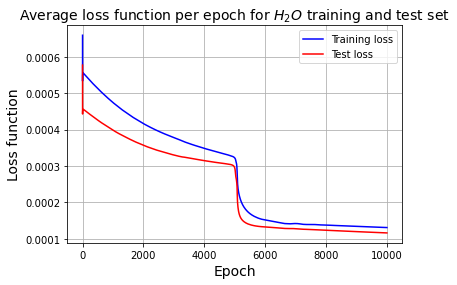

In [86]:
x = np.arange(1,nepochs+1)
# plt.plot(x[200:600],train_loss[200:600],'blue',label = 'Training loss')
# plt.plot(x[200:600],test_loss[200:600],'red',label = 'Test loss')

plt.plot(x,train_loss,'blue',label = 'Training loss')
plt.plot(x,test_loss,'red',label = 'Test loss')


plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Loss function',fontsize=14)
plt.title('Average loss function per epoch for $H_2O$ training and test set',fontsize=14)
plt.grid()
plt.legend()
plt.savefig('loss_graph_H2O',bbox_inches='tight')
plt.show()

In [87]:
print(np.shape(outputs))

torch.Size([25])


In [88]:
x1, x2, x3 = test_set[10]
x1 = x1
print(x1)

output = net(x1, x2, x3)
print('output')
print(output)

tensor([ -47.1594,    1.0143,   -9.9748, -152.5495,  -14.7487,  -46.0137])
output
tensor([-0.5233], grad_fn=<ViewBackward>)


In [62]:
prediction = np.zeros(100)
for i in range(100):
    x1,x2,x3 = test_set[i]
    prediction[i] = net(x1, x2, x3)#[0]


In [63]:
print(prediction)


[-0.39449394 -0.43876958 -0.14970091 -0.2935726  -0.28040391 -0.04252636
  0.14549816  0.13228619  0.0619418   0.165023   -0.52326703 -0.34717047
 -0.16945183 -0.39512146 -0.44773936 -0.02270567 -0.10893202  0.0594517
 -0.18801808 -0.58265406  0.46212658  0.0903115  -0.10745263  0.10530728
 -0.45679954  0.00692973 -0.39467382  0.06704348 -0.32021773  0.174999
  0.41301355  0.30131984  0.5254581  -0.31764966 -0.03770462 -0.35119539
 -0.38947809 -0.19033808  0.21049434 -0.41392529 -0.10909462 -0.48722917
  0.71778029 -0.19192252 -0.16375428  0.36614025 -0.24952948  0.08656663
 -0.01451069  0.09402567  0.02853614 -0.17060578 -0.19088206 -0.14725199
 -0.07894021  0.01897952 -0.48959041  0.25069535 -0.22690165 -0.52538651
  0.02568376 -0.26396513  0.2942099  -0.5443716  -0.01514822  0.10675865
 -0.16675508  0.38834447  0.78975075 -0.34744322 -0.11168471  0.03643739
  0.23510414  0.66500407  0.57429254  0.14857167 -0.0857341  -0.08562076
 -0.38817286 -0.3922087  -0.00335073 -0.24311799  0.08

In [89]:
print(np.shape(train_labels))
train_labels = np.array(train_labels)
print(np.mean(train_labels,axis=0))


torch.Size([900])
-2.6490954e-09


In [90]:
print(mean_lab)

-13813.419735561924


<ipython-input-91-6f7e39685aff>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction = torch.tensor(prediction)


tensor(-0.5827, dtype=torch.float64)


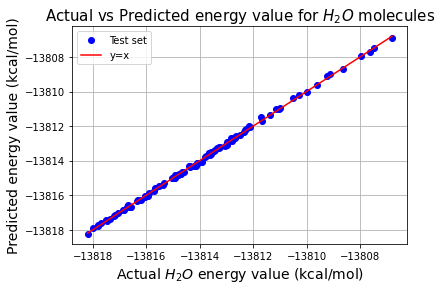

In [91]:
prediction = torch.tensor(prediction)

x = np.linspace(min(test_labels*var_lab+mean_lab), max(test_labels*var_lab+mean_lab))
print(min(torch.cat((test_labels,prediction),0)))
y = x
plt.plot(test_labels*var_lab+mean_lab,prediction*var_lab+mean_lab, 'o', color='blue', label = 'Test set')
plt.plot(x,y, color='red',label = 'y=x')
plt.grid()
#plt.xlim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction),0))])
#plt.ylim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction)))])
#plt.ylim([-13822,-13800])
#plt.ticklabel_format(axis="y", style="plain")
plt.ticklabel_format(useOffset=False, style='plain')
#plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Actual $H_2O$ energy value (kcal/mol)',fontsize=14)
plt.ylabel('Predicted energy value (kcal/mol)',fontsize=14)
plt.title('Actual vs Predicted energy value for $H_2O$ molecules',fontsize=15)
plt.legend()
plt.savefig('predicted_energies_H2O',bbox_inches='tight')
plt.show()


In [67]:
print(type(prediction))

<class 'torch.Tensor'>


In [92]:
print('layer 1')
print('weights')
print(net.network1.fc1.weight)
print('biases')
print(net.network1.fc1.bias)

print('layer 2')
print('weights')
print(net.network1.fc2.weight)
print('biases')
print(net.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[ 0.1078, -2.1293,  1.0789, -1.9747,  0.7509, -0.3952],
        [-0.0057, -0.3789,  0.0904, -0.0084, -0.2011,  0.0520],
        [ 0.1825, -0.9516,  0.0955,  0.0550, -0.1567, -0.4247]],
       requires_grad=True)
biases
Parameter containing:
tensor([-1.5346,  0.5168,  0.6036], requires_grad=True)
layer 2
weights
Parameter containing:
tensor([[ 0.4314,  0.5060,  0.0975],
        [-0.5579, -0.1841,  0.1814],
        [ 0.3654, -0.9840, -0.0291]], requires_grad=True)
biases
Parameter containing:
tensor([ 0.2431, -0.1241,  0.3054], requires_grad=True)


In [93]:
heta    = [0.01,  4.,    3.202, 1.606, 2.404, 0.808] 
zeta    = [8.,  1.6, 3.2, 4.8, 6.4, 0. ]
Rs      = [0.8, 0.4, 0.2, 1.,  0.,  0.6]
lambdaa = [1., 1., 1., 1., 1., 1.]

**<h2>Rotating test set molecules and checking performance**

**<h3>Rotation Matrix**

In [94]:
def random_rotation_matrix():
    theta = np.arccos(2*np.random.uniform(low = 0,high = 1)-1)
    phi = np.random.uniform(low = 0,high = 2*np.pi)
    u = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    theta = np.random.uniform(low = 0,high = 2*np.pi)
    A = np.zeros((3,3))
    A[0][0] = np.cos(theta) + (u[0]**2)*(1-np.cos(theta))
    A[0][1] = u[0]*u[1]*(1-np.cos(theta)) - u[2]*np.sin(theta)
    A[0][2] = u[0]*u[2]*(1-np.cos(theta)) + u[1]*np.sin(theta)
    A[1][0] = u[1]*u[0]*(1-np.cos(theta)) + u[2]*np.sin(theta)
    A[1][1] = np.cos(theta) + (u[1]**2)*(1-np.cos(theta))
    A[1][2] = u[1]*u[2]*(1-np.cos(theta)) - u[0]*np.sin(theta)
    A[2][0] = u[2]*u[0]*(1-np.cos(theta)) - u[1]*np.sin(theta)
    A[2][1] = u[2]*u[1]*(1-np.cos(theta)) + u[0]*np.sin(theta)
    A[2][2] = np.cos(theta) + (u[2]**2)*(1-np.cos(theta))
    return A

In [95]:
def rotate_data(A,data):
    data = np.array(data)
    m = np.shape(data)[1]
    for i in range(m):
        data[:,i] = np.matmul(A,data[:,i])
    return data

In [96]:
rotated_molec_coord = np.zeros((np.shape(coordinates)))
for i in range(data_size):
    coord = coordinates[N*i:N*(i+1),:]
    coord = np.transpose(coord)
    A = random_rotation_matrix()
    rotated_molec_coord[N*i:N*(i+1),:] = np.transpose(rotate_data(A,coord))


**<h3> Computing symmetry functions for rotated test set**

In [97]:
G_rot = np.zeros((len(coordinates), number_of_features))  # we have 3000x2 features (2 symm funcs for ech of the 3000 atoms in the dataset)
N=3
for i in range(data_size):
    coord = rotated_molec_coord[N*i:N*(i+1),:]
    Dp    = pairwise_distances(coord)
    for j in range(0,number_of_features,2):
        G_rot[N*i:N*(i+1),j]   = radial_BP_symm_func(Dp,N,heta[j],Rs[j]) 
        G_rot[N*i:N*(i+1),j+1] = angular_BP_symm_func(coord,Dp,N,heta[j],Rs[j],lambdaa[j],zeta[j])
    
# Computing variance and mean on the training data only!
G_rot_train = G_rot[:training_set_size,:]
var  = np.var(G_rot_train,axis=0)
mean = np.mean(G_rot_train,axis=0)

G_rot_norm = np.zeros((len(coordinates), number_of_features))
# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(G_rot)[0]):
    for j in range(np.shape(G_rot)[1]):
        G_rot_norm[i,j] = (G_rot[i,j]-mean[j])/var[j]   


data_set_rot = np.vsplit(G_rot_norm,data_size)     # Going from a (3000,2) np.array to a (1000,3,2) list
#data_set = np.random.permutation(training_set)
data_set_rot = torch.FloatTensor(data_set_rot)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor

    
    
# Splitting the dataset into training and test set
training_set_rot         = data_set_rot[:training_set_size]
test_set_rot             = data_set_rot[training_set_size:]


tensor(-0.5827, dtype=torch.float64)


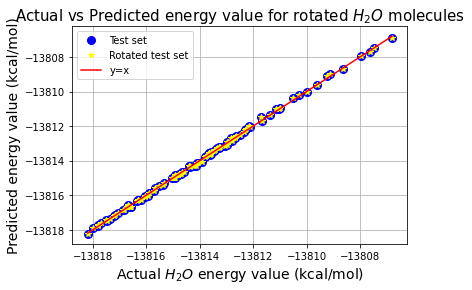

In [98]:
prediction_rotated = np.zeros(100)
for i in range(100):
    x1,x2,x3 = test_set_rot[i]
    prediction_rotated[i] = net(x1, x2, x3)#[0]


prediction_rotated = torch.tensor(prediction_rotated)

x = np.linspace(min(test_labels*var_lab+mean_lab), max(test_labels*var_lab+mean_lab))
print(min(torch.cat((test_labels,prediction_rotated),0)))
y = x
plt.plot(test_labels*var_lab+mean_lab,prediction*var_lab+mean_lab, 'o', color='blue', label = 'Test set',markersize=8)
plt.plot(test_labels*var_lab+mean_lab,prediction_rotated*var_lab+mean_lab, '*', color='yellow', label = 'Rotated test set')

plt.plot(x,y, color='red',label = 'y=x')
plt.grid()
#plt.xlim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction),0))])
#plt.ylim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction)))])
#plt.ylim([-13822,-13800])
#plt.ticklabel_format(axis="y", style="plain")
plt.ticklabel_format(useOffset=False, style='plain')
#plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Actual $H_2O$ energy value (kcal/mol)',fontsize=14)
plt.ylabel('Predicted energy value (kcal/mol)',fontsize=14)
plt.title('Actual vs Predicted energy value for rotated $H_2O$ molecules',fontsize=15)
plt.legend()
plt.savefig('rotated_predicted_energies_H2O',bbox_inches='tight')
plt.show()


**<h1>Training on xyz coordinates**

In [99]:
N                        = 3           # number of atoms per molecule
number_of_features_xyz   = 3         # number of features (symmetry functions) for each atom (we create one radial)
                                   # and one angular, but can create more by vaying the parameters η, λ, ζ, Rs etc.


data_size            = np.shape(energies)[0]        # We have 1000 water molecule conformations
training_set_size    = data_size - 100

    
# Computing variance and mean on the training data only!
coord_train = coordinates[:training_set_size,:]
var_train_xyz  = np.var(coord_train,axis=0)
mean_train_xyz = np.mean(coord_train,axis=0)


coordinates_norm = np.zeros((len(coordinates), number_of_features_xyz))
# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(coordinates)[0]):
    for j in range(1,np.shape(coordinates)[1]):  # omit first column since for our dataset x=0 always
        coordinates_norm[i,j] = (coordinates[i,j]-mean_train_xyz[j])/var_train_xyz[j]

data_set_xyz = np.vsplit(coordinates_norm,data_size)     # !!!!!!!!!!!!  change to coordinates_norm if you are normalising
data_set_xyz = torch.FloatTensor(data_set_xyz)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor


# labels same as before   
train_labels         = labels_norm[:training_set_size]
train_labels         = torch.FloatTensor(train_labels)
test_labels          = labels_norm[training_set_size:]
test_labels          = torch.FloatTensor(test_labels)

    
# Splitting the dataset into training and test set
training_set_xyz         = data_set_xyz[:training_set_size]
test_set_xyz             = data_set_xyz[training_set_size:]
#train and test labels same as before


#Dataset
dataset_xyz = TensorDataset(training_set_xyz, train_labels)

# Creating the batches
dataloader_xyz = torch.utils.data.DataLoader(dataset_xyz, batch_size=25, #300,
                                           shuffle=False, num_workers=2, drop_last=False) 


**<h2> New neural network architecture with xyz coordinates as input**

In [100]:
class Subnets_xyz(nn.Module):
    def __init__(self):
        super(Subnets_xyz, self).__init__()
        self.fc1 = nn.Linear(3, 2)        # where fc stands for fully connected 
        self.fc2 = nn.Linear(2, 2)
        self.fc3 = nn.Linear(2, 1)



    def forward(self, x,train = True):
        x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)                   # Using a linear function (identity function) for the subnet output layers
        return x

class BPNN_xyz(nn.Module):
    def __init__(self):
        super(BPNN_xyz, self).__init__()
        self.network1 = Subnets_xyz()
        self.network2 = Subnets_xyz()
        self.network3 = Subnets_xyz()
        
#        self.fc_out = nn.Linear(3, 1)      # should this be defined here, given that we are not trying to optimise
        
    def forward(self, x1, x2, x3,train = True):
        x1 = self.network1(x1)
        x2 = self.network2(x2)
        x3 = self.network3(x3)
        
        
        x = torch.cat((x1, x2, x3), 0) 
#        x = self.fc_out(x)
        x = torch.sum(x)                   #??????????????????????????? try average pooling?
        x = torch.reshape(x,[1])
        return x

    
model_xyz = BPNN_xyz()
x1, x2, x3 = training_set_xyz[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model_xyz(x1, x2, x3) * var_lab+mean_lab  # here we are adding the mean of the labels (around 13812) to a small number so the output will be close to the mean
print('output')
print(output)




x1 tensor([0.0000, 1.9344, 2.7473])
x2 tensor([ 0.0000, -1.8616,  2.0853])
x3 tensor([ 0.0000, -0.0496, -4.8916])
output
tensor([-13811.3350], grad_fn=<AddBackward0>)


**<h2>Training new neural net on xyz coordinates**

In [77]:
net_xyz = BPNN_xyz()

In [78]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net_xyz.parameters(), lr=0.0001)#0.005)
#torch.optim.LBFGS(net.parameters(), lr=0.001, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, line_search_fn=None)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.1)
nepochs = 10000

train_loss_xyz = np.zeros(nepochs)
test_loss_xyz = np.zeros(nepochs)

train_acc_xyz = np.zeros(nepochs)
test_acc_xyz = np.zeros(nepochs)

#===========================================================================
for epoch in range(nepochs):          # loop over the dataset multiple times
#===========================================================================
    
    running_loss_xyz = 0.0                #  Initialise losses at the start of each epoch 
    epoch_train_loss_xyz = 0.0             
    epoch_test_loss_xyz = 0.0
    
    
    counter = 0                               # ranges from 0 to the number of elements in each batch 
                                              # eg if we have 900 train. ex. and 25 batches, there will
                                              # be 36 elements in each batch.
    #---------------------------------------
    for i, data in enumerate(dataloader_xyz, 0):  # scan the whole dataset in each epoch, batch by batch (i ranges over batches)
    #---------------------------------------
        inputs, labels = data                 # get the inputs; data is a list of [inputs, labels]
        # zero the parameter gradients
        optimizer.zero_grad()                 # Calling .backward() mutiple times accumulates the gradient (by addition) 
                                              # for each parameter. This is why you should call optimizer.zero_grad() 
                                              # after each .step() call. 

        # forward + backward + optimize
        
        
        outputs = torch.zeros(np.shape(inputs)[0])
        for j in range(np.shape(inputs)[0]):
            outputs[j] = net_xyz(inputs[j][0],inputs[j][1],inputs[j][2])  # The net is designed to take a (3 x num_features)
            # tensor as an input, so when we are doing batch gd, we do a loop over all elements of the batch to create an
            # output vector with as many elements as the batch size. If our net was designed to take one row as input we 
            # wouldn't have needed the for loop, we could have had a vectorised implementation, i.e. outputs = net(inputs)
                       
            
        loss = criterion(outputs, labels) # a single value, same as loss.item(), which is the mean loss for each mini-batch
        loss.backward()                   # performs one back-propagation step 
        optimizer.step()                  # update the network parameters (perform an update step)

        # print statistics
        running_loss_xyz += loss.item()        # loss.item() contains loss of entire mini-batch, divided by the batch size, i.e. mean
                                           # we accumulate this loss over as many mini-batches as we like until we set it to zero after printing it
        epoch_train_loss_xyz += loss.item()    # cumulative loss for each epoch (sum of mean loss for all mini-batches)
                                           # so we ve divided here by the number of train. ex. in one mini-batch (mean)
                                           # thus all we need to do at the end of the epoch is divide by the number of mini-batches
        
        net_test_set_xyz = torch.zeros(np.shape(test_set_xyz)[0]) # outputs(predictions) of network if we input the test set
        with torch.no_grad():                             # The wrapper with torch.no_grad() temporarily sets all of 
                                                          # the requires_grad flags to false, i.e. makes all the 
                                                          # operations in the block have no gradients
            for k in range(np.shape(test_set_xyz)[0]):
                    net_test_set_xyz[k] = net_xyz(test_set_xyz[k][0],test_set_xyz[k][1],test_set_xyz[k][2])
            epoch_test_loss_xyz += criterion(net_test_set_xyz, test_labels).item() # sum test mean batch losses throughout epoch          
        if i % 10 == 0:    # print average loss every 10 mini-batches
            print('[%d, %5d] loss: %.10f' %
                  (epoch + 1, i + 1, running_loss_xyz/10))
            running_loss_xyz = 0.0
        counter += 1
        #------------------------------------       
    # Now we have added up the loss (both for training and test set) over all mini batches     
    train_loss_xyz[epoch] = epoch_train_loss_xyz/counter   # divide by number or training examples in one batch 
                                                           # to obtain average training loss for each epoch
#     if (abs((test_loss_xyz[epoch] - test_loss_xyz[epoch - 1])/test_loss_xyz[epoch - 1])< 0.1):
#         break
    test_loss_xyz[epoch] = epoch_test_loss_xyz/counter
    epoch_train_loss_xyz = 0.0
    epoch_test_loss_xyz = 0.0

#=================================================================================
    
print('Finished Training')

[1,     1] loss: 0.0156353325
[1,    11] loss: 0.2436201736
[1,    21] loss: 0.2533263490
[1,    31] loss: 0.2284467250
[2,     1] loss: 0.0135658607
[2,    11] loss: 0.2196936019
[2,    21] loss: 0.2312724978
[2,    31] loss: 0.2071457580
[3,     1] loss: 0.0118496150
[3,    11] loss: 0.1993668020
[3,    21] loss: 0.2126136929
[3,    31] loss: 0.1891557977
[4,     1] loss: 0.0104377888
[4,    11] loss: 0.1822440252
[4,    21] loss: 0.1970039815
[4,    31] loss: 0.1741234437
[5,     1] loss: 0.0092926003
[5,    11] loss: 0.1679540880
[5,    21] loss: 0.1840838194
[5,    31] loss: 0.1616995461
[6,     1] loss: 0.0083795652
[6,    11] loss: 0.1561611064
[6,    21] loss: 0.1735253364
[6,    31] loss: 0.1515623115
[7,     1] loss: 0.0076665476
[7,    11] loss: 0.1465502106
[7,    21] loss: 0.1650173575
[7,    31] loss: 0.1434047818
[8,     1] loss: 0.0071230076
[8,    11] loss: 0.1388207480
[8,    21] loss: 0.1582633831
[8,    31] loss: 0.1369354583
[9,     1] loss: 0.0067203045
[9,    11]

[67,    21] loss: 0.1373938724
[67,    31] loss: 0.1164562292
[68,     1] loss: 0.0060943004
[68,    11] loss: 0.1129039720
[68,    21] loss: 0.1373713873
[68,    31] loss: 0.1164274305
[69,     1] loss: 0.0060921017
[69,    11] loss: 0.1128829032
[69,    21] loss: 0.1373487115
[69,    31] loss: 0.1163983684
[70,     1] loss: 0.0060898829
[70,    11] loss: 0.1128616519
[70,    21] loss: 0.1373258516
[70,    31] loss: 0.1163690500
[71,     1] loss: 0.0060876440
[71,    11] loss: 0.1128402218
[71,    21] loss: 0.1373028234
[71,    31] loss: 0.1163394809
[72,     1] loss: 0.0060853869
[72,    11] loss: 0.1128186397
[72,    21] loss: 0.1372795969
[72,    31] loss: 0.1163096622
[73,     1] loss: 0.0060831085
[73,    11] loss: 0.1127968915
[73,    21] loss: 0.1372562148
[73,    31] loss: 0.1162796039
[74,     1] loss: 0.0060808096
[74,    11] loss: 0.1127750032
[74,    21] loss: 0.1372326531
[74,    31] loss: 0.1162493065
[75,     1] loss: 0.0060784914
[75,    11] loss: 0.1127529547
[75,    

[132,    31] loss: 0.1142915715
[133,     1] loss: 0.0059299923
[133,    11] loss: 0.1113754794
[133,    21] loss: 0.1357059687
[133,    31] loss: 0.1142576288
[134,     1] loss: 0.0059274916
[134,    11] loss: 0.1113524400
[134,    21] loss: 0.1356802754
[134,    31] loss: 0.1142237592
[135,     1] loss: 0.0059250001
[135,    11] loss: 0.1113294918
[135,    21] loss: 0.1356546566
[135,    31] loss: 0.1141899750
[136,     1] loss: 0.0059225198
[136,    11] loss: 0.1113066338
[136,    21] loss: 0.1356290914
[136,    31] loss: 0.1141562738
[137,     1] loss: 0.0059200488
[137,    11] loss: 0.1112838570
[137,    21] loss: 0.1356036022
[137,    31] loss: 0.1141226619
[138,     1] loss: 0.0059175868
[138,    11] loss: 0.1112611771
[138,    21] loss: 0.1355781876
[138,    31] loss: 0.1140891396
[139,     1] loss: 0.0059151396
[139,    11] loss: 0.1112385824
[139,    21] loss: 0.1355528466
[139,    31] loss: 0.1140557103
[140,     1] loss: 0.0059127036
[140,    11] loss: 0.1112160821
[140,   

[197,     1] loss: 0.0057964798
[197,    11] loss: 0.1101035021
[197,    21] loss: 0.1342332721
[197,    31] loss: 0.1123166125
[198,     1] loss: 0.0057948671
[198,    11] loss: 0.1100869469
[198,    21] loss: 0.1342131615
[198,    31] loss: 0.1122903243
[199,     1] loss: 0.0057932626
[199,    11] loss: 0.1100704864
[199,    21] loss: 0.1341931164
[199,    31] loss: 0.1122641642
[200,     1] loss: 0.0057916764
[200,    11] loss: 0.1100541189
[200,    21] loss: 0.1341731526
[200,    31] loss: 0.1122381266
[201,     1] loss: 0.0057901040
[201,    11] loss: 0.1100378368
[201,    21] loss: 0.1341532864
[201,    31] loss: 0.1122122087
[202,     1] loss: 0.0057885461
[202,    11] loss: 0.1100216370
[202,    21] loss: 0.1341334946
[202,    31] loss: 0.1121864166
[203,     1] loss: 0.0057870042
[203,    11] loss: 0.1100055430
[203,    21] loss: 0.1341137782
[203,    31] loss: 0.1121607430
[204,     1] loss: 0.0057854734
[204,    11] loss: 0.1099895291
[204,    21] loss: 0.1340941422
[204,   

[261,    11] loss: 0.1091990348
[261,    21] loss: 0.1330827884
[261,    31] loss: 0.1108527280
[262,     1] loss: 0.0057179745
[262,    11] loss: 0.1091868553
[262,    21] loss: 0.1330665343
[262,    31] loss: 0.1108328320
[263,     1] loss: 0.0057171248
[263,    11] loss: 0.1091747206
[263,    21] loss: 0.1330503173
[263,    31] loss: 0.1108130053
[264,     1] loss: 0.0057162829
[264,    11] loss: 0.1091626283
[264,    21] loss: 0.1330341369
[264,    31] loss: 0.1107932635
[265,     1] loss: 0.0057154499
[265,    11] loss: 0.1091505866
[265,    21] loss: 0.1330179989
[265,    31] loss: 0.1107735839
[266,     1] loss: 0.0057146255
[266,    11] loss: 0.1091385707
[266,    21] loss: 0.1330018856
[266,    31] loss: 0.1107539870
[267,     1] loss: 0.0057138085
[267,    11] loss: 0.1091266006
[267,    21] loss: 0.1329858191
[267,    31] loss: 0.1107344538
[268,     1] loss: 0.0057130028
[268,    11] loss: 0.1091146726
[268,    21] loss: 0.1329697914
[268,    31] loss: 0.1107149858
[269,   

[325,    21] loss: 0.1320978597
[325,    31] loss: 0.1096995119
[326,     1] loss: 0.0056777880
[326,    11] loss: 0.1084733475
[326,    21] loss: 0.1320830725
[326,    31] loss: 0.1096830081
[327,     1] loss: 0.0056773406
[327,    11] loss: 0.1084628828
[327,    21] loss: 0.1320682876
[327,    31] loss: 0.1096665323
[328,     1] loss: 0.0056768976
[328,    11] loss: 0.1084524434
[328,    21] loss: 0.1320535146
[328,    31] loss: 0.1096500963
[329,     1] loss: 0.0056764551
[329,    11] loss: 0.1084420405
[329,    21] loss: 0.1320387580
[329,    31] loss: 0.1096337009
[330,     1] loss: 0.0056760170
[330,    11] loss: 0.1084316351
[330,    21] loss: 0.1320240118
[330,    31] loss: 0.1096173245
[331,     1] loss: 0.0056755826
[331,    11] loss: 0.1084212475
[331,    21] loss: 0.1320092708
[331,    31] loss: 0.1096009947
[332,     1] loss: 0.0056751538
[332,    11] loss: 0.1084108565
[332,    21] loss: 0.1319945328
[332,    31] loss: 0.1095846828
[333,     1] loss: 0.0056747299
[333,   

[389,    31] loss: 0.1086993553
[390,     1] loss: 0.0056554977
[390,    11] loss: 0.1078239892
[390,    21] loss: 0.1311513677
[390,    31] loss: 0.1086844452
[391,     1] loss: 0.0056552287
[391,    11] loss: 0.1078140516
[391,    21] loss: 0.1311369404
[391,    31] loss: 0.1086695530
[392,     1] loss: 0.0056549616
[392,    11] loss: 0.1078041200
[392,    21] loss: 0.1311225452
[392,    31] loss: 0.1086546719
[393,     1] loss: 0.0056546949
[393,    11] loss: 0.1077942085
[393,    21] loss: 0.1311081342
[393,    31] loss: 0.1086398128
[394,     1] loss: 0.0056544300
[394,    11] loss: 0.1077843055
[394,    21] loss: 0.1310937271
[394,    31] loss: 0.1086249698
[395,     1] loss: 0.0056541670
[395,    11] loss: 0.1077743892
[395,    21] loss: 0.1310793176
[395,    31] loss: 0.1086101383
[396,     1] loss: 0.0056539070
[396,    11] loss: 0.1077644739
[396,    21] loss: 0.1310649216
[396,    31] loss: 0.1085953288
[397,     1] loss: 0.0056536470
[397,    11] loss: 0.1077545758
[397,   

[454,     1] loss: 0.0056411162
[454,    11] loss: 0.1071964532
[454,    21] loss: 0.1302337483
[454,    31] loss: 0.1077609386
[455,     1] loss: 0.0056409273
[455,    11] loss: 0.1071867675
[455,    21] loss: 0.1302194893
[455,    31] loss: 0.1077469196
[456,     1] loss: 0.0056407403
[456,    11] loss: 0.1071770862
[456,    21] loss: 0.1302052386
[456,    31] loss: 0.1077329289
[457,     1] loss: 0.0056405529
[457,    11] loss: 0.1071674097
[457,    21] loss: 0.1301909849
[457,    31] loss: 0.1077189483
[458,     1] loss: 0.0056403674
[458,    11] loss: 0.1071577314
[458,    21] loss: 0.1301767394
[458,    31] loss: 0.1077049717
[459,     1] loss: 0.0056401826
[459,    11] loss: 0.1071480665
[459,    21] loss: 0.1301624969
[459,    31] loss: 0.1076910052
[460,     1] loss: 0.0056399979
[460,    11] loss: 0.1071383994
[460,    21] loss: 0.1301482506
[460,    31] loss: 0.1076770589
[461,     1] loss: 0.0056398142
[461,    11] loss: 0.1071287472
[461,    21] loss: 0.1301340163
[461,   

[518,    11] loss: 0.1065844685
[518,    21] loss: 0.1293282136
[518,    31] loss: 0.1068866149
[519,     1] loss: 0.0056303624
[519,    11] loss: 0.1065750334
[519,    21] loss: 0.1293141991
[519,    31] loss: 0.1068732955
[520,     1] loss: 0.0056302167
[520,    11] loss: 0.1065656148
[520,    21] loss: 0.1293001853
[520,    31] loss: 0.1068599831
[521,     1] loss: 0.0056300711
[521,    11] loss: 0.1065561898
[521,    21] loss: 0.1292861722
[521,    31] loss: 0.1068466861
[522,     1] loss: 0.0056299262
[522,    11] loss: 0.1065467793
[522,    21] loss: 0.1292721681
[522,    31] loss: 0.1068334006
[523,     1] loss: 0.0056297801
[523,    11] loss: 0.1065373752
[523,    21] loss: 0.1292581685
[523,    31] loss: 0.1068201184
[524,     1] loss: 0.0056296367
[524,    11] loss: 0.1065279663
[524,    21] loss: 0.1292441629
[524,    31] loss: 0.1068068489
[525,     1] loss: 0.0056294940
[525,    11] loss: 0.1065185435
[525,    21] loss: 0.1292301729
[525,    31] loss: 0.1067936048
[526,   

[582,    21] loss: 0.1284404084
[582,    31] loss: 0.1060539365
[583,     1] loss: 0.0056219034
[583,    11] loss: 0.1059800636
[583,    21] loss: 0.1284266874
[583,    31] loss: 0.1060412236
[584,     1] loss: 0.0056217834
[584,    11] loss: 0.1059708960
[584,    21] loss: 0.1284129716
[584,    31] loss: 0.1060285289
[585,     1] loss: 0.0056216627
[585,    11] loss: 0.1059617318
[585,    21] loss: 0.1283992618
[585,    31] loss: 0.1060158372
[586,     1] loss: 0.0056215435
[586,    11] loss: 0.1059525765
[586,    21] loss: 0.1283855572
[586,    31] loss: 0.1060031462
[587,     1] loss: 0.0056214225
[587,    11] loss: 0.1059434302
[587,    21] loss: 0.1283718623
[587,    31] loss: 0.1059904777
[588,     1] loss: 0.0056213032
[588,    11] loss: 0.1059342898
[588,    21] loss: 0.1283581704
[588,    31] loss: 0.1059778094
[589,     1] loss: 0.0056211840
[589,    11] loss: 0.1059251487
[589,    21] loss: 0.1283444650
[589,    31] loss: 0.1059651420
[590,     1] loss: 0.0056210656
[590,   

[646,    31] loss: 0.1052559361
[647,     1] loss: 0.0056147229
[647,    11] loss: 0.1053997841
[647,    21] loss: 0.1275570236
[647,    31] loss: 0.1052436903
[648,     1] loss: 0.0056146182
[648,    11] loss: 0.1053907860
[648,    21] loss: 0.1275435381
[648,    31] loss: 0.1052314397
[649,     1] loss: 0.0056145135
[649,    11] loss: 0.1053818077
[649,    21] loss: 0.1275300585
[649,    31] loss: 0.1052191980
[650,     1] loss: 0.0056144096
[650,    11] loss: 0.1053728245
[650,    21] loss: 0.1275165804
[650,    31] loss: 0.1052069601
[651,     1] loss: 0.0056143034
[651,    11] loss: 0.1053638477
[651,    21] loss: 0.1275031045
[651,    31] loss: 0.1051947251
[652,     1] loss: 0.0056142002
[652,    11] loss: 0.1053548653
[652,    21] loss: 0.1274896272
[652,    31] loss: 0.1051824983
[653,     1] loss: 0.0056140944
[653,    11] loss: 0.1053458985
[653,    21] loss: 0.1274761572
[653,    31] loss: 0.1051702760
[654,     1] loss: 0.0056139901
[654,    11] loss: 0.1053369362
[654,   

[711,     1] loss: 0.0056082658
[711,    11] loss: 0.1048265181
[711,    21] loss: 0.1266958579
[711,    31] loss: 0.1044676036
[712,     1] loss: 0.0056081682
[712,    11] loss: 0.1048175506
[712,    21] loss: 0.1266823754
[712,    31] loss: 0.1044555508
[713,     1] loss: 0.0056080710
[713,    11] loss: 0.1048085853
[713,    21] loss: 0.1266689003
[713,    31] loss: 0.1044434931
[714,     1] loss: 0.0056079730
[714,    11] loss: 0.1047996104
[714,    21] loss: 0.1266554132
[714,    31] loss: 0.1044314343
[715,     1] loss: 0.0056078773
[715,    11] loss: 0.1047906451
[715,    21] loss: 0.1266419247
[715,    31] loss: 0.1044193789
[716,     1] loss: 0.0056077816
[716,    11] loss: 0.1047816638
[716,    21] loss: 0.1266284376
[716,    31] loss: 0.1044073261
[717,     1] loss: 0.0056076832
[717,    11] loss: 0.1047726959
[717,    21] loss: 0.1266149439
[717,    31] loss: 0.1043952778
[718,     1] loss: 0.0056075856
[718,    11] loss: 0.1047637384
[718,    21] loss: 0.1266014628
[718,   

[775,    11] loss: 0.1042465318
[775,    21] loss: 0.1258239076
[775,    31] loss: 0.1036923889
[776,     1] loss: 0.0056020051
[776,    11] loss: 0.1042372983
[776,    21] loss: 0.1258100554
[776,    31] loss: 0.1036801409
[777,     1] loss: 0.0056019079
[777,    11] loss: 0.1042280704
[777,    21] loss: 0.1257961951
[777,    31] loss: 0.1036678806
[778,     1] loss: 0.0056018118
[778,    11] loss: 0.1042188417
[778,    21] loss: 0.1257823162
[778,    31] loss: 0.1036556244
[779,     1] loss: 0.0056017149
[779,    11] loss: 0.1042096049
[779,    21] loss: 0.1257684395
[779,    31] loss: 0.1036433533
[780,     1] loss: 0.0056016196
[780,    11] loss: 0.1042003512
[780,    21] loss: 0.1257545352
[780,    31] loss: 0.1036310736
[781,     1] loss: 0.0056015231
[781,    11] loss: 0.1041910905
[781,    21] loss: 0.1257406324
[781,    31] loss: 0.1036187854
[782,     1] loss: 0.0056014270
[782,    11] loss: 0.1041818287
[782,    21] loss: 0.1257267170
[782,    31] loss: 0.1036065001
[783,   

[839,    21] loss: 0.1249104798
[839,    31] loss: 0.1028881922
[840,     1] loss: 0.0055956498
[840,    11] loss: 0.1036273636
[840,    21] loss: 0.1248956434
[840,    31] loss: 0.1028751817
[841,     1] loss: 0.0055955429
[841,    11] loss: 0.1036174230
[841,    21] loss: 0.1248807967
[841,    31] loss: 0.1028621599
[842,     1] loss: 0.0055954374
[842,    11] loss: 0.1036074653
[842,    21] loss: 0.1248659223
[842,    31] loss: 0.1028491069
[843,     1] loss: 0.0055953335
[843,    11] loss: 0.1035974823
[843,    21] loss: 0.1248510264
[843,    31] loss: 0.1028360464
[844,     1] loss: 0.0055952296
[844,    11] loss: 0.1035874918
[844,    21] loss: 0.1248361111
[844,    31] loss: 0.1028229561
[845,     1] loss: 0.0055951234
[845,    11] loss: 0.1035774834
[845,    21] loss: 0.1248211637
[845,    31] loss: 0.1028098654
[846,     1] loss: 0.0055950183
[846,    11] loss: 0.1035674505
[846,    21] loss: 0.1248062007
[846,    31] loss: 0.1027967457
[847,     1] loss: 0.0055949144
[847,   

[903,    31] loss: 0.1020102859
[904,     1] loss: 0.0055882879
[904,    11] loss: 0.1029492844
[904,    21] loss: 0.1238905035
[904,    31] loss: 0.1019956551
[905,     1] loss: 0.0055881575
[905,    11] loss: 0.1029378481
[905,    21] loss: 0.1238737069
[905,    31] loss: 0.1019810025
[906,     1] loss: 0.0055880278
[906,    11] loss: 0.1029263873
[906,    21] loss: 0.1238568768
[906,    31] loss: 0.1019663002
[907,     1] loss: 0.0055878974
[907,    11] loss: 0.1029148906
[907,    21] loss: 0.1238400064
[907,    31] loss: 0.1019515727
[908,     1] loss: 0.0055877656
[908,    11] loss: 0.1029033642
[908,    21] loss: 0.1238231026
[908,    31] loss: 0.1019368198
[909,     1] loss: 0.0055876311
[909,    11] loss: 0.1028917942
[909,    21] loss: 0.1238061495
[909,    31] loss: 0.1019220229
[910,     1] loss: 0.0055875000
[910,    11] loss: 0.1028802082
[910,    21] loss: 0.1237891622
[910,    31] loss: 0.1019071750
[911,     1] loss: 0.0055873677
[911,    11] loss: 0.1028685842
[911,   

[968,     1] loss: 0.0055785213
[968,    11] loss: 0.1021402888
[968,    21] loss: 0.1227193855
[968,    31] loss: 0.1009741914
[969,     1] loss: 0.0055783395
[969,    11] loss: 0.1021261614
[969,    21] loss: 0.1226992451
[969,    31] loss: 0.1009566493
[970,     1] loss: 0.0055781584
[970,    11] loss: 0.1021119636
[970,    21] loss: 0.1226790391
[970,    31] loss: 0.1009390425
[971,     1] loss: 0.0055779751
[971,    11] loss: 0.1020977184
[971,    21] loss: 0.1226587735
[971,    31] loss: 0.1009213775
[972,     1] loss: 0.0055777907
[972,    11] loss: 0.1020834208
[972,    21] loss: 0.1226384245
[972,    31] loss: 0.1009036638
[973,     1] loss: 0.0055776067
[973,    11] loss: 0.1020690739
[973,    21] loss: 0.1226180166
[973,    31] loss: 0.1008858901
[974,     1] loss: 0.0055774208
[974,    11] loss: 0.1020546708
[974,    21] loss: 0.1225975320
[974,    31] loss: 0.1008680508
[975,     1] loss: 0.0055772327
[975,    11] loss: 0.1020402271
[975,    21] loss: 0.1225769885
[975,   

[1031,    11] loss: 0.1011270281
[1031,    21] loss: 0.1213008776
[1031,    31] loss: 0.0997397617
[1032,     1] loss: 0.0055644795
[1032,    11] loss: 0.1011086036
[1032,    21] loss: 0.1212755404
[1032,    31] loss: 0.0997177489
[1033,     1] loss: 0.0055642128
[1033,    11] loss: 0.1010901004
[1033,    21] loss: 0.1212501146
[1033,    31] loss: 0.0996956524
[1034,     1] loss: 0.0055639453
[1034,    11] loss: 0.1010715116
[1034,    21] loss: 0.1212245919
[1034,    31] loss: 0.0996734746
[1035,     1] loss: 0.0055636782
[1035,    11] loss: 0.1010528456
[1035,    21] loss: 0.1211989619
[1035,    31] loss: 0.0996512033
[1036,     1] loss: 0.0055634074
[1036,    11] loss: 0.1010340843
[1036,    21] loss: 0.1211732425
[1036,    31] loss: 0.0996288422
[1037,     1] loss: 0.0055631362
[1037,    11] loss: 0.1010152578
[1037,    21] loss: 0.1211474001
[1037,    31] loss: 0.0996063903
[1038,     1] loss: 0.0055628624
[1038,    11] loss: 0.1009963423
[1038,    21] loss: 0.1211214729
[1038,    

[1093,    21] loss: 0.1195190072
[1093,    31] loss: 0.0981943186
[1094,     1] loss: 0.0055448152
[1094,    11] loss: 0.0997821350
[1094,    21] loss: 0.1194863692
[1094,    31] loss: 0.0981660899
[1095,     1] loss: 0.0055444393
[1095,    11] loss: 0.0997574270
[1095,    21] loss: 0.1194536030
[1095,    31] loss: 0.0981377464
[1096,     1] loss: 0.0055440653
[1096,    11] loss: 0.0997325972
[1096,    21] loss: 0.1194206871
[1096,    31] loss: 0.0981092956
[1097,     1] loss: 0.0055436905
[1097,    11] loss: 0.0997076605
[1097,    21] loss: 0.1193876550
[1097,    31] loss: 0.0980807215
[1098,     1] loss: 0.0055433124
[1098,    11] loss: 0.0996825967
[1098,    21] loss: 0.1193544678
[1098,    31] loss: 0.0980520342
[1099,     1] loss: 0.0055429339
[1099,    11] loss: 0.0996574279
[1099,    21] loss: 0.1193211585
[1099,    31] loss: 0.0980232269
[1100,     1] loss: 0.0055425506
[1100,    11] loss: 0.0996321522
[1100,    21] loss: 0.1192877039
[1100,    31] loss: 0.0979943130
[1101,    

[1155,    31] loss: 0.0962239597
[1156,     1] loss: 0.0055191327
[1156,    11] loss: 0.0980253544
[1156,    21] loss: 0.1171877757
[1156,    31] loss: 0.0961885430
[1157,     1] loss: 0.0055186976
[1157,    11] loss: 0.0979932670
[1157,    21] loss: 0.1171462044
[1157,    31] loss: 0.0961530201
[1158,     1] loss: 0.0055182621
[1158,    11] loss: 0.0979610700
[1158,    21] loss: 0.1171044923
[1158,    31] loss: 0.0961173896
[1159,     1] loss: 0.0055178288
[1159,    11] loss: 0.0979287595
[1159,    21] loss: 0.1170626387
[1159,    31] loss: 0.0960816439
[1160,     1] loss: 0.0055173926
[1160,    11] loss: 0.0978963528
[1160,    21] loss: 0.1170206435
[1160,    31] loss: 0.0960458089
[1161,     1] loss: 0.0055169605
[1161,    11] loss: 0.0978638213
[1161,    21] loss: 0.1169785149
[1161,    31] loss: 0.0960098453
[1162,     1] loss: 0.0055165257
[1162,    11] loss: 0.0978311926
[1162,    21] loss: 0.1169362381
[1162,    31] loss: 0.0959737904
[1163,     1] loss: 0.0055160929
[1163,    

[1218,     1] loss: 0.0054957274
[1218,    11] loss: 0.0958575673
[1218,    21] loss: 0.1143763170
[1218,    31] loss: 0.0938146275
[1219,     1] loss: 0.0054954715
[1219,    11] loss: 0.0958204374
[1219,    21] loss: 0.1143278152
[1219,    31] loss: 0.0937742453
[1220,     1] loss: 0.0054952197
[1220,    11] loss: 0.0957832709
[1220,    21] loss: 0.1142792307
[1220,    31] loss: 0.0937338326
[1221,     1] loss: 0.0054949746
[1221,    11] loss: 0.0957460754
[1221,    21] loss: 0.1142305739
[1221,    31] loss: 0.0936933778
[1222,     1] loss: 0.0054947410
[1222,    11] loss: 0.0957088239
[1222,    21] loss: 0.1141818635
[1222,    31] loss: 0.0936528981
[1223,     1] loss: 0.0054945093
[1223,    11] loss: 0.0956715528
[1223,    21] loss: 0.1141330786
[1223,    31] loss: 0.0936123926
[1224,     1] loss: 0.0054942809
[1224,    11] loss: 0.0956342902
[1224,    21] loss: 0.1140842371
[1224,    31] loss: 0.0935718499
[1225,     1] loss: 0.0054940626
[1225,    11] loss: 0.0955969676
[1225,    

[1280,    11] loss: 0.0935607437
[1280,    21] loss: 0.1113054857
[1280,    31] loss: 0.0913070757
[1281,     1] loss: 0.0054956399
[1281,    11] loss: 0.0935250051
[1281,    21] loss: 0.1112561032
[1281,    31] loss: 0.0912676167
[1282,     1] loss: 0.0054959651
[1282,    11] loss: 0.0934893426
[1282,    21] loss: 0.1112067655
[1282,    31] loss: 0.0912281934
[1283,     1] loss: 0.0054962989
[1283,    11] loss: 0.0934537765
[1283,    21] loss: 0.1111574665
[1283,    31] loss: 0.0911888521
[1284,     1] loss: 0.0054966446
[1284,    11] loss: 0.0934182957
[1284,    21] loss: 0.1111082047
[1284,    31] loss: 0.0911495786
[1285,     1] loss: 0.0054970026
[1285,    11] loss: 0.0933828969
[1285,    21] loss: 0.1110589959
[1285,    31] loss: 0.0911103614
[1286,     1] loss: 0.0054973718
[1286,    11] loss: 0.0933475640
[1286,    21] loss: 0.1110098377
[1286,    31] loss: 0.0910712086
[1287,     1] loss: 0.0054977570
[1287,    11] loss: 0.0933123253
[1287,    21] loss: 0.1109607190
[1287,    

[1342,    21] loss: 0.1083711088
[1342,    31] loss: 0.0890110638
[1343,     1] loss: 0.0055385839
[1343,    11] loss: 0.0915094383
[1343,    21] loss: 0.1083265662
[1343,    31] loss: 0.0889769644
[1344,     1] loss: 0.0055396579
[1344,    11] loss: 0.0914806962
[1344,    21] loss: 0.1082821056
[1344,    31] loss: 0.0889429782
[1345,     1] loss: 0.0055407405
[1345,    11] loss: 0.0914520930
[1345,    21] loss: 0.1082377680
[1345,    31] loss: 0.0889090955
[1346,     1] loss: 0.0055418335
[1346,    11] loss: 0.0914236214
[1346,    21] loss: 0.1081935339
[1346,    31] loss: 0.0888753209
[1347,     1] loss: 0.0055429414
[1347,    11] loss: 0.0913952585
[1347,    21] loss: 0.1081494033
[1347,    31] loss: 0.0888416372
[1348,     1] loss: 0.0055440608
[1348,    11] loss: 0.0913670260
[1348,    21] loss: 0.1081053935
[1348,    31] loss: 0.0888080634
[1349,     1] loss: 0.0055451889
[1349,    11] loss: 0.0913389567
[1349,    21] loss: 0.1080614686
[1349,    31] loss: 0.0887745995
[1350,    

[1404,    31] loss: 0.0870957963
[1405,     1] loss: 0.0056250259
[1405,    11] loss: 0.0899722502
[1405,    21] loss: 0.1057796918
[1405,    31] loss: 0.0870682381
[1406,     1] loss: 0.0056267165
[1406,    11] loss: 0.0899514258
[1406,    21] loss: 0.1057422005
[1406,    31] loss: 0.0870407961
[1407,     1] loss: 0.0056284171
[1407,    11] loss: 0.0899307452
[1407,    21] loss: 0.1057048246
[1407,    31] loss: 0.0870134640
[1408,     1] loss: 0.0056301206
[1408,    11] loss: 0.0899101827
[1408,    21] loss: 0.1056675725
[1408,    31] loss: 0.0869862247
[1409,     1] loss: 0.0056318339
[1409,    11] loss: 0.0898897279
[1409,    21] loss: 0.1056304432
[1409,    31] loss: 0.0869590942
[1410,     1] loss: 0.0056335568
[1410,    11] loss: 0.0898694035
[1410,    21] loss: 0.1055934250
[1410,    31] loss: 0.0869320869
[1411,     1] loss: 0.0056352843
[1411,    11] loss: 0.0898491781
[1411,    21] loss: 0.1055565163
[1411,    31] loss: 0.0869051669
[1412,     1] loss: 0.0056370229
[1412,    

[1467,     1] loss: 0.0057426024
[1467,    11] loss: 0.0888975415
[1467,    21] loss: 0.1036734350
[1467,    31] loss: 0.0855662115
[1468,     1] loss: 0.0057446703
[1468,    11] loss: 0.0888835493
[1468,    21] loss: 0.1036430366
[1468,    31] loss: 0.0855452478
[1469,     1] loss: 0.0057467375
[1469,    11] loss: 0.0888696626
[1469,    21] loss: 0.1036127523
[1469,    31] loss: 0.0855243854
[1470,     1] loss: 0.0057488181
[1470,    11] loss: 0.0888558615
[1470,    21] loss: 0.1035825789
[1470,    31] loss: 0.0855036285
[1471,     1] loss: 0.0057508964
[1471,    11] loss: 0.0888421673
[1471,    21] loss: 0.1035525158
[1471,    31] loss: 0.0854829777
[1472,     1] loss: 0.0057529774
[1472,    11] loss: 0.0888285652
[1472,    21] loss: 0.1035225525
[1472,    31] loss: 0.0854624249
[1473,     1] loss: 0.0057550635
[1473,    11] loss: 0.0888150547
[1473,    21] loss: 0.1034927130
[1473,    31] loss: 0.0854419634
[1474,     1] loss: 0.0057571549
[1474,    11] loss: 0.0888016470
[1474,    

[1529,    11] loss: 0.0881991714
[1529,    21] loss: 0.1019916892
[1529,    31] loss: 0.0844498783
[1530,     1] loss: 0.0058782235
[1530,    11] loss: 0.0881904524
[1530,    21] loss: 0.1019677989
[1530,    31] loss: 0.0844347645
[1531,     1] loss: 0.0058804240
[1531,    11] loss: 0.0881817892
[1531,    21] loss: 0.1019440122
[1531,    31] loss: 0.0844197266
[1532,     1] loss: 0.0058826212
[1532,    11] loss: 0.0881732117
[1532,    21] loss: 0.1019203156
[1532,    31] loss: 0.0844047803
[1533,     1] loss: 0.0058848217
[1533,    11] loss: 0.0881647166
[1533,    21] loss: 0.1018967159
[1533,    31] loss: 0.0843899224
[1534,     1] loss: 0.0058870252
[1534,    11] loss: 0.0881562524
[1534,    21] loss: 0.1018732250
[1534,    31] loss: 0.0843751460
[1535,     1] loss: 0.0058892231
[1535,    11] loss: 0.0881479014
[1535,    21] loss: 0.1018498182
[1535,    31] loss: 0.0843604468
[1536,     1] loss: 0.0058914203
[1536,    11] loss: 0.0881396007
[1536,    21] loss: 0.1018265069
[1536,    

[1591,    21] loss: 0.1006844617
[1591,    31] loss: 0.0836612985
[1592,     1] loss: 0.0060129687
[1592,    11] loss: 0.0877729796
[1592,    21] loss: 0.1006660528
[1592,    31] loss: 0.0836508311
[1593,     1] loss: 0.0060150839
[1593,    11] loss: 0.0877679721
[1593,    21] loss: 0.1006477691
[1593,    31] loss: 0.0836404424
[1594,     1] loss: 0.0060171980
[1594,    11] loss: 0.0877630074
[1594,    21] loss: 0.1006295331
[1594,    31] loss: 0.0836300924
[1595,     1] loss: 0.0060193080
[1595,    11] loss: 0.0877580680
[1595,    21] loss: 0.1006113902
[1595,    31] loss: 0.0836198188
[1596,     1] loss: 0.0060214128
[1596,    11] loss: 0.0877531979
[1596,    21] loss: 0.1005933240
[1596,    31] loss: 0.0836096145
[1597,     1] loss: 0.0060235158
[1597,    11] loss: 0.0877483699
[1597,    21] loss: 0.1005753368
[1597,    31] loss: 0.0835994523
[1598,     1] loss: 0.0060256194
[1598,    11] loss: 0.0877435859
[1598,    21] loss: 0.1005574293
[1598,    31] loss: 0.0835893828
[1599,    

[1653,    31] loss: 0.0831199460
[1654,     1] loss: 0.0061377015
[1654,    11] loss: 0.0875363111
[1654,    21] loss: 0.0996687643
[1654,    31] loss: 0.0831127886
[1655,     1] loss: 0.0061395846
[1655,    11] loss: 0.0875335183
[1655,    21] loss: 0.0996547632
[1655,    31] loss: 0.0831056684
[1656,     1] loss: 0.0061414652
[1656,    11] loss: 0.0875307627
[1656,    21] loss: 0.0996408328
[1656,    31] loss: 0.0830986030
[1657,     1] loss: 0.0061433446
[1657,    11] loss: 0.0875280045
[1657,    21] loss: 0.0996269591
[1657,    31] loss: 0.0830915794
[1658,     1] loss: 0.0061452217
[1658,    11] loss: 0.0875252917
[1658,    21] loss: 0.0996131584
[1658,    31] loss: 0.0830845926
[1659,     1] loss: 0.0061470877
[1659,    11] loss: 0.0875226106
[1659,    21] loss: 0.0995994046
[1659,    31] loss: 0.0830776587
[1660,     1] loss: 0.0061489500
[1660,    11] loss: 0.0875199586
[1660,    21] loss: 0.0995856993
[1660,    31] loss: 0.0830707535
[1661,     1] loss: 0.0061508108
[1661,    

[1716,     1] loss: 0.0062457547
[1716,    11] loss: 0.0874030311
[1716,    21] loss: 0.0989047468
[1716,    31] loss: 0.0827425994
[1717,     1] loss: 0.0062473398
[1717,    11] loss: 0.0874014061
[1717,    21] loss: 0.0988939799
[1717,    31] loss: 0.0827376395
[1718,     1] loss: 0.0062489249
[1718,    11] loss: 0.0873997837
[1718,    21] loss: 0.0988832496
[1718,    31] loss: 0.0827327225
[1719,     1] loss: 0.0062505066
[1719,    11] loss: 0.0873981770
[1719,    21] loss: 0.0988725580
[1719,    31] loss: 0.0827277891
[1720,     1] loss: 0.0062520765
[1720,    11] loss: 0.0873965699
[1720,    21] loss: 0.0988619328
[1720,    31] loss: 0.0827229206
[1721,     1] loss: 0.0062536463
[1721,    11] loss: 0.0873949986
[1721,    21] loss: 0.0988513432
[1721,    31] loss: 0.0827180687
[1722,     1] loss: 0.0062552080
[1722,    11] loss: 0.0873934180
[1722,    21] loss: 0.0988407880
[1722,    31] loss: 0.0827132389
[1723,     1] loss: 0.0062567681
[1723,    11] loss: 0.0873918593
[1723,    

[1778,    11] loss: 0.0873190332
[1778,    21] loss: 0.0983123586
[1778,    31] loss: 0.0824790906
[1779,     1] loss: 0.0063360281
[1779,    11] loss: 0.0873178944
[1779,    21] loss: 0.0983039215
[1779,    31] loss: 0.0824754443
[1780,     1] loss: 0.0063373044
[1780,    11] loss: 0.0873167306
[1780,    21] loss: 0.0982955232
[1780,    31] loss: 0.0824718367
[1781,     1] loss: 0.0063385792
[1781,    11] loss: 0.0873155870
[1781,    21] loss: 0.0982871696
[1781,    31] loss: 0.0824682422
[1782,     1] loss: 0.0063398458
[1782,    11] loss: 0.0873144321
[1782,    21] loss: 0.0982788257
[1782,    31] loss: 0.0824646518
[1783,     1] loss: 0.0063411020
[1783,    11] loss: 0.0873133175
[1783,    21] loss: 0.0982705243
[1783,    31] loss: 0.0824610975
[1784,     1] loss: 0.0063423537
[1784,    11] loss: 0.0873121642
[1784,    21] loss: 0.0982622601
[1784,    31] loss: 0.0824575491
[1785,     1] loss: 0.0063436039
[1785,    11] loss: 0.0873110291
[1785,    21] loss: 0.0982540101
[1785,    

[1840,    21] loss: 0.0978436835
[1840,    31] loss: 0.0822803162
[1841,     1] loss: 0.0064062864
[1841,    11] loss: 0.0872505397
[1841,    21] loss: 0.0978369199
[1841,    31] loss: 0.0822774656
[1842,     1] loss: 0.0064072803
[1842,    11] loss: 0.0872494798
[1842,    21] loss: 0.0978301950
[1842,    31] loss: 0.0822746404
[1843,     1] loss: 0.0064082712
[1843,    11] loss: 0.0872484129
[1843,    21] loss: 0.0978234954
[1843,    31] loss: 0.0822718211
[1844,     1] loss: 0.0064092539
[1844,    11] loss: 0.0872473486
[1844,    21] loss: 0.0978168070
[1844,    31] loss: 0.0822690133
[1845,     1] loss: 0.0064102322
[1845,    11] loss: 0.0872462951
[1845,    21] loss: 0.0978101470
[1845,    31] loss: 0.0822662264
[1846,     1] loss: 0.0064112075
[1846,    11] loss: 0.0872452240
[1846,    21] loss: 0.0978034988
[1846,    31] loss: 0.0822634377
[1847,     1] loss: 0.0064121768
[1847,    11] loss: 0.0872441616
[1847,    21] loss: 0.0977968842
[1847,    31] loss: 0.0822606649
[1848,    

[1902,    31] loss: 0.0821199547
[1903,     1] loss: 0.0064603038
[1903,    11] loss: 0.0871824898
[1903,    21] loss: 0.0974582799
[1903,    31] loss: 0.0821175851
[1904,     1] loss: 0.0064610556
[1904,    11] loss: 0.0871813342
[1904,    21] loss: 0.0974527493
[1904,    31] loss: 0.0821152180
[1905,     1] loss: 0.0064618051
[1905,    11] loss: 0.0871801820
[1905,    21] loss: 0.0974472418
[1905,    31] loss: 0.0821128614
[1906,     1] loss: 0.0064625464
[1906,    11] loss: 0.0871790335
[1906,    21] loss: 0.0974417366
[1906,    31] loss: 0.0821105178
[1907,     1] loss: 0.0064632937
[1907,    11] loss: 0.0871778708
[1907,    21] loss: 0.0974362664
[1907,    31] loss: 0.0821081746
[1908,     1] loss: 0.0064640328
[1908,    11] loss: 0.0871767104
[1908,    21] loss: 0.0974308014
[1908,    31] loss: 0.0821058393
[1909,     1] loss: 0.0064647682
[1909,    11] loss: 0.0871755406
[1909,    21] loss: 0.0974253446
[1909,    31] loss: 0.0821034886
[1910,     1] loss: 0.0064655021
[1910,    

[1965,     1] loss: 0.0065008409
[1965,    11] loss: 0.0871065732
[1965,    21] loss: 0.0971434720
[1965,    31] loss: 0.0819803007
[1966,     1] loss: 0.0065014035
[1966,    11] loss: 0.0871052690
[1966,    21] loss: 0.0971388079
[1966,    31] loss: 0.0819782171
[1967,     1] loss: 0.0065019600
[1967,    11] loss: 0.0871039540
[1967,    21] loss: 0.0971341647
[1967,    31] loss: 0.0819761291
[1968,     1] loss: 0.0065025121
[1968,    11] loss: 0.0871026419
[1968,    21] loss: 0.0971295424
[1968,    31] loss: 0.0819740452
[1969,     1] loss: 0.0065030612
[1969,    11] loss: 0.0871013317
[1969,    21] loss: 0.0971249193
[1969,    31] loss: 0.0819719788
[1970,     1] loss: 0.0065036066
[1970,    11] loss: 0.0871000368
[1970,    21] loss: 0.0971203141
[1970,    31] loss: 0.0819699153
[1971,     1] loss: 0.0065041497
[1971,    11] loss: 0.0870987125
[1971,    21] loss: 0.0971157148
[1971,    31] loss: 0.0819678426
[1972,     1] loss: 0.0065046936
[1972,    11] loss: 0.0870973829
[1972,    

[2027,    11] loss: 0.0870210160
[2027,    21] loss: 0.0968753442
[2027,    31] loss: 0.0818567757
[2028,     1] loss: 0.0065310434
[2028,    11] loss: 0.0870195664
[2028,    21] loss: 0.0968713343
[2028,    31] loss: 0.0818548780
[2029,     1] loss: 0.0065314434
[2029,    11] loss: 0.0870181210
[2029,    21] loss: 0.0968673252
[2029,    31] loss: 0.0818529658
[2030,     1] loss: 0.0065318473
[2030,    11] loss: 0.0870166685
[2030,    21] loss: 0.0968633138
[2030,    31] loss: 0.0818510707
[2031,     1] loss: 0.0065322474
[2031,    11] loss: 0.0870152008
[2031,    21] loss: 0.0968593389
[2031,    31] loss: 0.0818491641
[2032,     1] loss: 0.0065326445
[2032,    11] loss: 0.0870137241
[2032,    21] loss: 0.0968553551
[2032,    31] loss: 0.0818472624
[2033,     1] loss: 0.0065330416
[2033,    11] loss: 0.0870122634
[2033,    21] loss: 0.0968513869
[2033,    31] loss: 0.0818453744
[2034,     1] loss: 0.0065334380
[2034,    11] loss: 0.0870107893
[2034,    21] loss: 0.0968474261
[2034,    

[2089,    21] loss: 0.0966419309
[2089,    31] loss: 0.0817422412
[2090,     1] loss: 0.0065523885
[2090,    11] loss: 0.0869251724
[2090,    21] loss: 0.0966384023
[2090,    31] loss: 0.0817404535
[2091,     1] loss: 0.0065526746
[2091,    11] loss: 0.0869235922
[2091,    21] loss: 0.0966348693
[2091,    31] loss: 0.0817386594
[2092,     1] loss: 0.0065529630
[2092,    11] loss: 0.0869220063
[2092,    21] loss: 0.0966313578
[2092,    31] loss: 0.0817368817
[2093,     1] loss: 0.0065532476
[2093,    11] loss: 0.0869204145
[2093,    21] loss: 0.0966278411
[2093,    31] loss: 0.0817351013
[2094,     1] loss: 0.0065535299
[2094,    11] loss: 0.0869188353
[2094,    21] loss: 0.0966243505
[2094,    31] loss: 0.0817333210
[2095,     1] loss: 0.0065538131
[2095,    11] loss: 0.0869172320
[2095,    21] loss: 0.0966208532
[2095,    31] loss: 0.0817315280
[2096,     1] loss: 0.0065540932
[2096,    11] loss: 0.0869156271
[2096,    21] loss: 0.0966173604
[2096,    31] loss: 0.0817297589
[2097,    

[2151,    31] loss: 0.0816339400
[2152,     1] loss: 0.0065674365
[2152,    11] loss: 0.0868239082
[2152,    21] loss: 0.0964314915
[2152,    31] loss: 0.0816322349
[2153,     1] loss: 0.0065676384
[2153,    11] loss: 0.0868222207
[2153,    21] loss: 0.0964283407
[2153,    31] loss: 0.0816305257
[2154,     1] loss: 0.0065678366
[2154,    11] loss: 0.0868205436
[2154,    21] loss: 0.0964251839
[2154,    31] loss: 0.0816288292
[2155,     1] loss: 0.0065680325
[2155,    11] loss: 0.0868188567
[2155,    21] loss: 0.0964220494
[2155,    31] loss: 0.0816271201
[2156,     1] loss: 0.0065682299
[2156,    11] loss: 0.0868171647
[2156,    21] loss: 0.0964188956
[2156,    31] loss: 0.0816254251
[2157,     1] loss: 0.0065684192
[2157,    11] loss: 0.0868154958
[2157,    21] loss: 0.0964157566
[2157,    31] loss: 0.0816237289
[2158,     1] loss: 0.0065686144
[2158,    11] loss: 0.0868137892
[2158,    21] loss: 0.0964126334
[2158,    31] loss: 0.0816220321
[2159,     1] loss: 0.0065688059
[2159,    

[2214,     1] loss: 0.0065777496
[2214,    11] loss: 0.0867177904
[2214,    21] loss: 0.0962447114
[2214,    31] loss: 0.0815287963
[2215,     1] loss: 0.0065778829
[2215,    11] loss: 0.0867160644
[2215,    21] loss: 0.0962418370
[2215,    31] loss: 0.0815271597
[2216,     1] loss: 0.0065780185
[2216,    11] loss: 0.0867143184
[2216,    21] loss: 0.0962389693
[2216,    31] loss: 0.0815255292
[2217,     1] loss: 0.0065781519
[2217,    11] loss: 0.0867125753
[2217,    21] loss: 0.0962360993
[2217,    31] loss: 0.0815238986
[2218,     1] loss: 0.0065782860
[2218,    11] loss: 0.0867108334
[2218,    21] loss: 0.0962332413
[2218,    31] loss: 0.0815222617
[2219,     1] loss: 0.0065784171
[2219,    11] loss: 0.0867090918
[2219,    21] loss: 0.0962303862
[2219,    31] loss: 0.0815206211
[2220,     1] loss: 0.0065785483
[2220,    11] loss: 0.0867073566
[2220,    21] loss: 0.0962275296
[2220,    31] loss: 0.0815190032
[2221,     1] loss: 0.0065786749
[2221,    11] loss: 0.0867056169
[2221,    

[2276,    11] loss: 0.0866089847
[2276,    21] loss: 0.0960735954
[2276,    31] loss: 0.0814293895
[2277,     1] loss: 0.0065846987
[2277,    11] loss: 0.0866072197
[2277,    21] loss: 0.0960709482
[2277,    31] loss: 0.0814278074
[2278,     1] loss: 0.0065847866
[2278,    11] loss: 0.0866054580
[2278,    21] loss: 0.0960682996
[2278,    31] loss: 0.0814262379
[2279,     1] loss: 0.0065848708
[2279,    11] loss: 0.0866036884
[2279,    21] loss: 0.0960656673
[2279,    31] loss: 0.0814246651
[2280,     1] loss: 0.0065849587
[2280,    11] loss: 0.0866019215
[2280,    21] loss: 0.0960630193
[2280,    31] loss: 0.0814230990
[2281,     1] loss: 0.0065850407
[2281,    11] loss: 0.0866001461
[2281,    21] loss: 0.0960603766
[2281,    31] loss: 0.0814215310
[2282,     1] loss: 0.0065851286
[2282,    11] loss: 0.0865983762
[2282,    21] loss: 0.0960577533
[2282,    31] loss: 0.0814199694
[2283,     1] loss: 0.0065852135
[2283,    11] loss: 0.0865966212
[2283,    21] loss: 0.0960551158
[2283,    

[2338,    21] loss: 0.0959148042
[2338,    31] loss: 0.0813335583
[2339,     1] loss: 0.0065890767
[2339,    11] loss: 0.0864973634
[2339,    21] loss: 0.0959123306
[2339,    31] loss: 0.0813320443
[2340,     1] loss: 0.0065891303
[2340,    11] loss: 0.0864955988
[2340,    21] loss: 0.0959098659
[2340,    31] loss: 0.0813305397
[2341,     1] loss: 0.0065891832
[2341,    11] loss: 0.0864938095
[2341,    21] loss: 0.0959073953
[2341,    31] loss: 0.0813290082
[2342,     1] loss: 0.0065892361
[2342,    11] loss: 0.0864920311
[2342,    21] loss: 0.0959049337
[2342,    31] loss: 0.0813274909
[2343,     1] loss: 0.0065892883
[2343,    11] loss: 0.0864902411
[2343,    21] loss: 0.0959024757
[2343,    31] loss: 0.0813259732
[2344,     1] loss: 0.0065893389
[2344,    11] loss: 0.0864884842
[2344,    21] loss: 0.0959000170
[2344,    31] loss: 0.0813244682
[2345,     1] loss: 0.0065893896
[2345,    11] loss: 0.0864866994
[2345,    21] loss: 0.0958975576
[2345,    31] loss: 0.0813229553
[2346,    

[2400,    31] loss: 0.0812410079
[2401,     1] loss: 0.0065916948
[2401,    11] loss: 0.0863876645
[2401,    21] loss: 0.0957636394
[2401,    31] loss: 0.0812395379
[2402,     1] loss: 0.0065917283
[2402,    11] loss: 0.0863859113
[2402,    21] loss: 0.0957613096
[2402,    31] loss: 0.0812380746
[2403,     1] loss: 0.0065917589
[2403,    11] loss: 0.0863841422
[2403,    21] loss: 0.0957589895
[2403,    31] loss: 0.0812366132
[2404,     1] loss: 0.0065917879
[2404,    11] loss: 0.0863823883
[2404,    21] loss: 0.0957566634
[2404,    31] loss: 0.0812351517
[2405,     1] loss: 0.0065918177
[2405,    11] loss: 0.0863806285
[2405,    21] loss: 0.0957543358
[2405,    31] loss: 0.0812336832
[2406,     1] loss: 0.0065918483
[2406,    11] loss: 0.0863788657
[2406,    21] loss: 0.0957520090
[2406,    31] loss: 0.0812322196
[2407,     1] loss: 0.0065918811
[2407,    11] loss: 0.0863771133
[2407,    21] loss: 0.0957496911
[2407,    31] loss: 0.0812307589
[2408,     1] loss: 0.0065919094
[2408,    

[2463,     1] loss: 0.0065931581
[2463,    11] loss: 0.0862791620
[2463,    21] loss: 0.0956228010
[2463,    31] loss: 0.0811500307
[2464,     1] loss: 0.0065931804
[2464,    11] loss: 0.0862774234
[2464,    21] loss: 0.0956205875
[2464,    31] loss: 0.0811486110
[2465,     1] loss: 0.0065931976
[2465,    11] loss: 0.0862756941
[2465,    21] loss: 0.0956183866
[2465,    31] loss: 0.0811471928
[2466,     1] loss: 0.0065932125
[2466,    11] loss: 0.0862739637
[2466,    21] loss: 0.0956161693
[2466,    31] loss: 0.0811457776
[2467,     1] loss: 0.0065932266
[2467,    11] loss: 0.0862722311
[2467,    21] loss: 0.0956139468
[2467,    31] loss: 0.0811443608
[2468,     1] loss: 0.0065932423
[2468,    11] loss: 0.0862704992
[2468,    21] loss: 0.0956117466
[2468,    31] loss: 0.0811429322
[2469,     1] loss: 0.0065932572
[2469,    11] loss: 0.0862687677
[2469,    21] loss: 0.0956095368
[2469,    31] loss: 0.0811415270
[2470,     1] loss: 0.0065932728
[2470,    11] loss: 0.0862670340
[2470,    

[2525,    11] loss: 0.0861724995
[2525,    21] loss: 0.0954885133
[2525,    31] loss: 0.0810633756
[2526,     1] loss: 0.0065938316
[2526,    11] loss: 0.0861707818
[2526,    21] loss: 0.0954863906
[2526,    31] loss: 0.0810620066
[2527,     1] loss: 0.0065938368
[2527,    11] loss: 0.0861690782
[2527,    21] loss: 0.0954842828
[2527,    31] loss: 0.0810606249
[2528,     1] loss: 0.0065938443
[2528,    11] loss: 0.0861673817
[2528,    21] loss: 0.0954821579
[2528,    31] loss: 0.0810592618
[2529,     1] loss: 0.0065938458
[2529,    11] loss: 0.0861656714
[2529,    21] loss: 0.0954800405
[2529,    31] loss: 0.0810578935
[2530,     1] loss: 0.0065938517
[2530,    11] loss: 0.0861639686
[2530,    21] loss: 0.0954779349
[2530,    31] loss: 0.0810565233
[2531,     1] loss: 0.0065938637
[2531,    11] loss: 0.0861622710
[2531,    21] loss: 0.0954758242
[2531,    31] loss: 0.0810551479
[2532,     1] loss: 0.0065938674
[2532,    11] loss: 0.0861605685
[2532,    21] loss: 0.0954737052
[2532,    

[2587,    21] loss: 0.0953596056
[2587,    31] loss: 0.0809794553
[2588,     1] loss: 0.0065940239
[2588,    11] loss: 0.0860664625
[2588,    21] loss: 0.0953575633
[2588,    31] loss: 0.0809781242
[2589,     1] loss: 0.0065940231
[2589,    11] loss: 0.0860648081
[2589,    21] loss: 0.0953555264
[2589,    31] loss: 0.0809767954
[2590,     1] loss: 0.0065940231
[2590,    11] loss: 0.0860631276
[2590,    21] loss: 0.0953535013
[2590,    31] loss: 0.0809754558
[2591,     1] loss: 0.0065940209
[2591,    11] loss: 0.0860614706
[2591,    21] loss: 0.0953514688
[2591,    31] loss: 0.0809741288
[2592,     1] loss: 0.0065940216
[2592,    11] loss: 0.0860598214
[2592,    21] loss: 0.0953494273
[2592,    31] loss: 0.0809727948
[2593,     1] loss: 0.0065940201
[2593,    11] loss: 0.0860581566
[2593,    21] loss: 0.0953473963
[2593,    31] loss: 0.0809714578
[2594,     1] loss: 0.0065940179
[2594,    11] loss: 0.0860564962
[2594,    21] loss: 0.0953453764
[2594,    31] loss: 0.0809701372
[2595,    

[2649,    31] loss: 0.0808980215
[2650,     1] loss: 0.0065939859
[2650,    11] loss: 0.0859648950
[2650,    21] loss: 0.0952331662
[2650,    31] loss: 0.0808967408
[2651,     1] loss: 0.0065939836
[2651,    11] loss: 0.0859632846
[2651,    21] loss: 0.0952311918
[2651,    31] loss: 0.0808954429
[2652,     1] loss: 0.0065939814
[2652,    11] loss: 0.0859616760
[2652,    21] loss: 0.0952292249
[2652,    31] loss: 0.0808941551
[2653,     1] loss: 0.0065939769
[2653,    11] loss: 0.0859600641
[2653,    21] loss: 0.0952272482
[2653,    31] loss: 0.0808928672
[2654,     1] loss: 0.0065939739
[2654,    11] loss: 0.0859584376
[2654,    21] loss: 0.0952252768
[2654,    31] loss: 0.0808915682
[2655,     1] loss: 0.0065939732
[2655,    11] loss: 0.0859568339
[2655,    21] loss: 0.0952233128
[2655,    31] loss: 0.0808902964
[2656,     1] loss: 0.0065939687
[2656,    11] loss: 0.0859552119
[2656,    21] loss: 0.0952213474
[2656,    31] loss: 0.0808890048
[2657,     1] loss: 0.0065939672
[2657,    

[2712,     1] loss: 0.0065937981
[2712,    11] loss: 0.0858660255
[2712,    21] loss: 0.0951126538
[2712,    31] loss: 0.0808177516
[2713,     1] loss: 0.0065937959
[2713,    11] loss: 0.0858644586
[2713,    21] loss: 0.0951107547
[2713,    31] loss: 0.0808164965
[2714,     1] loss: 0.0065937899
[2714,    11] loss: 0.0858628672
[2714,    21] loss: 0.0951088399
[2714,    31] loss: 0.0808152314
[2715,     1] loss: 0.0065937847
[2715,    11] loss: 0.0858613040
[2715,    21] loss: 0.0951069295
[2715,    31] loss: 0.0808139883
[2716,     1] loss: 0.0065937862
[2716,    11] loss: 0.0858597260
[2716,    21] loss: 0.0951050229
[2716,    31] loss: 0.0808127344
[2717,     1] loss: 0.0065937810
[2717,    11] loss: 0.0858581632
[2717,    21] loss: 0.0951031052
[2717,    31] loss: 0.0808114864
[2718,     1] loss: 0.0065937787
[2718,    11] loss: 0.0858565893
[2718,    21] loss: 0.0951012008
[2718,    31] loss: 0.0808102399
[2719,     1] loss: 0.0065937757
[2719,    11] loss: 0.0858550210
[2719,    

[2774,    11] loss: 0.0857700836
[2774,    21] loss: 0.0949952669
[2774,    31] loss: 0.0807409365
[2775,     1] loss: 0.0065936640
[2775,    11] loss: 0.0857685622
[2775,    21] loss: 0.0949934013
[2775,    31] loss: 0.0807397209
[2776,     1] loss: 0.0065936610
[2776,    11] loss: 0.0857670337
[2776,    21] loss: 0.0949915335
[2776,    31] loss: 0.0807384949
[2777,     1] loss: 0.0065936595
[2777,    11] loss: 0.0857655164
[2777,    21] loss: 0.0949896589
[2777,    31] loss: 0.0807372741
[2778,     1] loss: 0.0065936610
[2778,    11] loss: 0.0857639953
[2778,    21] loss: 0.0949878015
[2778,    31] loss: 0.0807360578
[2779,     1] loss: 0.0065936558
[2779,    11] loss: 0.0857624732
[2779,    21] loss: 0.0949859291
[2779,    31] loss: 0.0807348330
[2780,     1] loss: 0.0065936558
[2780,    11] loss: 0.0857609536
[2780,    21] loss: 0.0949840829
[2780,    31] loss: 0.0807336308
[2781,     1] loss: 0.0065936528
[2781,    11] loss: 0.0857594218
[2781,    21] loss: 0.0949822061
[2781,    

[2836,    21] loss: 0.0948808938
[2836,    31] loss: 0.0806662768
[2837,     1] loss: 0.0065935254
[2837,    11] loss: 0.0856752802
[2837,    21] loss: 0.0948790677
[2837,    31] loss: 0.0806650989
[2838,     1] loss: 0.0065935232
[2838,    11] loss: 0.0856737889
[2838,    21] loss: 0.0948772408
[2838,    31] loss: 0.0806639083
[2839,     1] loss: 0.0065935194
[2839,    11] loss: 0.0856723074
[2839,    21] loss: 0.0948754162
[2839,    31] loss: 0.0806627162
[2840,     1] loss: 0.0065935165
[2840,    11] loss: 0.0856708281
[2840,    21] loss: 0.0948736072
[2840,    31] loss: 0.0806615382
[2841,     1] loss: 0.0065935150
[2841,    11] loss: 0.0856693458
[2841,    21] loss: 0.0948717825
[2841,    31] loss: 0.0806603413
[2842,     1] loss: 0.0065935142
[2842,    11] loss: 0.0856678672
[2842,    21] loss: 0.0948699571
[2842,    31] loss: 0.0806591552
[2843,     1] loss: 0.0065935157
[2843,    11] loss: 0.0856663849
[2843,    21] loss: 0.0948681332
[2843,    31] loss: 0.0806579646
[2844,    

[2898,    31] loss: 0.0805934235
[2899,     1] loss: 0.0065935075
[2899,    11] loss: 0.0855847724
[2899,    21] loss: 0.0947671160
[2899,    31] loss: 0.0805922680
[2900,     1] loss: 0.0065935105
[2900,    11] loss: 0.0855833236
[2900,    21] loss: 0.0947653286
[2900,    31] loss: 0.0805911142
[2901,     1] loss: 0.0065935113
[2901,    11] loss: 0.0855818875
[2901,    21] loss: 0.0947635405
[2901,    31] loss: 0.0805899639
[2902,     1] loss: 0.0065935113
[2902,    11] loss: 0.0855804514
[2902,    21] loss: 0.0947617620
[2902,    31] loss: 0.0805887807
[2903,     1] loss: 0.0065935142
[2903,    11] loss: 0.0855790146
[2903,    21] loss: 0.0947599769
[2903,    31] loss: 0.0805876292
[2904,     1] loss: 0.0065935127
[2904,    11] loss: 0.0855775807
[2904,    21] loss: 0.0947581880
[2904,    31] loss: 0.0805864688
[2905,     1] loss: 0.0065935165
[2905,    11] loss: 0.0855761513
[2905,    21] loss: 0.0947564229
[2905,    31] loss: 0.0805853110
[2906,     1] loss: 0.0065935142
[2906,    

[2961,     1] loss: 0.0065936185
[2961,    11] loss: 0.0854969032
[2961,    21] loss: 0.0946574032
[2961,    31] loss: 0.0805212863
[2962,     1] loss: 0.0065936223
[2962,    11] loss: 0.0854955010
[2962,    21] loss: 0.0946556471
[2962,    31] loss: 0.0805201460
[2963,     1] loss: 0.0065936267
[2963,    11] loss: 0.0854941078
[2963,    21] loss: 0.0946538977
[2963,    31] loss: 0.0805190396
[2964,     1] loss: 0.0065936282
[2964,    11] loss: 0.0854927197
[2964,    21] loss: 0.0946521454
[2964,    31] loss: 0.0805179007
[2965,     1] loss: 0.0065936327
[2965,    11] loss: 0.0854913283
[2965,    21] loss: 0.0946503840
[2965,    31] loss: 0.0805167802
[2966,     1] loss: 0.0065936387
[2966,    11] loss: 0.0854899414
[2966,    21] loss: 0.0946486309
[2966,    31] loss: 0.0805156454
[2967,     1] loss: 0.0065936401
[2967,    11] loss: 0.0854885451
[2967,    21] loss: 0.0946468800
[2967,    31] loss: 0.0805145252
[2968,     1] loss: 0.0065936454
[2968,    11] loss: 0.0854871564
[2968,    

[3023,    11] loss: 0.0854115967
[3023,    21] loss: 0.0945495293
[3023,    31] loss: 0.0804519754
[3024,     1] loss: 0.0065939181
[3024,    11] loss: 0.0854102511
[3024,    21] loss: 0.0945477962
[3024,    31] loss: 0.0804508638
[3025,     1] loss: 0.0065939263
[3025,    11] loss: 0.0854088899
[3025,    21] loss: 0.0945460744
[3025,    31] loss: 0.0804497585
[3026,     1] loss: 0.0065939300
[3026,    11] loss: 0.0854075305
[3026,    21] loss: 0.0945443541
[3026,    31] loss: 0.0804486658
[3027,     1] loss: 0.0065939367
[3027,    11] loss: 0.0854061715
[3027,    21] loss: 0.0945426300
[3027,    31] loss: 0.0804475643
[3028,     1] loss: 0.0065939426
[3028,    11] loss: 0.0854048125
[3028,    21] loss: 0.0945409127
[3028,    31] loss: 0.0804464668
[3029,     1] loss: 0.0065939493
[3029,    11] loss: 0.0854034681
[3029,    21] loss: 0.0945391975
[3029,    31] loss: 0.0804453474
[3030,     1] loss: 0.0065939538
[3030,    11] loss: 0.0854021009
[3030,    21] loss: 0.0945374638
[3030,    

[3085,    21] loss: 0.0944434039
[3085,    31] loss: 0.0803841371
[3086,     1] loss: 0.0065943435
[3086,    11] loss: 0.0853272296
[3086,    21] loss: 0.0944417000
[3086,    31] loss: 0.0803830542
[3087,     1] loss: 0.0065943502
[3087,    11] loss: 0.0853259102
[3087,    21] loss: 0.0944400080
[3087,    31] loss: 0.0803819731
[3088,     1] loss: 0.0065943569
[3088,    11] loss: 0.0853245806
[3088,    21] loss: 0.0944383167
[3088,    31] loss: 0.0803808950
[3089,     1] loss: 0.0065943629
[3089,    11] loss: 0.0853232585
[3089,    21] loss: 0.0944366165
[3089,    31] loss: 0.0803798094
[3090,     1] loss: 0.0065943696
[3090,    11] loss: 0.0853219494
[3090,    21] loss: 0.0944349222
[3090,    31] loss: 0.0803787276
[3091,     1] loss: 0.0065943778
[3091,    11] loss: 0.0853206202
[3091,    21] loss: 0.0944332279
[3091,    31] loss: 0.0803776473
[3092,     1] loss: 0.0065943852
[3092,    11] loss: 0.0853192981
[3092,    21] loss: 0.0944315352
[3092,    31] loss: 0.0803765737
[3093,    

[3147,    31] loss: 0.0803177025
[3148,     1] loss: 0.0065948576
[3148,    11] loss: 0.0852463380
[3148,    21] loss: 0.0943373851
[3148,    31] loss: 0.0803166430
[3149,     1] loss: 0.0065948665
[3149,    11] loss: 0.0852450542
[3149,    21] loss: 0.0943357058
[3149,    31] loss: 0.0803155769
[3150,     1] loss: 0.0065948799
[3150,    11] loss: 0.0852437813
[3150,    21] loss: 0.0943340346
[3150,    31] loss: 0.0803145263
[3151,     1] loss: 0.0065948889
[3151,    11] loss: 0.0852424908
[3151,    21] loss: 0.0943323635
[3151,    31] loss: 0.0803134609
[3152,     1] loss: 0.0065948971
[3152,    11] loss: 0.0852412097
[3152,    21] loss: 0.0943306923
[3152,    31] loss: 0.0803123914
[3153,     1] loss: 0.0065949090
[3153,    11] loss: 0.0852399167
[3153,    21] loss: 0.0943290301
[3153,    31] loss: 0.0803113438
[3154,     1] loss: 0.0065949194
[3154,    11] loss: 0.0852386273
[3154,    21] loss: 0.0943273507
[3154,    31] loss: 0.0803102866
[3155,     1] loss: 0.0065949291
[3155,    

[3210,     1] loss: 0.0065955505
[3210,    11] loss: 0.0851675551
[3210,    21] loss: 0.0942344069
[3210,    31] loss: 0.0802516270
[3211,     1] loss: 0.0065955624
[3211,    11] loss: 0.0851663005
[3211,    21] loss: 0.0942327462
[3211,    31] loss: 0.0802505866
[3212,     1] loss: 0.0065955736
[3212,    11] loss: 0.0851650402
[3212,    21] loss: 0.0942311123
[3212,    31] loss: 0.0802495532
[3213,     1] loss: 0.0065955855
[3213,    11] loss: 0.0851637866
[3213,    21] loss: 0.0942294545
[3213,    31] loss: 0.0802485023
[3214,     1] loss: 0.0065956026
[3214,    11] loss: 0.0851625383
[3214,    21] loss: 0.0942278020
[3214,    31] loss: 0.0802474681
[3215,     1] loss: 0.0065956146
[3215,    11] loss: 0.0851612840
[3215,    21] loss: 0.0942261562
[3215,    31] loss: 0.0802464269
[3216,     1] loss: 0.0065956272
[3216,    11] loss: 0.0851600412
[3216,    21] loss: 0.0942245156
[3216,    31] loss: 0.0802453864
[3217,     1] loss: 0.0065956384
[3217,    11] loss: 0.0851587962
[3217,    

[3272,    11] loss: 0.0850905560
[3272,    21] loss: 0.0941329457
[3272,    31] loss: 0.0801878132
[3273,     1] loss: 0.0065963261
[3273,    11] loss: 0.0850893375
[3273,    21] loss: 0.0941313304
[3273,    31] loss: 0.0801867887
[3274,     1] loss: 0.0065963380
[3274,    11] loss: 0.0850881070
[3274,    21] loss: 0.0941297010
[3274,    31] loss: 0.0801857717
[3275,     1] loss: 0.0065963529
[3275,    11] loss: 0.0850868780
[3275,    21] loss: 0.0941280819
[3275,    31] loss: 0.0801847555
[3276,     1] loss: 0.0065963633
[3276,    11] loss: 0.0850856598
[3276,    21] loss: 0.0941264510
[3276,    31] loss: 0.0801837388
[3277,     1] loss: 0.0065963790
[3277,    11] loss: 0.0850844357
[3277,    21] loss: 0.0941248417
[3277,    31] loss: 0.0801827163
[3278,     1] loss: 0.0065963939
[3278,    11] loss: 0.0850832123
[3278,    21] loss: 0.0941232093
[3278,    31] loss: 0.0801816974
[3279,     1] loss: 0.0065964058
[3279,    11] loss: 0.0850819960
[3279,    21] loss: 0.0941215873
[3279,    

[3334,    21] loss: 0.0940327778
[3334,    31] loss: 0.0801251583
[3335,     1] loss: 0.0065972470
[3335,    11] loss: 0.0850143764
[3335,    21] loss: 0.0940311670
[3335,    31] loss: 0.0801241528
[3336,     1] loss: 0.0065972626
[3336,    11] loss: 0.0850131817
[3336,    21] loss: 0.0940295599
[3336,    31] loss: 0.0801231511
[3337,     1] loss: 0.0065972783
[3337,    11] loss: 0.0850119825
[3337,    21] loss: 0.0940279506
[3337,    31] loss: 0.0801221654
[3338,     1] loss: 0.0065972932
[3338,    11] loss: 0.0850108091
[3338,    21] loss: 0.0940263450
[3338,    31] loss: 0.0801211555
[3339,     1] loss: 0.0065973073
[3339,    11] loss: 0.0850095969
[3339,    21] loss: 0.0940247320
[3339,    31] loss: 0.0801201552
[3340,     1] loss: 0.0065973200
[3340,    11] loss: 0.0850084160
[3340,    21] loss: 0.0940231360
[3340,    31] loss: 0.0801191609
[3341,     1] loss: 0.0065973356
[3341,    11] loss: 0.0850072049
[3341,    21] loss: 0.0940215454
[3341,    31] loss: 0.0801181622
[3342,    

[3396,    31] loss: 0.0800635315
[3397,     1] loss: 0.0065981723
[3397,    11] loss: 0.0849408410
[3397,    21] loss: 0.0939323619
[3397,    31] loss: 0.0800625503
[3398,     1] loss: 0.0065981880
[3398,    11] loss: 0.0849396653
[3398,    21] loss: 0.0939307809
[3398,    31] loss: 0.0800615579
[3399,     1] loss: 0.0065982014
[3399,    11] loss: 0.0849385038
[3399,    21] loss: 0.0939292043
[3399,    31] loss: 0.0800605647
[3400,     1] loss: 0.0065982170
[3400,    11] loss: 0.0849373166
[3400,    21] loss: 0.0939276136
[3400,    31] loss: 0.0800595939
[3401,     1] loss: 0.0065982312
[3401,    11] loss: 0.0849361379
[3401,    21] loss: 0.0939260289
[3401,    31] loss: 0.0800586045
[3402,     1] loss: 0.0065982468
[3402,    11] loss: 0.0849349633
[3402,    21] loss: 0.0939244628
[3402,    31] loss: 0.0800576143
[3403,     1] loss: 0.0065982625
[3403,    11] loss: 0.0849337865
[3403,    21] loss: 0.0939228736
[3403,    31] loss: 0.0800566290
[3404,     1] loss: 0.0065982766
[3404,    

[3459,     1] loss: 0.0065991275
[3459,    11] loss: 0.0848686535
[3459,    21] loss: 0.0938347504
[3459,    31] loss: 0.0800017841
[3460,     1] loss: 0.0065991431
[3460,    11] loss: 0.0848674912
[3460,    21] loss: 0.0938331842
[3460,    31] loss: 0.0800008018
[3461,     1] loss: 0.0065991580
[3461,    11] loss: 0.0848663457
[3461,    21] loss: 0.0938316159
[3461,    31] loss: 0.0799998295
[3462,     1] loss: 0.0065991752
[3462,    11] loss: 0.0848651905
[3462,    21] loss: 0.0938300446
[3462,    31] loss: 0.0799988553
[3463,     1] loss: 0.0065991931
[3463,    11] loss: 0.0848640397
[3463,    21] loss: 0.0938284822
[3463,    31] loss: 0.0799978748
[3464,     1] loss: 0.0065992087
[3464,    11] loss: 0.0848628920
[3464,    21] loss: 0.0938269079
[3464,    31] loss: 0.0799969152
[3465,     1] loss: 0.0065992258
[3465,    11] loss: 0.0848617338
[3465,    21] loss: 0.0938253410
[3465,    31] loss: 0.0799959403
[3466,     1] loss: 0.0065992408
[3466,    11] loss: 0.0848605879
[3466,    

[3521,    11] loss: 0.0847975481
[3521,    21] loss: 0.0937382616
[3521,    31] loss: 0.0799418394
[3522,     1] loss: 0.0066000991
[3522,    11] loss: 0.0847964156
[3522,    21] loss: 0.0937367119
[3522,    31] loss: 0.0799408887
[3523,     1] loss: 0.0066001162
[3523,    11] loss: 0.0847952738
[3523,    21] loss: 0.0937351778
[3523,    31] loss: 0.0799399171
[3524,     1] loss: 0.0066001326
[3524,    11] loss: 0.0847941380
[3524,    21] loss: 0.0937336378
[3524,    31] loss: 0.0799389608
[3525,     1] loss: 0.0066001460
[3525,    11] loss: 0.0847930055
[3525,    21] loss: 0.0937320650
[3525,    31] loss: 0.0799380045
[3526,     1] loss: 0.0066001646
[3526,    11] loss: 0.0847918633
[3526,    21] loss: 0.0937305249
[3526,    31] loss: 0.0799370423
[3527,     1] loss: 0.0066001765
[3527,    11] loss: 0.0847907294
[3527,    21] loss: 0.0937289812
[3527,    31] loss: 0.0799360789
[3528,     1] loss: 0.0066001959
[3528,    11] loss: 0.0847895924
[3528,    21] loss: 0.0937274277
[3528,    

[3583,    21] loss: 0.0936427519
[3583,    31] loss: 0.0798826687
[3584,     1] loss: 0.0066011153
[3584,    11] loss: 0.0847266875
[3584,    21] loss: 0.0936412074
[3584,    31] loss: 0.0798817173
[3585,     1] loss: 0.0066011347
[3585,    11] loss: 0.0847255722
[3585,    21] loss: 0.0936396778
[3585,    31] loss: 0.0798807632
[3586,     1] loss: 0.0066011488
[3586,    11] loss: 0.0847244564
[3586,    21] loss: 0.0936381467
[3586,    31] loss: 0.0798798099
[3587,     1] loss: 0.0066011652
[3587,    11] loss: 0.0847233437
[3587,    21] loss: 0.0936366133
[3587,    31] loss: 0.0798788778
[3588,     1] loss: 0.0066011846
[3588,    11] loss: 0.0847222257
[3588,    21] loss: 0.0936350875
[3588,    31] loss: 0.0798779238
[3589,     1] loss: 0.0066012017
[3589,    11] loss: 0.0847211115
[3589,    21] loss: 0.0936335556
[3589,    31] loss: 0.0798769891
[3590,     1] loss: 0.0066012174
[3590,    11] loss: 0.0847199991
[3590,    21] loss: 0.0936320156
[3590,    31] loss: 0.0798760373
[3591,    

[3645,    31] loss: 0.0798242602
[3646,     1] loss: 0.0066021301
[3646,    11] loss: 0.0846579511
[3646,    21] loss: 0.0935467340
[3646,    31] loss: 0.0798233192
[3647,     1] loss: 0.0066021487
[3647,    11] loss: 0.0846568529
[3647,    21] loss: 0.0935452282
[3647,    31] loss: 0.0798223846
[3648,     1] loss: 0.0066021636
[3648,    11] loss: 0.0846557535
[3648,    21] loss: 0.0935437120
[3648,    31] loss: 0.0798214432
[3649,     1] loss: 0.0066021837
[3649,    11] loss: 0.0846546475
[3649,    21] loss: 0.0935421966
[3649,    31] loss: 0.0798205141
[3650,     1] loss: 0.0066021979
[3650,    11] loss: 0.0846535448
[3650,    21] loss: 0.0935406797
[3650,    31] loss: 0.0798195854
[3651,     1] loss: 0.0066022128
[3651,    11] loss: 0.0846524410
[3651,    21] loss: 0.0935391739
[3651,    31] loss: 0.0798186369
[3652,     1] loss: 0.0066022322
[3652,    11] loss: 0.0846513584
[3652,    21] loss: 0.0935376614
[3652,    31] loss: 0.0798177157
[3653,     1] loss: 0.0066022463
[3653,    

[3708,     1] loss: 0.0066031784
[3708,    11] loss: 0.0845902819
[3708,    21] loss: 0.0934531376
[3708,    31] loss: 0.0797655955
[3709,     1] loss: 0.0066031933
[3709,    11] loss: 0.0845891967
[3709,    21] loss: 0.0934516326
[3709,    31] loss: 0.0797646545
[3710,     1] loss: 0.0066032104
[3710,    11] loss: 0.0845881060
[3710,    21] loss: 0.0934501521
[3710,    31] loss: 0.0797637336
[3711,     1] loss: 0.0066032246
[3711,    11] loss: 0.0845870234
[3711,    21] loss: 0.0934486523
[3711,    31] loss: 0.0797628112
[3712,     1] loss: 0.0066032410
[3712,    11] loss: 0.0845859315
[3712,    21] loss: 0.0934471473
[3712,    31] loss: 0.0797618873
[3713,     1] loss: 0.0066032566
[3713,    11] loss: 0.0845848426
[3713,    21] loss: 0.0934456490
[3713,    31] loss: 0.0797609638
[3714,     1] loss: 0.0066032723
[3714,    11] loss: 0.0845837623
[3714,    21] loss: 0.0934441589
[3714,    31] loss: 0.0797600303
[3715,     1] loss: 0.0066032864
[3715,    11] loss: 0.0845826801
[3715,    

[3770,    11] loss: 0.0845234834
[3770,    21] loss: 0.0933605053
[3770,    31] loss: 0.0797084510
[3771,     1] loss: 0.0066042140
[3771,    11] loss: 0.0845224041
[3771,    21] loss: 0.0933590181
[3771,    31] loss: 0.0797075301
[3772,     1] loss: 0.0066042326
[3772,    11] loss: 0.0845213462
[3772,    21] loss: 0.0933575213
[3772,    31] loss: 0.0797066115
[3773,     1] loss: 0.0066042490
[3773,    11] loss: 0.0845202763
[3773,    21] loss: 0.0933560297
[3773,    31] loss: 0.0797056984
[3774,     1] loss: 0.0066042677
[3774,    11] loss: 0.0845192131
[3774,    21] loss: 0.0933545396
[3774,    31] loss: 0.0797047846
[3775,     1] loss: 0.0066042863
[3775,    11] loss: 0.0845181391
[3775,    21] loss: 0.0933530480
[3775,    31] loss: 0.0797038648
[3776,     1] loss: 0.0066043049
[3776,    11] loss: 0.0845170841
[3776,    21] loss: 0.0933515467
[3776,    31] loss: 0.0797029465
[3777,     1] loss: 0.0066043198
[3777,    11] loss: 0.0845160186
[3777,    21] loss: 0.0933500633
[3777,    

[3832,    21] loss: 0.0932686307
[3832,    31] loss: 0.0796519943
[3833,     1] loss: 0.0066052891
[3833,    11] loss: 0.0844566438
[3833,    21] loss: 0.0932671629
[3833,    31] loss: 0.0796510756
[3834,     1] loss: 0.0066053070
[3834,    11] loss: 0.0844555896
[3834,    21] loss: 0.0932656772
[3834,    31] loss: 0.0796501763
[3835,     1] loss: 0.0066053227
[3835,    11] loss: 0.0844545387
[3835,    21] loss: 0.0932642005
[3835,    31] loss: 0.0796492759
[3836,     1] loss: 0.0066053383
[3836,    11] loss: 0.0844534945
[3836,    21] loss: 0.0932627246
[3836,    31] loss: 0.0796483684
[3837,     1] loss: 0.0066053540
[3837,    11] loss: 0.0844524272
[3837,    21] loss: 0.0932612546
[3837,    31] loss: 0.0796474699
[3838,     1] loss: 0.0066053696
[3838,    11] loss: 0.0844513793
[3838,    21] loss: 0.0932597727
[3838,    31] loss: 0.0796465572
[3839,     1] loss: 0.0066053875
[3839,    11] loss: 0.0844503183
[3839,    21] loss: 0.0932583094
[3839,    31] loss: 0.0796456512
[3840,    

[3894,    31] loss: 0.0795960594
[3895,     1] loss: 0.0066063568
[3895,    11] loss: 0.0843916975
[3895,    21] loss: 0.0931761198
[3895,    31] loss: 0.0795951679
[3896,     1] loss: 0.0066063769
[3896,    11] loss: 0.0843906514
[3896,    21] loss: 0.0931746617
[3896,    31] loss: 0.0795942780
[3897,     1] loss: 0.0066063948
[3897,    11] loss: 0.0843896106
[3897,    21] loss: 0.0931731969
[3897,    31] loss: 0.0795933716
[3898,     1] loss: 0.0066064112
[3898,    11] loss: 0.0843885634
[3898,    21] loss: 0.0931717366
[3898,    31] loss: 0.0795924861
[3899,     1] loss: 0.0066064313
[3899,    11] loss: 0.0843875315
[3899,    21] loss: 0.0931702755
[3899,    31] loss: 0.0795915876
[3900,     1] loss: 0.0066064492
[3900,    11] loss: 0.0843864836
[3900,    21] loss: 0.0931688048
[3900,    31] loss: 0.0795906890
[3901,     1] loss: 0.0066064663
[3901,    11] loss: 0.0843854573
[3901,    21] loss: 0.0931673452
[3901,    31] loss: 0.0795897931
[3902,     1] loss: 0.0066064842
[3902,    

[3957,     1] loss: 0.0066075012
[3957,    11] loss: 0.0843276847
[3957,    21] loss: 0.0930856712
[3957,    31] loss: 0.0795398198
[3958,     1] loss: 0.0066075176
[3958,    11] loss: 0.0843266603
[3958,    21] loss: 0.0930842154
[3958,    31] loss: 0.0795389365
[3959,     1] loss: 0.0066075370
[3959,    11] loss: 0.0843256209
[3959,    21] loss: 0.0930827580
[3959,    31] loss: 0.0795380518
[3960,     1] loss: 0.0066075549
[3960,    11] loss: 0.0843246002
[3960,    21] loss: 0.0930813052
[3960,    31] loss: 0.0795371663
[3961,     1] loss: 0.0066075742
[3961,    11] loss: 0.0843235653
[3961,    21] loss: 0.0930798657
[3961,    31] loss: 0.0795362711
[3962,     1] loss: 0.0066075899
[3962,    11] loss: 0.0843225483
[3962,    21] loss: 0.0930784158
[3962,    31] loss: 0.0795353886
[3963,     1] loss: 0.0066076092
[3963,    11] loss: 0.0843215112
[3963,    21] loss: 0.0930769607
[3963,    31] loss: 0.0795345031
[3964,     1] loss: 0.0066076271
[3964,    11] loss: 0.0843204815
[3964,    

[4019,    11] loss: 0.0842643060
[4019,    21] loss: 0.0929960296
[4019,    31] loss: 0.0794849765
[4020,     1] loss: 0.0066086158
[4020,    11] loss: 0.0842633009
[4020,    21] loss: 0.0929945804
[4020,    31] loss: 0.0794840865
[4021,     1] loss: 0.0066086315
[4021,    11] loss: 0.0842622884
[4021,    21] loss: 0.0929931514
[4021,    31] loss: 0.0794832129
[4022,     1] loss: 0.0066086501
[4022,    11] loss: 0.0842612669
[4022,    21] loss: 0.0929917105
[4022,    31] loss: 0.0794823326
[4023,     1] loss: 0.0066086672
[4023,    11] loss: 0.0842602517
[4023,    21] loss: 0.0929902695
[4023,    31] loss: 0.0794814613
[4024,     1] loss: 0.0066086859
[4024,    11] loss: 0.0842592474
[4024,    21] loss: 0.0929888219
[4024,    31] loss: 0.0794805799
[4025,     1] loss: 0.0066087037
[4025,    11] loss: 0.0842582189
[4025,    21] loss: 0.0929873899
[4025,    31] loss: 0.0794796921
[4026,     1] loss: 0.0066087253
[4026,    11] loss: 0.0842572067
[4026,    21] loss: 0.0929859400
[4026,    

[4081,    21] loss: 0.0929070756
[4081,    31] loss: 0.0794306032
[4082,     1] loss: 0.0066097356
[4082,    11] loss: 0.0842006750
[4082,    21] loss: 0.0929056406
[4082,    31] loss: 0.0794297367
[4083,     1] loss: 0.0066097535
[4083,    11] loss: 0.0841996774
[4083,    21] loss: 0.0929042190
[4083,    31] loss: 0.0794288691
[4084,     1] loss: 0.0066097714
[4084,    11] loss: 0.0841986638
[4084,    21] loss: 0.0929027788
[4084,    31] loss: 0.0794279899
[4085,     1] loss: 0.0066097893
[4085,    11] loss: 0.0841976516
[4085,    21] loss: 0.0929013558
[4085,    31] loss: 0.0794271208
[4086,     1] loss: 0.0066098064
[4086,    11] loss: 0.0841966499
[4086,    21] loss: 0.0928999342
[4086,    31] loss: 0.0794262458
[4087,     1] loss: 0.0066098236
[4087,    11] loss: 0.0841956459
[4087,    21] loss: 0.0928984955
[4087,    31] loss: 0.0794253837
[4088,     1] loss: 0.0066098459
[4088,    11] loss: 0.0841946457
[4088,    21] loss: 0.0928970732
[4088,    31] loss: 0.0794245049
[4089,    

[4143,    31] loss: 0.0793767020
[4144,     1] loss: 0.0066108249
[4144,    11] loss: 0.0841386862
[4144,    21] loss: 0.0928174332
[4144,    31] loss: 0.0793758366
[4145,     1] loss: 0.0066108458
[4145,    11] loss: 0.0841376886
[4145,    21] loss: 0.0928160101
[4145,    31] loss: 0.0793749660
[4146,     1] loss: 0.0066108651
[4146,    11] loss: 0.0841366932
[4146,    21] loss: 0.0928145893
[4146,    31] loss: 0.0793741167
[4147,     1] loss: 0.0066108845
[4147,    11] loss: 0.0841357134
[4147,    21] loss: 0.0928131625
[4147,    31] loss: 0.0793732401
[4148,     1] loss: 0.0066109031
[4148,    11] loss: 0.0841347273
[4148,    21] loss: 0.0928117551
[4148,    31] loss: 0.0793723699
[4149,     1] loss: 0.0066109166
[4149,    11] loss: 0.0841337331
[4149,    21] loss: 0.0928103372
[4149,    31] loss: 0.0793715071
[4150,     1] loss: 0.0066109389
[4150,    11] loss: 0.0841327492
[4150,    21] loss: 0.0928089112
[4150,    31] loss: 0.0793706506
[4151,     1] loss: 0.0066109598
[4151,    

[4206,     1] loss: 0.0066120081
[4206,    11] loss: 0.0840775643
[4206,    21] loss: 0.0927296765
[4206,    31] loss: 0.0793224007
[4207,     1] loss: 0.0066120267
[4207,    11] loss: 0.0840765830
[4207,    21] loss: 0.0927282564
[4207,    31] loss: 0.0793215364
[4208,     1] loss: 0.0066120468
[4208,    11] loss: 0.0840755947
[4208,    21] loss: 0.0927268542
[4208,    31] loss: 0.0793206804
[4209,     1] loss: 0.0066120625
[4209,    11] loss: 0.0840746231
[4209,    21] loss: 0.0927254446
[4209,    31] loss: 0.0793198232
[4210,     1] loss: 0.0066120811
[4210,    11] loss: 0.0840736382
[4210,    21] loss: 0.0927240364
[4210,    31] loss: 0.0793189649
[4211,     1] loss: 0.0066121012
[4211,    11] loss: 0.0840726681
[4211,    21] loss: 0.0927226163
[4211,    31] loss: 0.0793180961
[4212,     1] loss: 0.0066121221
[4212,    11] loss: 0.0840716854
[4212,    21] loss: 0.0927212149
[4212,    31] loss: 0.0793172512
[4213,     1] loss: 0.0066121414
[4213,    11] loss: 0.0840707049
[4213,    

[4268,    11] loss: 0.0840168096
[4268,    21] loss: 0.0926426120
[4268,    31] loss: 0.0792693816
[4269,     1] loss: 0.0066131383
[4269,    11] loss: 0.0840158314
[4269,    21] loss: 0.0926412120
[4269,    31] loss: 0.0792685233
[4270,     1] loss: 0.0066131607
[4270,    11] loss: 0.0840148717
[4270,    21] loss: 0.0926398136
[4270,    31] loss: 0.0792676728
[4271,     1] loss: 0.0066131800
[4271,    11] loss: 0.0840138920
[4271,    21] loss: 0.0926384076
[4271,    31] loss: 0.0792668249
[4272,     1] loss: 0.0066131972
[4272,    11] loss: 0.0840129260
[4272,    21] loss: 0.0926370010
[4272,    31] loss: 0.0792659689
[4273,     1] loss: 0.0066132165
[4273,    11] loss: 0.0840119667
[4273,    21] loss: 0.0926355988
[4273,    31] loss: 0.0792651296
[4274,     1] loss: 0.0066132382
[4274,    11] loss: 0.0840109807
[4274,    21] loss: 0.0926342085
[4274,    31] loss: 0.0792642754
[4275,     1] loss: 0.0066132568
[4275,    11] loss: 0.0840100203
[4275,    21] loss: 0.0926328041
[4275,    

[4330,    21] loss: 0.0925560169
[4330,    31] loss: 0.0792167556
[4331,     1] loss: 0.0066143274
[4331,    11] loss: 0.0839559577
[4331,    21] loss: 0.0925546177
[4331,    31] loss: 0.0792159047
[4332,     1] loss: 0.0066143505
[4332,    11] loss: 0.0839549884
[4332,    21] loss: 0.0925532214
[4332,    31] loss: 0.0792150538
[4333,     1] loss: 0.0066143662
[4333,    11] loss: 0.0839540239
[4333,    21] loss: 0.0925518312
[4333,    31] loss: 0.0792142168
[4334,     1] loss: 0.0066143848
[4334,    11] loss: 0.0839530502
[4334,    21] loss: 0.0925504409
[4334,    31] loss: 0.0792133659
[4335,     1] loss: 0.0066143997
[4335,    11] loss: 0.0839520868
[4335,    21] loss: 0.0925490521
[4335,    31] loss: 0.0792125378
[4336,     1] loss: 0.0066144161
[4336,    11] loss: 0.0839511167
[4336,    21] loss: 0.0925476596
[4336,    31] loss: 0.0792116780
[4337,     1] loss: 0.0066144332
[4337,    11] loss: 0.0839501511
[4337,    21] loss: 0.0925462745
[4337,    31] loss: 0.0792108286
[4338,    

[4392,    31] loss: 0.0791645095
[4393,     1] loss: 0.0066154525
[4393,    11] loss: 0.0838963505
[4393,    21] loss: 0.0924686670
[4393,    31] loss: 0.0791636780
[4394,     1] loss: 0.0066154733
[4394,    11] loss: 0.0838954031
[4394,    21] loss: 0.0924672760
[4394,    31] loss: 0.0791628368
[4395,     1] loss: 0.0066154964
[4395,    11] loss: 0.0838944532
[4395,    21] loss: 0.0924658909
[4395,    31] loss: 0.0791619960
[4396,     1] loss: 0.0066155151
[4396,    11] loss: 0.0838935014
[4396,    21] loss: 0.0924645074
[4396,    31] loss: 0.0791611549
[4397,     1] loss: 0.0066155382
[4397,    11] loss: 0.0838925645
[4397,    21] loss: 0.0924631134
[4397,    31] loss: 0.0791603249
[4398,     1] loss: 0.0066155545
[4398,    11] loss: 0.0838916108
[4398,    21] loss: 0.0924617253
[4398,    31] loss: 0.0791594669
[4399,     1] loss: 0.0066155739
[4399,    11] loss: 0.0838906553
[4399,    21] loss: 0.0924603328
[4399,    31] loss: 0.0791586354
[4400,     1] loss: 0.0066155955
[4400,    

[4455,     1] loss: 0.0066166021
[4455,    11] loss: 0.0838372938
[4455,    21] loss: 0.0923830852
[4455,    31] loss: 0.0791117255
[4456,     1] loss: 0.0066166207
[4456,    11] loss: 0.0838363394
[4456,    21] loss: 0.0923817180
[4456,    31] loss: 0.0791108917
[4457,     1] loss: 0.0066166386
[4457,    11] loss: 0.0838353999
[4457,    21] loss: 0.0923803419
[4457,    31] loss: 0.0791100599
[4458,     1] loss: 0.0066166550
[4458,    11] loss: 0.0838344526
[4458,    21] loss: 0.0923789658
[4458,    31] loss: 0.0791092291
[4459,     1] loss: 0.0066166714
[4459,    11] loss: 0.0838334989
[4459,    21] loss: 0.0923775963
[4459,    31] loss: 0.0791083947
[4460,     1] loss: 0.0066166908
[4460,    11] loss: 0.0838325415
[4460,    21] loss: 0.0923762091
[4460,    31] loss: 0.0791075569
[4461,     1] loss: 0.0066167079
[4461,    11] loss: 0.0838315934
[4461,    21] loss: 0.0923748381
[4461,    31] loss: 0.0791067205
[4462,     1] loss: 0.0066167235
[4462,    11] loss: 0.0838306420
[4462,    

[4517,    11] loss: 0.0837786071
[4517,    21] loss: 0.0922982097
[4517,    31] loss: 0.0790601268
[4518,     1] loss: 0.0066177137
[4518,    11] loss: 0.0837776929
[4518,    21] loss: 0.0922968507
[4518,    31] loss: 0.0790592920
[4519,     1] loss: 0.0066177331
[4519,    11] loss: 0.0837767445
[4519,    21] loss: 0.0922954835
[4519,    31] loss: 0.0790584572
[4520,     1] loss: 0.0066177517
[4520,    11] loss: 0.0837758053
[4520,    21] loss: 0.0922941022
[4520,    31] loss: 0.0790576451
[4521,     1] loss: 0.0066177703
[4521,    11] loss: 0.0837748609
[4521,    21] loss: 0.0922927506
[4521,    31] loss: 0.0790568139
[4522,     1] loss: 0.0066177897
[4522,    11] loss: 0.0837739266
[4522,    21] loss: 0.0922913857
[4522,    31] loss: 0.0790559802
[4523,     1] loss: 0.0066178076
[4523,    11] loss: 0.0837729953
[4523,    21] loss: 0.0922900192
[4523,    31] loss: 0.0790551502
[4524,     1] loss: 0.0066178240
[4524,    11] loss: 0.0837720647
[4524,    21] loss: 0.0922886379
[4524,    

[4579,    21] loss: 0.0922137164
[4579,    31] loss: 0.0790089279
[4580,     1] loss: 0.0066188343
[4580,    11] loss: 0.0837195680
[4580,    21] loss: 0.0922123469
[4580,    31] loss: 0.0790080979
[4581,     1] loss: 0.0066188544
[4581,    11] loss: 0.0837186445
[4581,    21] loss: 0.0922109857
[4581,    31] loss: 0.0790072855
[4582,     1] loss: 0.0066188708
[4582,    11] loss: 0.0837176953
[4582,    21] loss: 0.0922096282
[4582,    31] loss: 0.0790064484
[4583,     1] loss: 0.0066188909
[4583,    11] loss: 0.0837167755
[4583,    21] loss: 0.0922082700
[4583,    31] loss: 0.0790056195
[4584,     1] loss: 0.0066189058
[4584,    11] loss: 0.0837158371
[4584,    21] loss: 0.0922069058
[4584,    31] loss: 0.0790047970
[4585,     1] loss: 0.0066189252
[4585,    11] loss: 0.0837149020
[4585,    21] loss: 0.0922055542
[4585,    31] loss: 0.0790039837
[4586,     1] loss: 0.0066189408
[4586,    11] loss: 0.0837139603
[4586,    21] loss: 0.0922041997
[4586,    31] loss: 0.0790031571
[4587,    

[4641,    31] loss: 0.0789579079
[4642,     1] loss: 0.0066199161
[4642,    11] loss: 0.0836616948
[4642,    21] loss: 0.0921283655
[4642,    31] loss: 0.0789570786
[4643,     1] loss: 0.0066199325
[4643,    11] loss: 0.0836607680
[4643,    21] loss: 0.0921270169
[4643,    31] loss: 0.0789562572
[4644,     1] loss: 0.0066199496
[4644,    11] loss: 0.0836598512
[4644,    21] loss: 0.0921256647
[4644,    31] loss: 0.0789554372
[4645,     1] loss: 0.0066199660
[4645,    11] loss: 0.0836589191
[4645,    21] loss: 0.0921243198
[4645,    31] loss: 0.0789546244
[4646,     1] loss: 0.0066199802
[4646,    11] loss: 0.0836579874
[4646,    21] loss: 0.0921229638
[4646,    31] loss: 0.0789538044
[4647,     1] loss: 0.0066199973
[4647,    11] loss: 0.0836570606
[4647,    21] loss: 0.0921216227
[4647,    31] loss: 0.0789529644
[4648,     1] loss: 0.0066200182
[4648,    11] loss: 0.0836561296
[4648,    21] loss: 0.0921202742
[4648,    31] loss: 0.0789521478
[4649,     1] loss: 0.0066200331
[4649,    

[4704,     1] loss: 0.0066209309
[4704,    11] loss: 0.0836042184
[4704,    21] loss: 0.0920450829
[4704,    31] loss: 0.0789064325
[4705,     1] loss: 0.0066209465
[4705,    11] loss: 0.0836032998
[4705,    21] loss: 0.0920437582
[4705,    31] loss: 0.0789056297
[4706,     1] loss: 0.0066209637
[4706,    11] loss: 0.0836023808
[4706,    21] loss: 0.0920424089
[4706,    31] loss: 0.0789048094
[4707,     1] loss: 0.0066209823
[4707,    11] loss: 0.0836014546
[4707,    21] loss: 0.0920410633
[4707,    31] loss: 0.0789040063
[4708,     1] loss: 0.0066209987
[4708,    11] loss: 0.0836005457
[4708,    21] loss: 0.0920397282
[4708,    31] loss: 0.0789031912
[4709,     1] loss: 0.0066210158
[4709,    11] loss: 0.0835996211
[4709,    21] loss: 0.0920383893
[4709,    31] loss: 0.0789023809
[4710,     1] loss: 0.0066210315
[4710,    11] loss: 0.0835986890
[4710,    21] loss: 0.0920370482
[4710,    31] loss: 0.0789015658
[4711,     1] loss: 0.0066210486
[4711,    11] loss: 0.0835977647
[4711,    

[4766,    11] loss: 0.0835471928
[4766,    21] loss: 0.0919620529
[4766,    31] loss: 0.0788560592
[4767,     1] loss: 0.0066219985
[4767,    11] loss: 0.0835462712
[4767,    21] loss: 0.0919607274
[4767,    31] loss: 0.0788552530
[4768,     1] loss: 0.0066220194
[4768,    11] loss: 0.0835453644
[4768,    21] loss: 0.0919593908
[4768,    31] loss: 0.0788544353
[4769,     1] loss: 0.0066220358
[4769,    11] loss: 0.0835444327
[4769,    21] loss: 0.0919580482
[4769,    31] loss: 0.0788536310
[4770,     1] loss: 0.0066220492
[4770,    11] loss: 0.0835435260
[4770,    21] loss: 0.0919567145
[4770,    31] loss: 0.0788528141
[4771,     1] loss: 0.0066220686
[4771,    11] loss: 0.0835426133
[4771,    21] loss: 0.0919553779
[4771,    31] loss: 0.0788520034
[4772,     1] loss: 0.0066220835
[4772,    11] loss: 0.0835416865
[4772,    21] loss: 0.0919540443
[4772,    31] loss: 0.0788512029
[4773,     1] loss: 0.0066220991
[4773,    11] loss: 0.0835407715
[4773,    21] loss: 0.0919527277
[4773,    

[4828,    21] loss: 0.0918795586
[4828,    31] loss: 0.0788059540
[4829,     1] loss: 0.0066230021
[4829,    11] loss: 0.0834895004
[4829,    21] loss: 0.0918782227
[4829,    31] loss: 0.0788051505
[4830,     1] loss: 0.0066230193
[4830,    11] loss: 0.0834885888
[4830,    21] loss: 0.0918769039
[4830,    31] loss: 0.0788043451
[4831,     1] loss: 0.0066230372
[4831,    11] loss: 0.0834876709
[4831,    21] loss: 0.0918755755
[4831,    31] loss: 0.0788035367
[4832,     1] loss: 0.0066230521
[4832,    11] loss: 0.0834867563
[4832,    21] loss: 0.0918742537
[4832,    31] loss: 0.0788027264
[4833,     1] loss: 0.0066230677
[4833,    11] loss: 0.0834858425
[4833,    21] loss: 0.0918729208
[4833,    31] loss: 0.0788019240
[4834,     1] loss: 0.0066230834
[4834,    11] loss: 0.0834849238
[4834,    21] loss: 0.0918715946
[4834,    31] loss: 0.0788011085
[4835,     1] loss: 0.0066230990
[4835,    11] loss: 0.0834840160
[4835,    21] loss: 0.0918702774
[4835,    31] loss: 0.0788002975
[4836,    

[4890,    31] loss: 0.0787560143
[4891,     1] loss: 0.0066239893
[4891,    11] loss: 0.0834330115
[4891,    21] loss: 0.0917960919
[4891,    31] loss: 0.0787552163
[4892,     1] loss: 0.0066240013
[4892,    11] loss: 0.0834320974
[4892,    21] loss: 0.0917947695
[4892,    31] loss: 0.0787544142
[4893,     1] loss: 0.0066240177
[4893,    11] loss: 0.0834311858
[4893,    21] loss: 0.0917934567
[4893,    31] loss: 0.0787536096
[4894,     1] loss: 0.0066240340
[4894,    11] loss: 0.0834302761
[4894,    21] loss: 0.0917921327
[4894,    31] loss: 0.0787527990
[4895,     1] loss: 0.0066240527
[4895,    11] loss: 0.0834293671
[4895,    21] loss: 0.0917908028
[4895,    31] loss: 0.0787520025
[4896,     1] loss: 0.0066240691
[4896,    11] loss: 0.0834284618
[4896,    21] loss: 0.0917894930
[4896,    31] loss: 0.0787511956
[4897,     1] loss: 0.0066240840
[4897,    11] loss: 0.0834275473
[4897,    21] loss: 0.0917881645
[4897,    31] loss: 0.0787503868
[4898,     1] loss: 0.0066240974
[4898,    

[4953,     1] loss: 0.0066250429
[4953,    11] loss: 0.0833769519
[4953,    21] loss: 0.0917140573
[4953,    31] loss: 0.0787054844
[4954,     1] loss: 0.0066250607
[4954,    11] loss: 0.0833760530
[4954,    21] loss: 0.0917127326
[4954,    31] loss: 0.0787047043
[4955,     1] loss: 0.0066250771
[4955,    11] loss: 0.0833751660
[4955,    21] loss: 0.0917114064
[4955,    31] loss: 0.0787038937
[4956,     1] loss: 0.0066250943
[4956,    11] loss: 0.0833742630
[4956,    21] loss: 0.0917100847
[4956,    31] loss: 0.0787030935
[4957,     1] loss: 0.0066251136
[4957,    11] loss: 0.0833733633
[4957,    21] loss: 0.0917087786
[4957,    31] loss: 0.0787022997
[4958,     1] loss: 0.0066251285
[4958,    11] loss: 0.0833724592
[4958,    21] loss: 0.0917074546
[4958,    31] loss: 0.0787014987
[4959,     1] loss: 0.0066251472
[4959,    11] loss: 0.0833715614
[4959,    21] loss: 0.0917061314
[4959,    31] loss: 0.0787007041
[4960,     1] loss: 0.0066251628
[4960,    11] loss: 0.0833706602
[4960,    

[5015,    11] loss: 0.0833211388
[5015,    21] loss: 0.0916323557
[5015,    31] loss: 0.0786560345
[5016,     1] loss: 0.0066261016
[5016,    11] loss: 0.0833202336
[5016,    21] loss: 0.0916310474
[5016,    31] loss: 0.0786552504
[5017,     1] loss: 0.0066261180
[5017,    11] loss: 0.0833193563
[5017,    21] loss: 0.0916297197
[5017,    31] loss: 0.0786544487
[5018,     1] loss: 0.0066261359
[5018,    11] loss: 0.0833184682
[5018,    21] loss: 0.0916284151
[5018,    31] loss: 0.0786536437
[5019,     1] loss: 0.0066261537
[5019,    11] loss: 0.0833175533
[5019,    21] loss: 0.0916270956
[5019,    31] loss: 0.0786528472
[5020,     1] loss: 0.0066261709
[5020,    11] loss: 0.0833166596
[5020,    21] loss: 0.0916257888
[5020,    31] loss: 0.0786520511
[5021,     1] loss: 0.0066261880
[5021,    11] loss: 0.0833157659
[5021,    21] loss: 0.0916244701
[5021,    31] loss: 0.0786512643
[5022,     1] loss: 0.0066262014
[5022,    11] loss: 0.0833148658
[5022,    21] loss: 0.0916231625
[5022,    

[5077,    21] loss: 0.0915512972
[5077,    31] loss: 0.0786067549
[5078,     1] loss: 0.0066270359
[5078,    11] loss: 0.0832645331
[5078,    21] loss: 0.0915499918
[5078,    31] loss: 0.0786059607
[5079,     1] loss: 0.0066270530
[5079,    11] loss: 0.0832636483
[5079,    21] loss: 0.0915486865
[5079,    31] loss: 0.0786051642
[5080,     1] loss: 0.0066270679
[5080,    11] loss: 0.0832627550
[5080,    21] loss: 0.0915473752
[5080,    31] loss: 0.0786043797
[5081,     1] loss: 0.0066270806
[5081,    11] loss: 0.0832618698
[5081,    21] loss: 0.0915460803
[5081,    31] loss: 0.0786035787
[5082,     1] loss: 0.0066270940
[5082,    11] loss: 0.0832609739
[5082,    21] loss: 0.0915447854
[5082,    31] loss: 0.0786028005
[5083,     1] loss: 0.0066271126
[5083,    11] loss: 0.0832600791
[5083,    21] loss: 0.0915434666
[5083,    31] loss: 0.0786020175
[5084,     1] loss: 0.0066271313
[5084,    11] loss: 0.0832591839
[5084,    21] loss: 0.0915421546
[5084,    31] loss: 0.0786012147
[5085,    

[5139,    31] loss: 0.0785577603
[5140,     1] loss: 0.0066280134
[5140,    11] loss: 0.0832093116
[5140,    21] loss: 0.0914691515
[5140,    31] loss: 0.0785569657
[5141,     1] loss: 0.0066280305
[5141,    11] loss: 0.0832084168
[5141,    21] loss: 0.0914678395
[5141,    31] loss: 0.0785561703
[5142,     1] loss: 0.0066280462
[5142,    11] loss: 0.0832075205
[5142,    21] loss: 0.0914665416
[5142,    31] loss: 0.0785553884
[5143,     1] loss: 0.0066280603
[5143,    11] loss: 0.0832066309
[5143,    21] loss: 0.0914652504
[5143,    31] loss: 0.0785545975
[5144,     1] loss: 0.0066280760
[5144,    11] loss: 0.0832057435
[5144,    21] loss: 0.0914639436
[5144,    31] loss: 0.0785538100
[5145,     1] loss: 0.0066280901
[5145,    11] loss: 0.0832048614
[5145,    21] loss: 0.0914626479
[5145,    31] loss: 0.0785530157
[5146,     1] loss: 0.0066281088
[5146,    11] loss: 0.0832039624
[5146,    21] loss: 0.0914613359
[5146,    31] loss: 0.0785522208
[5147,     1] loss: 0.0066281259
[5147,    

[5202,     1] loss: 0.0066289321
[5202,    11] loss: 0.0831541386
[5202,    21] loss: 0.0913887545
[5202,    31] loss: 0.0785081223
[5203,     1] loss: 0.0066289447
[5203,    11] loss: 0.0831532504
[5203,    21] loss: 0.0913874574
[5203,    31] loss: 0.0785073470
[5204,     1] loss: 0.0066289604
[5204,    11] loss: 0.0831523731
[5204,    21] loss: 0.0913861752
[5204,    31] loss: 0.0785065558
[5205,     1] loss: 0.0066289708
[5205,    11] loss: 0.0831514817
[5205,    21] loss: 0.0913848788
[5205,    31] loss: 0.0785057794
[5206,     1] loss: 0.0066289894
[5206,    11] loss: 0.0831505843
[5206,    21] loss: 0.0913835876
[5206,    31] loss: 0.0785049938
[5207,     1] loss: 0.0066289991
[5207,    11] loss: 0.0831497047
[5207,    21] loss: 0.0913822934
[5207,    31] loss: 0.0785042055
[5208,     1] loss: 0.0066290185
[5208,    11] loss: 0.0831488073
[5208,    21] loss: 0.0913809933
[5208,    31] loss: 0.0785034198
[5209,     1] loss: 0.0066290267
[5209,    11] loss: 0.0831479266
[5209,    

[5264,    11] loss: 0.0830993336
[5264,    21] loss: 0.0913084082
[5264,    31] loss: 0.0784594912
[5265,     1] loss: 0.0066299073
[5265,    11] loss: 0.0830984652
[5265,    21] loss: 0.0913071267
[5265,    31] loss: 0.0784586914
[5266,     1] loss: 0.0066299289
[5266,    11] loss: 0.0830975812
[5266,    21] loss: 0.0913058214
[5266,    31] loss: 0.0784579050
[5267,     1] loss: 0.0066299446
[5267,    11] loss: 0.0830966868
[5267,    21] loss: 0.0913045354
[5267,    31] loss: 0.0784571230
[5268,     1] loss: 0.0066299610
[5268,    11] loss: 0.0830958087
[5268,    21] loss: 0.0913032405
[5268,    31] loss: 0.0784563471
[5269,     1] loss: 0.0066299744
[5269,    11] loss: 0.0830949232
[5269,    21] loss: 0.0913019434
[5269,    31] loss: 0.0784555551
[5270,     1] loss: 0.0066299871
[5270,    11] loss: 0.0830940474
[5270,    21] loss: 0.0913006462
[5270,    31] loss: 0.0784547776
[5271,     1] loss: 0.0066300027
[5271,    11] loss: 0.0830931667
[5271,    21] loss: 0.0912993558
[5271,    

[5326,    21] loss: 0.0912282564
[5326,    31] loss: 0.0784109261
[5327,     1] loss: 0.0066308662
[5327,    11] loss: 0.0830438070
[5327,    21] loss: 0.0912269473
[5327,    31] loss: 0.0784101397
[5328,     1] loss: 0.0066308826
[5328,    11] loss: 0.0830429252
[5328,    21] loss: 0.0912256666
[5328,    31] loss: 0.0784093492
[5329,     1] loss: 0.0066308975
[5329,    11] loss: 0.0830420535
[5329,    21] loss: 0.0912243687
[5329,    31] loss: 0.0784085799
[5330,     1] loss: 0.0066309109
[5330,    11] loss: 0.0830411762
[5330,    21] loss: 0.0912230819
[5330,    31] loss: 0.0784078144
[5331,     1] loss: 0.0066309303
[5331,    11] loss: 0.0830402911
[5331,    21] loss: 0.0912217773
[5331,    31] loss: 0.0784070138
[5332,     1] loss: 0.0066309437
[5332,    11] loss: 0.0830394037
[5332,    21] loss: 0.0912204988
[5332,    31] loss: 0.0784062415
[5333,     1] loss: 0.0066309609
[5333,    11] loss: 0.0830385227
[5333,    21] loss: 0.0912192062
[5333,    31] loss: 0.0784054596
[5334,    

[5388,    31] loss: 0.0783624977
[5389,     1] loss: 0.0066318586
[5389,    11] loss: 0.0829894695
[5389,    21] loss: 0.0911469571
[5389,    31] loss: 0.0783617392
[5390,     1] loss: 0.0066318743
[5390,    11] loss: 0.0829885934
[5390,    21] loss: 0.0911456726
[5390,    31] loss: 0.0783609524
[5391,     1] loss: 0.0066318929
[5391,    11] loss: 0.0829877250
[5391,    21] loss: 0.0911443695
[5391,    31] loss: 0.0783601720
[5392,     1] loss: 0.0066319048
[5392,    11] loss: 0.0829868373
[5392,    21] loss: 0.0911430880
[5392,    31] loss: 0.0783593833
[5393,     1] loss: 0.0066319197
[5393,    11] loss: 0.0829859637
[5393,    21] loss: 0.0911418051
[5393,    31] loss: 0.0783586133
[5394,     1] loss: 0.0066319384
[5394,    11] loss: 0.0829850782
[5394,    21] loss: 0.0911405198
[5394,    31] loss: 0.0783578303
[5395,     1] loss: 0.0066319525
[5395,    11] loss: 0.0829842106
[5395,    21] loss: 0.0911392353
[5395,    31] loss: 0.0783570580
[5396,     1] loss: 0.0066319644
[5396,    

[5451,     1] loss: 0.0066327430
[5451,    11] loss: 0.0829350717
[5451,    21] loss: 0.0910675801
[5451,    31] loss: 0.0783135798
[5452,     1] loss: 0.0066327520
[5452,    11] loss: 0.0829342127
[5452,    21] loss: 0.0910662934
[5452,    31] loss: 0.0783128038
[5453,     1] loss: 0.0066327669
[5453,    11] loss: 0.0829333283
[5453,    21] loss: 0.0910650305
[5453,    31] loss: 0.0783120293
[5454,     1] loss: 0.0066327780
[5454,    11] loss: 0.0829324484
[5454,    21] loss: 0.0910637483
[5454,    31] loss: 0.0783112597
[5455,     1] loss: 0.0066327900
[5455,    11] loss: 0.0829315778
[5455,    21] loss: 0.0910624847
[5455,    31] loss: 0.0783104800
[5456,     1] loss: 0.0066328079
[5456,    11] loss: 0.0829306882
[5456,    21] loss: 0.0910612106
[5456,    31] loss: 0.0783097073
[5457,     1] loss: 0.0066328183
[5457,    11] loss: 0.0829298265
[5457,    21] loss: 0.0910599254
[5457,    31] loss: 0.0783089459
[5458,     1] loss: 0.0066328317
[5458,    11] loss: 0.0829289533
[5458,    

[5513,    11] loss: 0.0828807924
[5513,    21] loss: 0.0909886479
[5513,    31] loss: 0.0782655749
[5514,     1] loss: 0.0066335589
[5514,    11] loss: 0.0828799222
[5514,    21] loss: 0.0909873843
[5514,    31] loss: 0.0782648072
[5515,     1] loss: 0.0066335708
[5515,    11] loss: 0.0828790519
[5515,    21] loss: 0.0909861110
[5515,    31] loss: 0.0782640118
[5516,     1] loss: 0.0066335827
[5516,    11] loss: 0.0828781765
[5516,    21] loss: 0.0909848362
[5516,    31] loss: 0.0782632560
[5517,     1] loss: 0.0066335961
[5517,    11] loss: 0.0828772988
[5517,    21] loss: 0.0909835696
[5517,    31] loss: 0.0782624755
[5518,     1] loss: 0.0066336095
[5518,    11] loss: 0.0828764085
[5518,    21] loss: 0.0909822911
[5518,    31] loss: 0.0782617070
[5519,     1] loss: 0.0066336222
[5519,    11] loss: 0.0828755505
[5519,    21] loss: 0.0909810223
[5519,    31] loss: 0.0782609329
[5520,     1] loss: 0.0066336334
[5520,    11] loss: 0.0828746691
[5520,    21] loss: 0.0909797579
[5520,    

[5575,    21] loss: 0.0909096822
[5575,    31] loss: 0.0782176692
[5576,     1] loss: 0.0066344097
[5576,    11] loss: 0.0828258879
[5576,    21] loss: 0.0909084119
[5576,    31] loss: 0.0782168921
[5577,     1] loss: 0.0066344246
[5577,    11] loss: 0.0828250136
[5577,    21] loss: 0.0909071393
[5577,    31] loss: 0.0782161232
[5578,     1] loss: 0.0066344380
[5578,    11] loss: 0.0828241460
[5578,    21] loss: 0.0909058608
[5578,    31] loss: 0.0782153521
[5579,     1] loss: 0.0066344522
[5579,    11] loss: 0.0828232776
[5579,    21] loss: 0.0909045890
[5579,    31] loss: 0.0782145798
[5580,     1] loss: 0.0066344678
[5580,    11] loss: 0.0828224029
[5580,    21] loss: 0.0909033209
[5580,    31] loss: 0.0782138079
[5581,     1] loss: 0.0066344805
[5581,    11] loss: 0.0828215405
[5581,    21] loss: 0.0909020446
[5581,    31] loss: 0.0782130372
[5582,     1] loss: 0.0066344962
[5582,    11] loss: 0.0828206748
[5582,    21] loss: 0.0909007750
[5582,    31] loss: 0.0782122597
[5583,    

[5637,    31] loss: 0.0781698257
[5638,     1] loss: 0.0066352479
[5638,    11] loss: 0.0827719461
[5638,    21] loss: 0.0908295609
[5638,    31] loss: 0.0781690463
[5639,     1] loss: 0.0066352636
[5639,    11] loss: 0.0827710733
[5639,    21] loss: 0.0908282869
[5639,    31] loss: 0.0781682845
[5640,     1] loss: 0.0066352762
[5640,    11] loss: 0.0827702146
[5640,    21] loss: 0.0908270150
[5640,    31] loss: 0.0781675134
[5641,     1] loss: 0.0066352867
[5641,    11] loss: 0.0827693328
[5641,    21] loss: 0.0908257499
[5641,    31] loss: 0.0781667490
[5642,     1] loss: 0.0066353001
[5642,    11] loss: 0.0827684704
[5642,    21] loss: 0.0908244684
[5642,    31] loss: 0.0781659663
[5643,     1] loss: 0.0066353142
[5643,    11] loss: 0.0827676076
[5643,    21] loss: 0.0908231996
[5643,    31] loss: 0.0781651929
[5644,     1] loss: 0.0066353291
[5644,    11] loss: 0.0827667374
[5644,    21] loss: 0.0908219419
[5644,    31] loss: 0.0781644225
[5645,     1] loss: 0.0066353418
[5645,    

[5700,     1] loss: 0.0066360891
[5700,    11] loss: 0.0827182274
[5700,    21] loss: 0.0907509275
[5700,    31] loss: 0.0781213339
[5701,     1] loss: 0.0066361055
[5701,    11] loss: 0.0827173505
[5701,    21] loss: 0.0907496609
[5701,    31] loss: 0.0781205717
[5702,     1] loss: 0.0066361167
[5702,    11] loss: 0.0827164922
[5702,    21] loss: 0.0907483891
[5702,    31] loss: 0.0781197961
[5703,     1] loss: 0.0066361293
[5703,    11] loss: 0.0827156212
[5703,    21] loss: 0.0907471389
[5703,    31] loss: 0.0781190183
[5704,     1] loss: 0.0066361398
[5704,    11] loss: 0.0827147551
[5704,    21] loss: 0.0907458723
[5704,    31] loss: 0.0781182609
[5705,     1] loss: 0.0066361569
[5705,    11] loss: 0.0827138923
[5705,    21] loss: 0.0907446057
[5705,    31] loss: 0.0781174898
[5706,     1] loss: 0.0066361658
[5706,    11] loss: 0.0827130158
[5706,    21] loss: 0.0907433495
[5706,    31] loss: 0.0781167459
[5707,     1] loss: 0.0066361807
[5707,    11] loss: 0.0827121571
[5707,    

[5762,    11] loss: 0.0826646894
[5762,    21] loss: 0.0906723544
[5762,    31] loss: 0.0780738410
[5763,     1] loss: 0.0066369712
[5763,    11] loss: 0.0826638103
[5763,    21] loss: 0.0906710982
[5763,    31] loss: 0.0780730672
[5764,     1] loss: 0.0066369876
[5764,    11] loss: 0.0826629475
[5764,    21] loss: 0.0906698398
[5764,    31] loss: 0.0780722991
[5765,     1] loss: 0.0066370010
[5765,    11] loss: 0.0826620940
[5765,    21] loss: 0.0906685576
[5765,    31] loss: 0.0780715313
[5766,     1] loss: 0.0066370107
[5766,    11] loss: 0.0826612175
[5766,    21] loss: 0.0906673022
[5766,    31] loss: 0.0780707642
[5767,     1] loss: 0.0066370256
[5767,    11] loss: 0.0826603517
[5767,    21] loss: 0.0906660281
[5767,    31] loss: 0.0780699998
[5768,     1] loss: 0.0066370398
[5768,    11] loss: 0.0826595046
[5768,    21] loss: 0.0906647660
[5768,    31] loss: 0.0780692331
[5769,     1] loss: 0.0066370517
[5769,    11] loss: 0.0826586239
[5769,    21] loss: 0.0906635061
[5769,    

[5824,    21] loss: 0.0905939743
[5824,    31] loss: 0.0780263547
[5825,     1] loss: 0.0066378139
[5825,    11] loss: 0.0826103456
[5825,    21] loss: 0.0905927092
[5825,    31] loss: 0.0780255888
[5826,     1] loss: 0.0066378281
[5826,    11] loss: 0.0826094773
[5826,    21] loss: 0.0905914485
[5826,    31] loss: 0.0780248251
[5827,     1] loss: 0.0066378385
[5827,    11] loss: 0.0826086313
[5827,    21] loss: 0.0905901916
[5827,    31] loss: 0.0780240547
[5828,     1] loss: 0.0066378519
[5828,    11] loss: 0.0826077633
[5828,    21] loss: 0.0905889176
[5828,    31] loss: 0.0780233003
[5829,     1] loss: 0.0066378646
[5829,    11] loss: 0.0826069102
[5829,    21] loss: 0.0905876607
[5829,    31] loss: 0.0780225310
[5830,     1] loss: 0.0066378795
[5830,    11] loss: 0.0826060466
[5830,    21] loss: 0.0905864067
[5830,    31] loss: 0.0780217670
[5831,     1] loss: 0.0066378936
[5831,    11] loss: 0.0826051805
[5831,    21] loss: 0.0905851521
[5831,    31] loss: 0.0780210014
[5832,    

[5886,    31] loss: 0.0779789794
[5887,     1] loss: 0.0066384792
[5887,    11] loss: 0.0825565469
[5887,    21] loss: 0.0905149363
[5887,    31] loss: 0.0779782142
[5888,     1] loss: 0.0066384874
[5888,    11] loss: 0.0825556803
[5888,    21] loss: 0.0905136958
[5888,    31] loss: 0.0779774435
[5889,     1] loss: 0.0066384964
[5889,    11] loss: 0.0825548049
[5889,    21] loss: 0.0905124396
[5889,    31] loss: 0.0779766835
[5890,     1] loss: 0.0066385068
[5890,    11] loss: 0.0825539351
[5890,    21] loss: 0.0905112065
[5890,    31] loss: 0.0779759213
[5891,     1] loss: 0.0066385120
[5891,    11] loss: 0.0825530641
[5891,    21] loss: 0.0905099511
[5891,    31] loss: 0.0779751576
[5892,     1] loss: 0.0066385247
[5892,    11] loss: 0.0825521957
[5892,    21] loss: 0.0905087046
[5892,    31] loss: 0.0779743914
[5893,     1] loss: 0.0066385344
[5893,    11] loss: 0.0825513281
[5893,    21] loss: 0.0905074559
[5893,    31] loss: 0.0779736333
[5894,     1] loss: 0.0066385418
[5894,    

[5949,     1] loss: 0.0066390902
[5949,    11] loss: 0.0825029101
[5949,    21] loss: 0.0904374950
[5949,    31] loss: 0.0779308900
[5950,     1] loss: 0.0066391051
[5950,    11] loss: 0.0825020466
[5950,    21] loss: 0.0904362410
[5950,    31] loss: 0.0779301319
[5951,     1] loss: 0.0066391140
[5951,    11] loss: 0.0825011913
[5951,    21] loss: 0.0904349938
[5951,    31] loss: 0.0779293817
[5952,     1] loss: 0.0066391252
[5952,    11] loss: 0.0825003214
[5952,    21] loss: 0.0904337242
[5952,    31] loss: 0.0779286083
[5953,     1] loss: 0.0066391379
[5953,    11] loss: 0.0824994564
[5953,    21] loss: 0.0904324785
[5953,    31] loss: 0.0779278450
[5954,     1] loss: 0.0066391505
[5954,    11] loss: 0.0824985940
[5954,    21] loss: 0.0904312268
[5954,    31] loss: 0.0779270887
[5955,     1] loss: 0.0066391632
[5955,    11] loss: 0.0824977409
[5955,    21] loss: 0.0904299766
[5955,    31] loss: 0.0779263217
[5956,     1] loss: 0.0066391766
[5956,    11] loss: 0.0824968781
[5956,    

[6011,    11] loss: 0.0824498013
[6011,    21] loss: 0.0903596997
[6011,    31] loss: 0.0778837431
[6012,     1] loss: 0.0066398919
[6012,    11] loss: 0.0824489437
[6012,    21] loss: 0.0903584413
[6012,    31] loss: 0.0778829709
[6013,     1] loss: 0.0066399038
[6013,    11] loss: 0.0824481070
[6013,    21] loss: 0.0903571881
[6013,    31] loss: 0.0778822210
[6014,     1] loss: 0.0066399202
[6014,    11] loss: 0.0824472398
[6014,    21] loss: 0.0903559335
[6014,    31] loss: 0.0778814554
[6015,     1] loss: 0.0066399306
[6015,    11] loss: 0.0824463878
[6015,    21] loss: 0.0903546773
[6015,    31] loss: 0.0778807066
[6016,     1] loss: 0.0066399448
[6016,    11] loss: 0.0824455261
[6016,    21] loss: 0.0903534092
[6016,    31] loss: 0.0778799433
[6017,     1] loss: 0.0066399574
[6017,    11] loss: 0.0824446693
[6017,    21] loss: 0.0903521575
[6017,    31] loss: 0.0778791841
[6018,     1] loss: 0.0066399716
[6018,    11] loss: 0.0824438132
[6018,    21] loss: 0.0903509021
[6018,    

[6073,    21] loss: 0.0902821846
[6073,    31] loss: 0.0778366473
[6074,     1] loss: 0.0066405855
[6074,    11] loss: 0.0823956147
[6074,    21] loss: 0.0902809262
[6074,    31] loss: 0.0778358858
[6075,     1] loss: 0.0066405945
[6075,    11] loss: 0.0823947597
[6075,    21] loss: 0.0902796768
[6075,    31] loss: 0.0778351150
[6076,     1] loss: 0.0066406086
[6076,    11] loss: 0.0823938932
[6076,    21] loss: 0.0902784385
[6076,    31] loss: 0.0778343771
[6077,     1] loss: 0.0066406205
[6077,    11] loss: 0.0823930483
[6077,    21] loss: 0.0902771860
[6077,    31] loss: 0.0778336152
[6078,     1] loss: 0.0066406287
[6078,    11] loss: 0.0823921837
[6078,    21] loss: 0.0902759254
[6078,    31] loss: 0.0778328627
[6079,     1] loss: 0.0066406414
[6079,    11] loss: 0.0823913254
[6079,    21] loss: 0.0902746752
[6079,    31] loss: 0.0778320905
[6080,     1] loss: 0.0066406548
[6080,    11] loss: 0.0823904648
[6080,    21] loss: 0.0902734339
[6080,    31] loss: 0.0778313302
[6081,    

[6135,    31] loss: 0.0777896427
[6136,     1] loss: 0.0066413492
[6136,    11] loss: 0.0823424995
[6136,    21] loss: 0.0902032226
[6136,    31] loss: 0.0777888849
[6137,     1] loss: 0.0066413589
[6137,    11] loss: 0.0823416397
[6137,    21] loss: 0.0902019776
[6137,    31] loss: 0.0777881172
[6138,     1] loss: 0.0066413701
[6138,    11] loss: 0.0823407628
[6138,    21] loss: 0.0902007245
[6138,    31] loss: 0.0777873699
[6139,     1] loss: 0.0066413812
[6139,    11] loss: 0.0823399100
[6139,    21] loss: 0.0901994713
[6139,    31] loss: 0.0777866177
[6140,     1] loss: 0.0066413939
[6140,    11] loss: 0.0823390476
[6140,    21] loss: 0.0901982158
[6140,    31] loss: 0.0777858585
[6141,     1] loss: 0.0066414058
[6141,    11] loss: 0.0823381886
[6141,    21] loss: 0.0901969701
[6141,    31] loss: 0.0777850896
[6142,     1] loss: 0.0066414163
[6142,    11] loss: 0.0823373396
[6142,    21] loss: 0.0901957110
[6142,    31] loss: 0.0777843427
[6143,     1] loss: 0.0066414282
[6143,    

[6198,     1] loss: 0.0066420563
[6198,    11] loss: 0.0822893005
[6198,    21] loss: 0.0901256651
[6198,    31] loss: 0.0777418148
[6199,     1] loss: 0.0066420652
[6199,    11] loss: 0.0822884493
[6199,    21] loss: 0.0901244096
[6199,    31] loss: 0.0777410697
[6200,     1] loss: 0.0066420786
[6200,    11] loss: 0.0822875950
[6200,    21] loss: 0.0901231609
[6200,    31] loss: 0.0777403086
[6201,     1] loss: 0.0066420890
[6201,    11] loss: 0.0822867353
[6201,    21] loss: 0.0901219137
[6201,    31] loss: 0.0777395364
[6202,     1] loss: 0.0066420980
[6202,    11] loss: 0.0822858695
[6202,    21] loss: 0.0901206546
[6202,    31] loss: 0.0777387865
[6203,     1] loss: 0.0066421062
[6203,    11] loss: 0.0822850138
[6203,    21] loss: 0.0901194125
[6203,    31] loss: 0.0777380187
[6204,     1] loss: 0.0066421181
[6204,    11] loss: 0.0822841492
[6204,    21] loss: 0.0901181623
[6204,    31] loss: 0.0777372591
[6205,     1] loss: 0.0066421315
[6205,    11] loss: 0.0822832879
[6205,    

[6260,    11] loss: 0.0822361182
[6260,    21] loss: 0.0900483452
[6260,    31] loss: 0.0776948195
[6261,     1] loss: 0.0066427305
[6261,    11] loss: 0.0822352562
[6261,    21] loss: 0.0900470965
[6261,    31] loss: 0.0776940521
[6262,     1] loss: 0.0066427395
[6262,    11] loss: 0.0822343990
[6262,    21] loss: 0.0900458373
[6262,    31] loss: 0.0776932959
[6263,     1] loss: 0.0066427521
[6263,    11] loss: 0.0822335478
[6263,    21] loss: 0.0900445856
[6263,    31] loss: 0.0776925426
[6264,     1] loss: 0.0066427611
[6264,    11] loss: 0.0822326869
[6264,    21] loss: 0.0900433555
[6264,    31] loss: 0.0776917771
[6265,     1] loss: 0.0066427715
[6265,    11] loss: 0.0822318316
[6265,    21] loss: 0.0900421076
[6265,    31] loss: 0.0776910175
[6266,     1] loss: 0.0066427849
[6266,    11] loss: 0.0822309770
[6266,    21] loss: 0.0900408603
[6266,    31] loss: 0.0776902623
[6267,     1] loss: 0.0066427946
[6267,    11] loss: 0.0822301149
[6267,    21] loss: 0.0900396273
[6267,    

[6322,    21] loss: 0.0899710923
[6322,    31] loss: 0.0776478734
[6323,     1] loss: 0.0066433489
[6323,    11] loss: 0.0821820024
[6323,    21] loss: 0.0899698392
[6323,    31] loss: 0.0776471172
[6324,     1] loss: 0.0066433586
[6324,    11] loss: 0.0821811508
[6324,    21] loss: 0.0899685785
[6324,    31] loss: 0.0776463609
[6325,     1] loss: 0.0066433713
[6325,    11] loss: 0.0821802925
[6325,    21] loss: 0.0899673440
[6325,    31] loss: 0.0776455980
[6326,     1] loss: 0.0066433817
[6326,    11] loss: 0.0821794409
[6326,    21] loss: 0.0899660937
[6326,    31] loss: 0.0776448417
[6327,     1] loss: 0.0066433936
[6327,    11] loss: 0.0821785815
[6327,    21] loss: 0.0899648428
[6327,    31] loss: 0.0776440863
[6328,     1] loss: 0.0066434070
[6328,    11] loss: 0.0821777344
[6328,    21] loss: 0.0899635948
[6328,    31] loss: 0.0776433356
[6329,     1] loss: 0.0066434175
[6329,    11] loss: 0.0821768682
[6329,    21] loss: 0.0899623401
[6329,    31] loss: 0.0776425827
[6330,    

[6384,    31] loss: 0.0776009902
[6385,     1] loss: 0.0066440500
[6385,    11] loss: 0.0821290322
[6385,    21] loss: 0.0898924276
[6385,    31] loss: 0.0776002329
[6386,     1] loss: 0.0066440575
[6386,    11] loss: 0.0821281690
[6386,    21] loss: 0.0898911767
[6386,    31] loss: 0.0775994696
[6387,     1] loss: 0.0066440672
[6387,    11] loss: 0.0821273189
[6387,    21] loss: 0.0898899324
[6387,    31] loss: 0.0775987130
[6388,     1] loss: 0.0066440783
[6388,    11] loss: 0.0821264513
[6388,    21] loss: 0.0898886800
[6388,    31] loss: 0.0775979612
[6389,     1] loss: 0.0066440895
[6389,    11] loss: 0.0821255989
[6389,    21] loss: 0.0898874409
[6389,    31] loss: 0.0775972068
[6390,     1] loss: 0.0066441000
[6390,    11] loss: 0.0821247306
[6390,    21] loss: 0.0898861855
[6390,    31] loss: 0.0775964439
[6391,     1] loss: 0.0066441089
[6391,    11] loss: 0.0821238756
[6391,    21] loss: 0.0898849465
[6391,    31] loss: 0.0775956888
[6392,     1] loss: 0.0066441178
[6392,    

[6447,     1] loss: 0.0066447474
[6447,    11] loss: 0.0820760112
[6447,    21] loss: 0.0898149334
[6447,    31] loss: 0.0775533348
[6448,     1] loss: 0.0066447593
[6448,    11] loss: 0.0820751507
[6448,    21] loss: 0.0898136668
[6448,    31] loss: 0.0775525734
[6449,     1] loss: 0.0066447675
[6449,    11] loss: 0.0820742965
[6449,    21] loss: 0.0898124233
[6449,    31] loss: 0.0775518224
[6450,     1] loss: 0.0066447794
[6450,    11] loss: 0.0820734363
[6450,    21] loss: 0.0898111947
[6450,    31] loss: 0.0775510643
[6451,     1] loss: 0.0066447847
[6451,    11] loss: 0.0820725746
[6451,    21] loss: 0.0898099467
[6451,    31] loss: 0.0775503065
[6452,     1] loss: 0.0066448003
[6452,    11] loss: 0.0820717208
[6452,    21] loss: 0.0898086958
[6452,    31] loss: 0.0775495406
[6453,     1] loss: 0.0066448070
[6453,    11] loss: 0.0820708554
[6453,    21] loss: 0.0898074687
[6453,    31] loss: 0.0775487904
[6454,     1] loss: 0.0066448152
[6454,    11] loss: 0.0820700049
[6454,    

[6509,    11] loss: 0.0820226111
[6509,    21] loss: 0.0897376634
[6509,    31] loss: 0.0775062643
[6510,     1] loss: 0.0066453017
[6510,    11] loss: 0.0820217565
[6510,    21] loss: 0.0897364348
[6510,    31] loss: 0.0775055028
[6511,     1] loss: 0.0066453144
[6511,    11] loss: 0.0820209030
[6511,    21] loss: 0.0897351749
[6511,    31] loss: 0.0775047481
[6512,     1] loss: 0.0066453233
[6512,    11] loss: 0.0820200495
[6512,    21] loss: 0.0897339478
[6512,    31] loss: 0.0775039855
[6513,     1] loss: 0.0066453293
[6513,    11] loss: 0.0820191760
[6513,    21] loss: 0.0897326805
[6513,    31] loss: 0.0775032271
[6514,     1] loss: 0.0066453397
[6514,    11] loss: 0.0820183195
[6514,    21] loss: 0.0897314467
[6514,    31] loss: 0.0775024597
[6515,     1] loss: 0.0066453479
[6515,    11] loss: 0.0820174634
[6515,    21] loss: 0.0897301838
[6515,    31] loss: 0.0775016993
[6516,     1] loss: 0.0066453554
[6516,    11] loss: 0.0820166036
[6516,    21] loss: 0.0897289455
[6516,    

[6571,    21] loss: 0.0896608144
[6571,    31] loss: 0.0774591886
[6572,     1] loss: 0.0066457100
[6572,    11] loss: 0.0819680806
[6572,    21] loss: 0.0896595761
[6572,    31] loss: 0.0774584260
[6573,     1] loss: 0.0066457160
[6573,    11] loss: 0.0819672141
[6573,    21] loss: 0.0896583289
[6573,    31] loss: 0.0774576761
[6574,     1] loss: 0.0066457227
[6574,    11] loss: 0.0819663588
[6574,    21] loss: 0.0896570966
[6574,    31] loss: 0.0774569087
[6575,     1] loss: 0.0066457316
[6575,    11] loss: 0.0819654863
[6575,    21] loss: 0.0896558486
[6575,    31] loss: 0.0774561465
[6576,     1] loss: 0.0066457406
[6576,    11] loss: 0.0819646373
[6576,    21] loss: 0.0896546051
[6576,    31] loss: 0.0774553955
[6577,     1] loss: 0.0066457480
[6577,    11] loss: 0.0819637738
[6577,    21] loss: 0.0896533668
[6577,    31] loss: 0.0774546310
[6578,     1] loss: 0.0066457562
[6578,    11] loss: 0.0819629021
[6578,    21] loss: 0.0896521360
[6578,    31] loss: 0.0774538666
[6579,    

[6633,    31] loss: 0.0774122104
[6634,     1] loss: 0.0066462524
[6634,    11] loss: 0.0819148071
[6634,    21] loss: 0.0895823613
[6634,    31] loss: 0.0774114583
[6635,     1] loss: 0.0066462629
[6635,    11] loss: 0.0819139525
[6635,    21] loss: 0.0895811126
[6635,    31] loss: 0.0774106923
[6636,     1] loss: 0.0066462725
[6636,    11] loss: 0.0819130942
[6636,    21] loss: 0.0895798706
[6636,    31] loss: 0.0774099432
[6637,     1] loss: 0.0066462800
[6637,    11] loss: 0.0819122344
[6637,    21] loss: 0.0895786218
[6637,    31] loss: 0.0774091851
[6638,     1] loss: 0.0066462912
[6638,    11] loss: 0.0819113728
[6638,    21] loss: 0.0895773761
[6638,    31] loss: 0.0774084233
[6639,     1] loss: 0.0066462964
[6639,    11] loss: 0.0819105141
[6639,    21] loss: 0.0895761319
[6639,    31] loss: 0.0774076790
[6640,     1] loss: 0.0066463068
[6640,    11] loss: 0.0819096580
[6640,    21] loss: 0.0895748846
[6640,    31] loss: 0.0774069183
[6641,     1] loss: 0.0066463165
[6641,    

[6696,     1] loss: 0.0066467859
[6696,    11] loss: 0.0818614110
[6696,    21] loss: 0.0895050965


KeyboardInterrupt: 

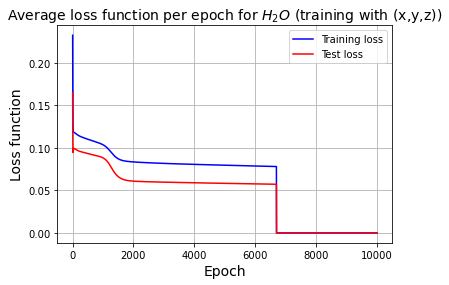

In [102]:
x = np.arange(1,nepochs+1)
# plt.plot(x[200:600],train_loss[200:600],'blue',label = 'Training loss')
# plt.plot(x[200:600],test_loss[200:600],'red',label = 'Test loss')

plt.plot(x,train_loss_xyz,'blue',label = 'Training loss')
plt.plot(x,test_loss_xyz,'red',label = 'Test loss')


plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Loss function',fontsize=14)
plt.title('Average loss function per epoch for $H_2O$ (training with (x,y,z))',fontsize=14)
plt.grid()
plt.legend()
plt.savefig('x_y_z_loss_graph_H2O',bbox_inches='tight')
plt.show()

In [106]:
prediction_xyz = np.zeros(100)
for i in range(100):
    x1,x2,x3 = test_set_xyz[i]
    prediction_xyz[i] = net_xyz(x1, x2, x3)#[0]


tensor(-0.5770, dtype=torch.float64)


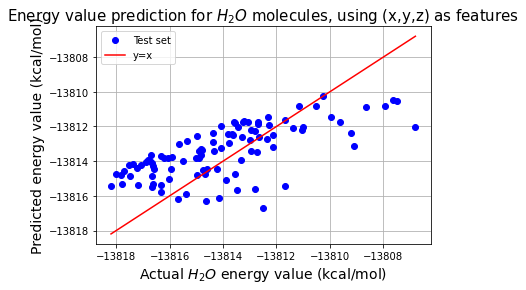

In [107]:
prediction_xyz = torch.tensor(prediction_xyz)

x = np.linspace(min(test_labels*var_lab+mean_lab), max(test_labels*var_lab+mean_lab))
print(min(torch.cat((test_labels,prediction_xyz),0)))
y = x
plt.plot(test_labels*var_lab+mean_lab,prediction_xyz*var_lab+mean_lab, 'o', color='blue', label = 'Test set')
plt.plot(x,y, color='red',label = 'y=x')
plt.grid()
#plt.xlim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction),0))])
#plt.ylim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction)))])
#plt.ylim([-13822,-13800])
#plt.ticklabel_format(axis="y", style="plain")
plt.ticklabel_format(useOffset=False, style='plain')
#plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Actual $H_2O$ energy value (kcal/mol)',fontsize=14)
plt.ylabel('Predicted energy value (kcal/mol)',fontsize=14)
plt.title('Energy value prediction for $H_2O$ molecules, using (x,y,z) as features',fontsize=15)
plt.legend()
plt.savefig('xyz_predicted_energies_H2O',bbox_inches='tight')
plt.show()

In [108]:
type(prediction_xyz)

torch.Tensor

In [109]:
rotated_test_set_xyz= np.zeros((np.shape(test_set_xyz)))
for i in range(100):
    coord = test_set_xyz[N*i:N*(i+1),:]
    coord = np.transpose(coord)
    A = random_rotation_matrix()
    rotated_test_set_xyz[N*i:N*(i+1),:] = np.transpose(rotate_data(A,coord))
print(np.shape(rotated_test_set_xyz))
rotated_test_set_xyz = torch.FloatTensor(rotated_test_set_xyz)

(100, 3, 3)


In [110]:
prediction_xyz_rot = np.zeros(100)
for i in range(100):
    x1,x2,x3 = rotated_test_set_xyz[i]
    prediction_xyz_rot[i] = net_xyz(x1, x2, x3)#[0]
print(prediction_xyz*var_lab+mean_lab)

tensor([-13814.2976, -13814.2243, -13814.4568, -13813.7620, -13816.2082,
        -13812.4088, -13811.4665, -13812.7416, -13812.1988, -13812.4930,
        -13815.3391, -13815.3990, -13813.2975, -13815.3084, -13815.3640,
        -13811.8277, -13812.8773, -13812.7984, -13812.5490, -13815.4311,
        -13811.7473, -13811.8812, -13816.1456, -13812.6112, -13814.3710,
        -13812.0351, -13814.0062, -13815.6265, -13815.0267, -13813.2008,
        -13811.4258, -13812.0131, -13812.3891, -13814.4555, -13812.9815,
        -13815.7526, -13815.4620, -13813.8268, -13811.6417, -13814.0267,
        -13812.4007, -13814.2219, -13810.5093, -13813.8182, -13814.5093,
        -13810.8231, -13813.9853, -13812.2535, -13812.4386, -13811.7178,
        -13811.6919, -13813.4090, -13814.8226, -13816.2709, -13815.0815,
        -13812.5785, -13814.8285, -13812.0600, -13812.8098, -13814.8100,
        -13811.7464, -13813.0063, -13812.1805, -13814.7688, -13812.4896,
        -13816.6920, -13813.3624, -13810.2324, -138

<ipython-input-111-7c0f4c3e1bb6>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction_xyz = torch.tensor(prediction_xyz)


tensor(-0.5770, dtype=torch.float64)


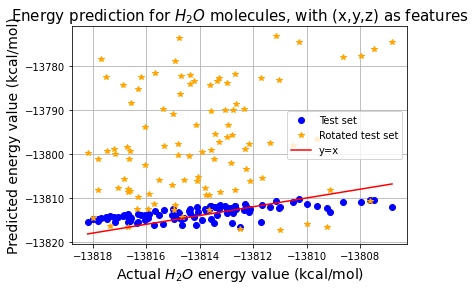

In [111]:
prediction_xyz_rot = torch.tensor(prediction_xyz_rot)
prediction_xyz = torch.tensor(prediction_xyz)

x = np.linspace(min(test_labels*var_lab+mean_lab), max(test_labels*var_lab+mean_lab))
print(min(torch.cat((test_labels,prediction_xyz_rot),0)))
y = x
plt.plot(test_labels*var_lab+mean_lab,prediction_xyz*var_lab+mean_lab, 'o', color='blue', label = 'Test set')
plt.plot(test_labels*var_lab+mean_lab,prediction_xyz_rot*var_lab+mean_lab, '*', color='orange', label = 'Rotated test set')
plt.plot(x,y, color='red',label = 'y=x')
plt.grid()
#plt.xlim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction),0))])
#plt.ylim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction)))])
#plt.ylim([-13822,-13800])
#plt.ticklabel_format(axis="y", style="plain")
plt.ticklabel_format(useOffset=False, style='plain')
#plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Actual $H_2O$ energy value (kcal/mol)',fontsize=14)
plt.ylabel('Predicted energy value (kcal/mol)',fontsize=14)
plt.title('Energy prediction for $H_2O$ molecules, with (x,y,z) as features',fontsize=15)
plt.legend()
plt.savefig('rot_xyz_predicted_energies_H2O',bbox_inches='tight')
plt.show()